### Machine Learning Project - Predicting 30-Day Unplanned Readmissions Amongst Patients with Diabetes

In [1]:
import pandas as pd 
import numpy as np
import random
import csv 
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from numpy.random import seed
from numpy.random import randn
from numpy import exp
from scipy.stats import boxcox
from scipy.stats import kurtosis, skew

from matplotlib import pyplot

# min max scaler (0-1)
def normalize(min_, max_, x):
    return ( x - min_ ) / ( max_ - min_ )

In [2]:
PATH_PROCESSED_DATA = "/ML_Project/"

In [3]:
df = pd.read_csv(PATH_PROCESSED_DATA + "ml_project_v1.csv", dtype=str)

In [5]:
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Calculate the mean age
mean_age = df['age'].mean()

# Calculate the lowest and highest age
min_age = df['age'].min()
max_age = df['age'].max()

# Print the results
print(f"Mean Age: {mean_age:.2f}")
print(f"Lowest Age: {min_age}")
print(f"Highest Age: {max_age}")


Mean Age: 60.40
Lowest Age: 18
Highest Age: 104


In [4]:
# Set Pandas to display all columns and rows without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # Avoid line wrapping
pd.set_option('display.max_colwidth', None) # Prevent truncation of column content

print(df.shape)
print(df.columns)

(1524750, 34)
Index(['ENCOUNTERID', 'PATID', 'ADMIT_DATETIME', 'DISCHARGE_DATETIME',
       'FACILITY_LOCATION', 'ENC_TYPE', 'DISCHARGE_STATUS', 'DX_codes', 'SEX',
       'HISPANIC', 'RACE', 'loincs_results_modifier_unit', 'DIASTOLIC',
       'SYSTOLIC', 'TOBACCO', 'RXNORM_CUI', 'age', 'distance', 'SDI_quantile',
       'ELIXHAUSER', 'DX_CCS_codes', 'PX_CCS', 'n_dx', 'n_px', 'readmission',
       'ADMIT_DURATION', 'prior_IP_OS_ED_count',
       'days_since_prior_IP_OS_ED_patient_level_int', 'isMetropolitan', 'CKD',
       'BMI', 'prior_other_encounter_types_count', 'RUCA_CODE',
       'days_since_prior_enc_patient_level'],
      dtype='object')


In [5]:
display(df.head())    # see the first 5 rows of the loaded table
df.dtypes

,ENCOUNTERID,PATID,ADMIT_DATETIME,DISCHARGE_DATETIME,FACILITY_LOCATION,ENC_TYPE,DISCHARGE_STATUS,DX_codes,SEX,HISPANIC,RACE,loincs_results_modifier_unit,DIASTOLIC,SYSTOLIC,TOBACCO,RXNORM_CUI,age,distance,SDI_quantile,ELIXHAUSER,DX_CCS_codes,PX_CCS,n_dx,n_px,readmission,ADMIT_DURATION,prior_IP_OS_ED_count,days_since_prior_IP_OS_ED_patient_level_int,isMetropolitan,CKD,BMI,prior_other_encounter_types_count,RUCA_CODE,days_since_prior_enc_patient_level
0,TEMPLE98836913,700000015,2018-03-27,2018-03-27,19140.0,ED,HO,J069;J069,F,N,03,NaN,NaN,NaN,02,1797907;197397;197397;197397;313782,71,5,1,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0,RSP006,-1,1,1,0,0,0,0,1.0,0,30.0+,0,1,0.0
1,TEMPLE63025039,700000015,2018-06-12,2018-06-12,19140.0,OS,HO,R6884;R079;Z6838;E785;Z7982;Z7984;E119;K219;I10;E669;R9431;E119;E669;E785;I10;K219;R6884;R9431;Z6838;Z7982;Z7984,F,N,03,2345-7;127;EQ;mg/dL#6299-2;8;EQ;mg/dL#98979-8;93.4;EQ;mg/dL#2160-0;0.67;EQ;mg/dL#2951-2;141;EQ;mmol/L#2028-9;27;EQ;mmol/L#33037-3;7;EQ;mmol/L#26464-8;7.5;EQ;10*3/uL#4544-3;35.3;EQ;%#10839-9;0.015;LT;ng/mL#2339-0;126;EQ;mg/dL#10839-9;0.015;LT;ng/mL#4548-4;6.8;EQ;%#13457-7;169;EQ;mg/dL#10839-9;0.015;LT;ng/mL,68.0;68.0;72.0;72.0;74.0;74.0;75.0;75.0;85.0;85.0;87.0;87.0;88.0;88.0;88.0;88.0;93.0;93.0,146.0;146.0;147.0;147.0;151.0;151.0;148.0;148.0;173.0;173.0;163.0;163.0;148.0;148.0;186.0;186.0;193.0;193.0,02,318272;308136;861007;318272;318272;308135;318272,71,5,1,0;0;0;0;0;1;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0,CIR012;XXX000;END010;FAC025;END002;DIG004;CIR007;END009;SYM017,235;236;233,11,10,0,0,1,76,1.0,2,30.0+,0,1,77.0
2,TEMPLE97377955,700000015,2020-02-01,2020-02-01,19140.0,ED,HO,H539;H259;H259;H539,F,N,03,2339-0;103;EQ;mg/dL,NaN,NaN,02,308136,73,5,1,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0,EYE010;EYE002,233,2,1,0,0,2,598,1.0,0,30.0+,0,1,599.0
3,TEMPLE93601259,700000015,2020-02-19,2020-02-19,19140.0,AV_TH,CLPSED,E119;Z1211;K219,F,N,03,NaN,87.0;88.0,153.0;153.0,02,198051;1242215;966920,73,5,1,0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0,END002;XXX000;DIG004,-1,3,0,0,0,3,17,1.0,0,30.0+,0,1,18.0
4,TEMPLE88803902,700000015,2020-03-10,2020-03-10,19140.0,CLPSED,CLPSED,Z1211,F,N,03,NaN,NaN,NaN,02,1242215,73,5,1,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0,XXX000,-1,1,0,0,0,3,37,1.0,0,30.0+,1,1,20.0


ENCOUNTERID                                    object
PATID                                          object
ADMIT_DATETIME                                 object
DISCHARGE_DATETIME                             object
FACILITY_LOCATION                              object
ENC_TYPE                                       object
DISCHARGE_STATUS                               object
DX_codes                                       object
SEX                                            object
HISPANIC                                       object
RACE                                           object
loincs_results_modifier_unit                   object
DIASTOLIC                                      object
SYSTOLIC                                       object
TOBACCO                                        object
RXNORM_CUI                                     object
age                                            object
distance                                       object
SDI_quantile                

In [6]:
# columns below need to be handled separately since they represent strings of semicolon separated values of all hospital information for a given encounter, or if do not fit into numerical/categorical categories
concatenated_cols = ['ELIXHAUSER', 'PX_CCS', 'RXNORM_CUI', 'ADMIT_DATETIME', 'DISCHARGE_DATETIME', 
                     'DX_codes', 'DX_CCS_codes','DIASTOLIC', 'SYSTOLIC', 'loincs_results_modifier_unit']

categorical_cols = ['ENC_TYPE', 'DISCHARGE_STATUS', 'SEX', 'HISPANIC', 'RACE', 'TOBACCO', 
                     'SDI_quantile', 'readmission',  'isMetropolitan', 'CKD', 'BMI', 'RUCA_CODE']

numerical_cols = ['age', 'distance', 
                 'prior_IP_OS_ED_count', 
                  'days_since_prior_IP_OS_ED_patient_level_int', 
                  'n_dx', 'n_px', 
                  'ADMIT_DURATION',
                  'prior_other_encounter_types_count', 'days_since_prior_enc_patient_level']

# For categorical columns, print the value counts
print("Categorical Columns Value Counts:")
for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col} Value Counts:")
        print(df[col].value_counts(dropna=False))  # dropna=False to include NaN values if needed

# For numerical columns, print summary statistics (describe)
print("\nNumerical Columns Summary Statistics:")
for col in numerical_cols:
    if col in df.columns:
        print(f"\n{col} Summary:")
        print(df[col].describe())

Categorical Columns Value Counts:

ENC_TYPE Value Counts:
CLPSED    748695
AV_TH     607022
ED         77621
IP         73016
OS         18396
Name: ENC_TYPE, dtype: int64

DISCHARGE_STATUS Value Counts:
CLPSED    1358641
HO         114011
HH          28555
SN_RH       12175
AM          11363
NaN             5
Name: DISCHARGE_STATUS, dtype: int64

SEX Value Counts:
F    834040
M    690710
Name: SEX, dtype: int64

HISPANIC Value Counts:
N         1112127
Y          382034
CLPSED      30589
Name: HISPANIC, dtype: int64

RACE Value Counts:
03          715339
CLPSED      404837
05          381586
01_02_04     22988
Name: RACE, dtype: int64

TOBACCO Value Counts:
03        660910
02        552019
01        298252
CLPSED      8128
NaN         5441
Name: TOBACCO, dtype: int64

SDI_quantile Value Counts:
4    468918
3    326809
1    254779
0    248356
2    225888
Name: SDI_quantile, dtype: int64

readmission Value Counts:
0    1510792
1      13958
Name: readmission, dtype: int64

isMetropolita

## Data Cleaning and Preprocessing

### 1. Replace Categories in `RUCA_CODE` and Categorical Columns (
- Replace `'6'` and `'9'` in `RUCA_CODE` with `'3+'`, `'1'` with `'1.0'`, and `'2'` with `'2.0'`.
- Replace `'NI'` in `BMI` column with `'CLPSED'`.
- Fill Missing Values in Categorical columns with `'CLPSED'`.
- Remove `'FACILITY_LOCATION'` column since it is a *redundant feature* - used to calculate `distance` from patient's zipcode to facility location.

In [7]:
# Replace specified categories with '3+'
df['RUCA_CODE'] = df['RUCA_CODE'].replace(['6', '9'], '3+')
df['RUCA_CODE'] = df['RUCA_CODE'].replace('1', '1.0')
df['RUCA_CODE'] = df['RUCA_CODE'].replace('2', '2.0')

df['BMI'] = df['BMI'].replace('NI', 'CLPSED')

columns = ['ENC_TYPE', 'DISCHARGE_STATUS', 'SEX', 'HISPANIC', 'RACE', 'TOBACCO', 'SDI_quantile', 'CKD', 'BMI', 'isMetropolitan', 'RUCA_CODE']

# Iterate through categorical columns and assign missing values to CLPSED category
for col in columns:
    df[col] = df[col].replace('', np.nan)
    if df[col].isna().any():  # Check if there are any missing values
        df[col] = df[col].fillna('CLPSED')  # Fill missing values with 'CLPSED'
        print(col)
        
# Drop FACILITY_LOCATION since redundant feature
df = df.drop(columns=['FACILITY_LOCATION'], errors='ignore')

DISCHARGE_STATUS
TOBACCO
isMetropolitan


### 2. Remove Invalid DX_CCS_Codes and PX_CCS Codes

- The `DX_CCS_Codes` and `PX_CCS codes` for a given encounter are concatenated into strings, meaning that a single encounter can have multiple diagnostic codes or procedure codes listed. However, there are instances in the dataset where some of these concatenated strings contain `NaN` values. Since this could be problematic for analysis and modeling, it is important to clean this data by removing such invalid entries.

- First, we will analyze what the top counts are for diagnostic and procedural codes and then revisit these counts after cleaning the columns

In [8]:
from collections import Counter

# 1. Check for missing or empty DX_CCS_codes
missing_values = df[df['DX_CCS_codes'].isna() | (df['DX_CCS_codes'] == '') | (df['DX_CCS_codes'] == 'XXX000')]

print("Rows with missing or empty DX_CCS_codes:")
display(missing_values[['PATID', 'ENCOUNTERID', 'DX_codes', 'DX_CCS_codes']].head(5))

def get_top_codes_with_percentages(df, column_name, top_n=10):
    # Flatten all codes into a list
    all_codes = [code for sublist in df[column_name].dropna().str.split(';').tolist() for code in sublist]
    
    # Count occurrences of each code
    code_counts = Counter(all_codes)
    
    # Total number of codes
    total_codes = len(all_codes)
    
    # Get the top most common codes
    most_common_codes = code_counts.most_common(top_n)
    
    # Calculate percentages
    most_common_codes_with_percentages = [(code, count, (count / total_codes) * 100) for code, count in most_common_codes]
    
    return most_common_codes_with_percentages

# Get top 10 DX codes for all encounters
top_encounters_dx_codes = get_top_codes_with_percentages(df, 'DX_CCS_codes')

print("Top 10 most frequently occurring DX codes for all encounters:")
for code, count, percentage in top_encounters_dx_codes:
    print(f"{code}: {count} ({percentage:.2f}%)")


# Get top 10 PX codes for each DataFrame
top_encounters_px_codes = get_top_codes_with_percentages(df, 'PX_CCS')

print("\nTop 10 most frequently occurring PX codes for all encounters:")
for code, count, percentage in top_encounters_px_codes:
    print(f"{code}: {count} ({percentage:.2f}%)")
    
print("\nSample of DX and PX codes for all encounters:")    
print(df['DX_CCS_codes'].head(5))
print(df['PX_CCS'].head(5))

Rows with missing or empty DX_CCS_codes:


,PATID,ENCOUNTERID,DX_codes,DX_CCS_codes
4,700000015,TEMPLE88803902,Z1211,XXX000
5,700000015,TEMPLE92520867,Z1211,XXX000
6,700000015,TEMPLE71912445,Z23,XXX000
10,700000021,TEMPLE68472214,Z95810,XXX000
128,700000022,TEMPLE91001130,Z942,XXX000


Top 10 most frequently occurring DX codes for all encounters:
XXX000: 1492874 (20.87%)
CIR007: 242603 (3.39%)
END003: 226762 (3.17%)
FAC025: 217439 (3.04%)
GEN003: 194934 (2.73%)
END010: 184015 (2.57%)
CIR019: 176220 (2.46%)
CIR011: 147853 (2.07%)
-1: 133429 (1.87%)
RSP008: 131883 (1.84%)

Top 10 most frequently occurring PX codes for all encounters:
-1: 796911 (34.42%)
233: 402333 (17.38%)
235: 186417 (8.05%)
206: 122945 (5.31%)
227: 110926 (4.79%)
226: 71289 (3.08%)
200: 70699 (3.05%)
197: 45496 (1.96%)
205: 43222 (1.87%)
236: 36075 (1.56%)

Sample of DX and PX codes for all encounters:
0                                                            RSP006
1    CIR012;XXX000;END010;FAC025;END002;DIG004;CIR007;END009;SYM017
2                                                     EYE010;EYE002
3                                              END002;XXX000;DIG004
4                                                            XXX000
Name: DX_CCS_codes, dtype: object
0             -1
1    235;236;

In [9]:
# Function to remove invalid codes
def remove_invalid_dx_codes(dx_codes):
    # Check if the value is NaN or empty
    if pd.isna(dx_codes) or dx_codes == '':
        return np.nan  
    
    # Split the codes, remove 'XXX000', and join back
    return ';'.join([code for code in dx_codes.split(';') if code != 'XXX000'])

# Apply the function to the entire 'DX_CCS_codes' column
df['DX_CCS_codes'] = df['DX_CCS_codes'].apply(remove_invalid_dx_codes)
df['DX_CCS_codes'] = df['DX_CCS_codes'].replace('', np.nan)
df['DX_CCS_codes'] = df['DX_CCS_codes'].fillna('UNKNOWN') 

In [15]:
# Get top 10 DX codes for all encounters
top_encounters_dx_codes = get_top_codes_with_percentages(df, 'DX_CCS_codes')

print("Top 10 most frequently occurring DX codes for all encounters:")
for code, count, percentage in top_encounters_dx_codes:
    print(f"{code}: {count} ({percentage:.2f}%)")
    
# 1. Check for missing or empty DX_CCS_codes
missing_values = df[df['DX_CCS_codes'].isna() | (df['DX_CCS_codes'] == '') | (df['DX_CCS_codes'] == 'XXX000')]

print("Rows with missing or empty DX_CCS_codes:")
display(missing_values[['PATID', 'ENCOUNTERID', 'DX_codes', 'DX_CCS_codes']].head())

display(df['DX_CCS_codes'].head())
print('-------------------')
display(df['PX_CCS'].head())

Top 10 most frequently occurring DX codes for all encounters:
CIR007: 242603 (4.21%)
END003: 226762 (3.93%)
FAC025: 217439 (3.77%)
GEN003: 194934 (3.38%)
END010: 184015 (3.19%)
CIR019: 176220 (3.05%)
CIR011: 147853 (2.56%)
-1: 133429 (2.31%)
RSP008: 131883 (2.29%)
END011: 126977 (2.20%)
Rows with missing or empty DX_CCS_codes:


,PATID,ENCOUNTERID,DX_codes,DX_CCS_codes


0                                                     RSP006
1    CIR012;END010;FAC025;END002;DIG004;CIR007;END009;SYM017
2                                              EYE010;EYE002
3                                              END002;DIG004
4                                                    UNKNOWN
Name: DX_CCS_codes, dtype: object

-------------------


0             -1
1    235;236;233
2            233
3             -1
4             -1
Name: PX_CCS, dtype: object

## Eligibility Criteria for Patient Inclusion:

### 1. Patients with Diabetes (Must have at least 1/3 Conditions Met)
1. **Diabetes Medication Flag**: Patient must have a flag indicating the use of diabetes medications.
    - Exclude prediabetes and PCOS Patients who are only taking metformin and only have the Diabetes Medication Flag 
2. **Elixhauser Condition**: Patient must meet the criteria for diabetes based on the Elixhauser comorbidity index.
3. **A1C Lab Value**: Patient's A1C lab value must be greater than or equal to 6.5.

### 2. Patients with at Least 1 Inpatient (IP) Encounter
- Patient must have at least one inpatient encounter during the study period.

### 1a.) Load Elixhauser Mappings for Eligibility Criteria

- **Elixhauser** refers to the **Elixhauser Comorbidity Index**, which is a widely used method to quantify the comorbidities of patients based on their medical history. The index includes a set of 30 conditions that are used to assess the risk of adverse outcomes, such as hospital readmission or mortality, by assigning a weight to each condition.
  
- In this dataset, the **Elixhauser** variable is stored as a string of one-hot encoded values, where each condition is represented by a binary flag (1 or 0) indicating the presence or absence of that condition.

- To apply the eligibility criteria, I will extract the relevant one-hot encoded columns from the **Elixhauser** data that are important for determining patient eligibility.



In [10]:
elixhauser_icd10_codes_keys = ['congestive_heart_failure', 'cardiac_arrhythmia', 'valvular_disease', 
                               'pulmonary_circulation_disorder', 'peripheral_vascular_disorder', 
                               'hypertension_uncomplicated', 'hypertension_complicated', 'paralysis', 
                               'other_neurological_disorder', 'chronic_pulmonary_disease', 
                               'diabetes_uncomplicated', 'diabetes_complicated', 'hypothyroidism', 
                               'renal_failure', 'liver_disease', 'peptic_ulcer_disease_excluding_bleeding', 
                               'aids_hiv', 'lymphoma', 'metastatic_cancer', 'solid_tumor_wo_metastasis', 
                               'rheumatoid_arhritis', 'coagulopathy', 'obesity', 'weight_loss', 
                               'fluid_and_electrolyte_disorders', 'blood_loss_anemia', 'deficiency_anemia', 
                               'alcohol_abuse', 'drug_abuse', 'psychoses', 'depression']

conditions = list(elixhauser_icd10_codes_keys)

# Find the indices of the conditions
condition_indices = {
    'diabetes_uncomplicated': conditions.index('diabetes_uncomplicated'),
    'diabetes_complicated': conditions.index('diabetes_complicated')
}
print("Indices of diabetes_complicated and diabetes_uncomplicated:")
print(condition_indices)

dict_keys(['congestive_heart_failure', 'cardiac_arrhythmia', 'valvular_disease', 'pulmonary_circulation_disorder', 'peripheral_vascular_disorder', 'hypertension_uncomplicated', 'hypertension_complicated', 'paralysis', 'other_neurological_disorder', 'chronic_pulmonary_disease', 'diabetes_uncomplicated', 'diabetes_complicated', 'hypothyroidism', 'renal_failure', 'liver_disease', 'peptic_ulcer_disease_excluding_bleeding', 'aids_hiv', 'lymphoma', 'metastatic_cancer', 'solid_tumor_wo_metastasis', 'rheumatoid_arhritis', 'coagulopathy', 'obesity', 'weight_loss', 'fluid_and_electrolyte_disorders', 'blood_loss_anemia', 'deficiency_anemia', 'alcohol_abuse', 'drug_abuse', 'psychoses', 'depression'])
Indices of diabetes_complicated and diabetes_uncomplicated:
{'diabetes_uncomplicated': 10, 'diabetes_complicated': 11}



### 1b) Load Diabetes Medication Mappings for Eligibility Criteria

- I have a **list of Diabetes Medication mappings** that map specific medication codes to medication categories (e.g., insulin, metformin, etc.).
  
- Since the eligibility criteria require including only **diabetes-related medications**, I will use this mapping file to filter the relevant medications (found in `RXNORM_CUI`) from the dataset.

- By reading in this mapping file, I can ensure that only the medications that are essential for determining eligibility (specifically for diabetes) are included in the analysis.



In [11]:
df_rxnorm_diab = pd.read_csv('/data/dassie/supplementaryData/RXNORM/RXNORM_OMOP_2024_Diabetes.csv', dtype=str)
print(df_rxnorm_diab.shape)
df_rxnorm_diab.rename(columns={'concept_code': 'rxnorm_cui'}, inplace=True)


print(df_rxnorm_diab.shape)
display(df_rxnorm_diab.head())
print(df_rxnorm_diab['atc_category'].value_counts())

df_rxnorm_nondiab = pd.read_csv('/data/dassie/supplementaryData/RXNORM/RXNORM_OMOP_2024_NonDiabetes.csv', dtype=str)

# Merge lipid modifying agents categories
df_rxnorm_nondiab['atc_category'] = df_rxnorm_nondiab['atc_category'].replace({
    'HMG CoA reductase inhibitors': 'LIPID MODIFYING AGENTS',
    'Fibrates': 'LIPID MODIFYING AGENTS',
    'includes PCSK9i, ezetimibe, others': 'LIPID MODIFYING AGENTS',
    'Bile acid sequestrants*': 'LIPID MODIFYING AGENTS',
    'Nicotinic acid*': 'LIPID MODIFYING AGENTS',
    'Other lipid modifying agents*': 'LIPID MODIFYING AGENTS'
})

print(df_rxnorm_nondiab.shape)
display(df_rxnorm_nondiab.head())

print(df_rxnorm_nondiab['atc_category'].value_counts())


(1935, 4)
(1935, 4)


,atc_category,concept_name,atc_code,rxnorm_cui
0,Insulins,3 ML insulin lispro 200 UNT/ML Pen Injector,A10AB,1652239
1,Insulins,"insulin, regular, beef Injectable Solution [Hypurin Bovine Neutral]",A10AB,386083
2,Insulins,"insulin (pork); parenteral (insulins and analog. for injection, fast-acting)",A10AB,A10AB03
3,Insulins,"insulin (beef); parenteral (insulins and analog. for injection, fast-acting)",A10AB,A10AB02
4,Insulins,"insulin glulisine, human Injectable Solution [Apidra]",A10AB,803193


Insulins                                              724
Sulfonylureas                                         277
Sodium-glucose co-transporter 2 (SGLT2) inhibitors    226
Biguanides                                            181
Glucagon-like peptide-1 (GLP-1) analogues             175
Dipeptidyl peptidase 4 (DPP-4) inhibitors             134
Other blood glucose lowering drugs, excl. insulins     89
Thiazolidinediones                                     83
Alpha glucosidase inhibitors                           33
Sulfonamides (heterocyclic)                             8
Aldose reductase inhibitors                             5
Name: atc_category, dtype: int64
(5897, 3)


,atc_category,rxnorm_cui,concept_name
0,AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM,1000000,amlodipine 5 MG / hydrochlorothiazide 12.5 MG / olmesartan medoxomil 40 MG Oral Tablet [Tribenzor]
1,AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM,1000001,amlodipine 5 MG / hydrochlorothiazide 25 MG / olmesartan medoxomil 40 MG Oral Tablet
2,AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM,1000003,amlodipine 5 MG / hydrochlorothiazide 25 MG / olmesartan medoxomil 40 MG [Tribenzor]
3,AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM,1000005,amlodipine 5 MG / hydrochlorothiazide 25 MG / olmesartan medoxomil 40 MG Oral Tablet [Tribenzor]
4,AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM,1009217,aliskiren 150 MG


LIPID MODIFYING AGENTS                           1359
CORTICOSTEROIDS FOR SYSTEMIC USE                 1342
BETA BLOCKING AGENTS                             1144
AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM    1053
ANTIHYPERTENSIVES                                 999
Name: atc_category, dtype: int64


### 1c. Apply Eligibility Criteria Based on Diabetes

- After loading the relevant mappings (Elixhauser and Diabetes Medications), I will apply the **eligibility criteria** for diabetes to ensure that only patients with confirmed diabetes are included in the analysis.
  
- The criteria for confirming diabetes include:
  1. **Diabetes Medication Flag**: Include patients who are prescribed diabetes-related medications.
  2. **Elixhauser Comorbidity Conditions**: Ensure patients meet the necessary conditions from the Elixhauser index that are associated with diabetes.
  3. **A1C Lab Value**: Filter patients whose A1C level is ≥ 6.5%, which is a diagnostic criterion for diabetes.
  
### 1d. Transform Medications (Both Diabetes and Non-Diabetes) to One-Hot Encodings Based on RXNORM_CUI Codes for a Given Encounter

- In addition to applying the eligibility criteria, I will **transform medications** into one-hot encoded values based on their **RXNORM_CUI codes** for each patient encounter.
  
- This transformation will allow the analysis to capture whether a patient was prescribed a particular medication during an encounter, including both diabetes-related and non-diabetes medications.
  
- **One-hot encoding** will create binary flags (1 or 0) for each diabetes and non-diabetes medication, representing its presence or absence in the patient's medication list for that encounter.


In [12]:
import pandas as pd
import numpy as np

print('Before diabetes Eligibility: ' + str(df.shape))

A1c = ['4548-4', '62388-4', '96595-4', '71875-9', '59261-8', '4549-2', '17856-6', '17855-8']

df['RXNORM_CUI'] = df['RXNORM_CUI'].fillna('0').astype(str)

# Get unique categories for both diabetes and non-diabetes medications to create one-hot encodings
diab_meds_categories = list(df_rxnorm_diab['atc_category'].unique())
nondiab_meds_categories = list(df_rxnorm_nondiab['atc_category'].unique())

# Convert each mapping into dictionaries for quick lookup
diab_meds_mapping = df_rxnorm_diab.set_index('rxnorm_cui')['atc_category'].to_dict()
nondiab_meds_mapping = df_rxnorm_nondiab.set_index('rxnorm_cui')['atc_category'].to_dict()

# Initialize lists for the final one-hot encoded columns for RXnorm and filtered rows
one_hot_diab, one_hot_nondiab, filtered_rows = [], [], []


for indx, row in df.iterrows():
    # Initialize flag
    has_diab_category = False

    # Check ICD conditions
    if not pd.isna(row['ELIXHAUSER']):
        elixhauser_list = list(map(int, row['ELIXHAUSER'].split(';')))
        if elixhauser_list[condition_indices['diabetes_uncomplicated']] == 1 or \
           elixhauser_list[condition_indices['diabetes_complicated']] == 1:
            has_diab_category = True

    # Check Lab Conditions for A1C
    if not pd.isna(row['loincs_results_modifier_unit']):
        labs = row['loincs_results_modifier_unit'].replace('\'', '')
        if '{#}' in labs:
            labs = labs.replace('{#}', '{}')

        tokens = labs.split('#')
        for t in tokens:
            parts = t.split(';')
            if len(parts) < 2:
                continue

            code = parts[0].strip()
            result = parts[1].strip()

            if code in A1c:  # Check for A1C codes
                try:
                    result_value = float(result)
                    if result_value >= 6.5:
                        has_diab_category = True
                except ValueError:
                    continue

    # Process each RXNORM_CUI in the row
    
    # Initialize one-hot vectors for diabetes and non-diabetes categories
    diab_ohe = np.zeros(len(diab_meds_categories), dtype=int)
    nondiab_ohe = np.zeros(len(nondiab_meds_categories), dtype=int)
    
    rxnorm_codes = row['RXNORM_CUI'].split(';')

    for rx in rxnorm_codes:
        # Check diabetes categories
        if rx in diab_meds_mapping:
            # Exclude Insulin ordered in hospital ENC type (IP, OS, EI) from diabetes definition
            if row['ENC_TYPE'] in ['IP', 'OS'] and diab_meds_mapping[rx] == 'INSULINS':
                continue # Don't update diab_ohe for insulin

            # Otherwise, update the one-hot encoding
            diab_idx = diab_meds_categories.index(diab_meds_mapping[rx])
            diab_ohe[diab_idx] = 1
            
            # exlude SGLT2i and GLP1RA from definition
            if diab_meds_mapping[rx] not in ['Sodium-glucose co-transporter 2 (SGLT2) inhibitors', 
                                              'Glucagon-like peptide-1 (GLP-1) analogues']:
                has_diab_category = True


        # Check non-diabetes categories
        if rx in nondiab_meds_mapping:
            nondiab_idx = nondiab_meds_categories.index(nondiab_meds_mapping[rx])
            nondiab_ohe[nondiab_idx] = 1

    # Only add rows that have at least one diabetes category
    if has_diab_category:
        one_hot_diab.append(diab_ohe) # append one-hot encoding of diabetes meds
        one_hot_nondiab.append(nondiab_ohe) # append one-hot encoding of non-diabetes meds
        filtered_rows.append(row)

# Convert to DataFrames and merge
filtered_df = pd.DataFrame(filtered_rows).reset_index(drop=True)
diab_ohe_df = pd.DataFrame(one_hot_diab, columns=diab_meds_categories)
nondiab_ohe_df = pd.DataFrame(one_hot_nondiab, columns=nondiab_meds_categories)

# Concatenate the filtered df with one-hot encoded diabetes and non-diabetes 
final_df = pd.concat([filtered_df, diab_ohe_df, nondiab_ohe_df], axis=1)

# Display result
display(final_df.head())
print('After diabetes Eligibility: ' + str(final_df.shape))

Before diabetes Eligibility: (1524750, 33)


ENCOUNTERID      PATID ADMIT_DATETIME DISCHARGE_DATETIME ENC_TYPE  \
0  TEMPLE63025039  700000015     2018-06-12         2018-06-12       OS   
1  TEMPLE93601259  700000015     2020-02-19         2020-02-19    AV_TH   
2  TEMPLE58999755  700000015     2022-08-26         2022-08-29       IP   
3  TEMPLE89592217  700000021     2017-02-15         2017-02-19       IP   
4  TEMPLE63296416  700000021     2017-04-15         2017-04-25       IP   

  DISCHARGE_STATUS  \
0               HO   
1           CLPSED   
2               HO   
3               HH   
4               HH   

                                                                                                                                                                                                                                                                                                                                                    DX_codes  \
0                                                                                                                                                                                                                                           R6884;R079;Z6838;E785;Z7982;Z7984;E119;K219;I10;E669;R9431;E119;E669;E785;I10;K219;R6884;R9431;Z6838;Z7982;Z7984   
1                                                                                                                                                                                                                                                                                                                                            E119;Z1211;K219   
2                                                                                                                                                                                                           N3090;E876;R7881;N179;N3000;Z7982;I2510;E785;Z90710;D169;K219;R197;I10;E119;D169;E119;E785;E876;I10;I2510;K219;N179;N3090;R197;R7881;Z7982;Z9071   
3     C671;R351;Z125;N179;L89629;Z809;Z8249;R251;D631;J45909;K219;E785;Z95810;I429;Z794;E11649;E11610;E1140;N189;Z6841;E662;J9612;N179;I5023;I130;J45909;E662;I10;E6601;G4733;M79606;M7989;Z833;E876;Z713;Z8551;E162;D631;E1140;E1161;E1164;E662;E785;E876;I130;I429;I5023;J4590;J9612;K219;L8962;N179;N189;R251;Z6841;Z713;Z794;Z809;Z8249;Z833;Z8551;Z9581   
4  I5023;Z7902;Z91119;Z95810;Z794;F5089;Z809;Z8249;Z8489;Z8673;G4733;Z6838;E785;E11621;I480;D62;E11610;I429;E1140;E1122;I130;I5022;R0602;D649;I214;M109;Z91148;Z833;Z8551;D509;N1830;L97429;E876;F5089;G4733;I130;I429;I480;I5023;L9742;M109;N183;Z6838;Z7902;Z794;Z809;Z8249;Z833;Z8489;Z8551;Z8673;Z9111;Z9114;Z9581;D509;D62;E1122;E1140;E1161;E1162;E785   

  SEX HISPANIC RACE  \
0   F        N   03   
1   F        N   03   
2   F        N   03   
3   M        N   03   
4   M        N   03   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

After diabetes Eligibility: (264951, 49)


### 1e) Remove prediabetes and PCOS Patients who are only taking metformin (Amongst patients who only have diabetes medication flag to satisfy eligibility) 

In [14]:
PATH_METFORMIN_DATA = "/data/dassie/Temple/Temple_Processed_Temp/Processed/"
print(df.shape)
print(len(df['PATID'].unique()))
prediab_pcos_patids = pd.read_csv(PATH_METFORMIN_DATA + 'metformin_only_prediabetes_pcos.csv', dtype=str)
print(prediab_pcos_patids.head())
print(prediab_pcos_patids.shape)

df = df[~df['PATID'].isin(prediab_pcos_patids['PATID'])]
print(df.shape)
print(len(df['PATID'].unique()))

(1524750, 33)
30066
       PATID
0  700089985
1  700009218
2  700121347
3  700128449
4  700097282
(27, 1)
(1522897, 33)
30039


In [15]:
print(len(df['PATID'].unique()))
print(len(final_df['PATID'].unique()))

30039
28742


In [16]:
print(final_df.shape)
display(final_df.head())

(264951, 49)


ENCOUNTERID      PATID ADMIT_DATETIME DISCHARGE_DATETIME ENC_TYPE  \
0  TEMPLE63025039  700000015     2018-06-12         2018-06-12       OS   
1  TEMPLE93601259  700000015     2020-02-19         2020-02-19    AV_TH   
2  TEMPLE58999755  700000015     2022-08-26         2022-08-29       IP   
3  TEMPLE89592217  700000021     2017-02-15         2017-02-19       IP   
4  TEMPLE63296416  700000021     2017-04-15         2017-04-25       IP   

  DISCHARGE_STATUS  \
0               HO   
1           CLPSED   
2               HO   
3               HH   
4               HH   

                                                                                                                                                                                                                                                                                                                                                    DX_codes  \
0                                                                                                                                                                                                                                           R6884;R079;Z6838;E785;Z7982;Z7984;E119;K219;I10;E669;R9431;E119;E669;E785;I10;K219;R6884;R9431;Z6838;Z7982;Z7984   
1                                                                                                                                                                                                                                                                                                                                            E119;Z1211;K219   
2                                                                                                                                                                                                           N3090;E876;R7881;N179;N3000;Z7982;I2510;E785;Z90710;D169;K219;R197;I10;E119;D169;E119;E785;E876;I10;I2510;K219;N179;N3090;R197;R7881;Z7982;Z9071   
3     C671;R351;Z125;N179;L89629;Z809;Z8249;R251;D631;J45909;K219;E785;Z95810;I429;Z794;E11649;E11610;E1140;N189;Z6841;E662;J9612;N179;I5023;I130;J45909;E662;I10;E6601;G4733;M79606;M7989;Z833;E876;Z713;Z8551;E162;D631;E1140;E1161;E1164;E662;E785;E876;I130;I429;I5023;J4590;J9612;K219;L8962;N179;N189;R251;Z6841;Z713;Z794;Z809;Z8249;Z833;Z8551;Z9581   
4  I5023;Z7902;Z91119;Z95810;Z794;F5089;Z809;Z8249;Z8489;Z8673;G4733;Z6838;E785;E11621;I480;D62;E11610;I429;E1140;E1122;I130;I5022;R0602;D649;I214;M109;Z91148;Z833;Z8551;D509;N1830;L97429;E876;F5089;G4733;I130;I429;I480;I5023;L9742;M109;N183;Z6838;Z7902;Z794;Z809;Z8249;Z833;Z8489;Z8551;Z8673;Z9111;Z9114;Z9581;D509;D62;E1122;E1140;E1161;E1162;E785   

  SEX HISPANIC RACE  \
0   F        N   03   
1   F        N   03   
2   F        N   03   
3   M        N   03   
4   M        N   03   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

### 2a. Apply Second Eligibility Criterion - Remove Patients Without Any Inpatient (IP) Encounters

- The second eligibility criterion involves removing patients who do not have any **Inpatient (IP) encounters**.
  
- An **Inpatient (IP) encounter** refers to a medical event where a patient is formally admitted to a hospital or healthcare facility for a stay that lasts longer than 24 hours. This could include surgeries, treatments, or conditions that require extended monitoring and care.
  
- By filtering out patients without any IP encounters, we ensure that only those who have been hospitalized or received inpatient care are included in the analysis.


In [17]:
df = final_df.copy()

In [18]:
# remove patients who dont have IP encounters
# get their IDs 

patients_ = [] # patients without IP encounters 

for indx, rows in df.groupby("PATID"):
    found = False
    for i, row in rows.iterrows():
        
        if row['ENC_TYPE'] == 'IP':
            found = True
            
    if not found: 
        patients_.append(indx)

# ----------------------------------------------------------------------
print(len(patients_)) # remove those patients
print(df['PATID'].unique().shape)

# df[ ~ df['PATID'].isin(patients_) ]['PATID'].unique().shape
df = df[ ~ df['PATID'].isin(patients_) ]
print(df['PATID'].unique().shape)

print(df.shape)

1273
(28742,)
(27469,)
(261000, 49)


In [19]:
print(df.shape)
print(df.columns)

(261000, 49)
Index(['ENCOUNTERID', 'PATID', 'ADMIT_DATETIME', 'DISCHARGE_DATETIME',
       'ENC_TYPE', 'DISCHARGE_STATUS', 'DX_codes', 'SEX', 'HISPANIC', 'RACE',
       'loincs_results_modifier_unit', 'DIASTOLIC', 'SYSTOLIC', 'TOBACCO',
       'RXNORM_CUI', 'age', 'distance', 'SDI_quantile', 'ELIXHAUSER',
       'DX_CCS_codes', 'PX_CCS', 'n_dx', 'n_px', 'readmission',
       'ADMIT_DURATION', 'prior_IP_OS_ED_count',
       'days_since_prior_IP_OS_ED_patient_level_int', 'isMetropolitan', 'CKD',
       'BMI', 'prior_other_encounter_types_count', 'RUCA_CODE',
       'days_since_prior_enc_patient_level', 'Insulins',
       'Glucagon-like peptide-1 (GLP-1) analogues', 'Biguanides',
       'Sulfonylureas', 'Sulfonamides (heterocyclic)',
       'Alpha glucosidase inhibitors', 'Thiazolidinediones',
       'Dipeptidyl peptidase 4 (DPP-4) inhibitors',
       'Sodium-glucose co-transporter 2 (SGLT2) inhibitors',
       'Other blood glucose lowering drugs, excl. insulins',
       'Aldose reductase

In [21]:
df.to_csv(PATH_PROCESSED_DATA + "ml_project_v2.csv", index=False)

In [22]:
del final_df

### Visualize Distribution of Features

In [3]:
df = pd.read_csv(PATH_PROCESSED_DATA + "ml_project_v2.csv", dtype=str)

In [4]:
df_ = df.copy()

Categorical Columns Value Counts and Bar Charts:

ENC_TYPE Value Counts and Percentages:
         Count  Percentage
AV_TH   116206   44.523372
CLPSED   66966   25.657471
IP       59526   22.806897
OS       11979    4.589655
ED        6323    2.422605


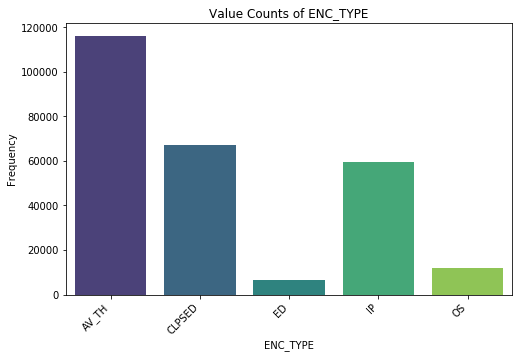


DISCHARGE_STATUS Value Counts and Percentages:
         Count  Percentage
CLPSED  185667   71.136782
HO       37611   14.410345
HH       23803    9.119923
SN_RH    10390    3.980843
AM        3529    1.352107


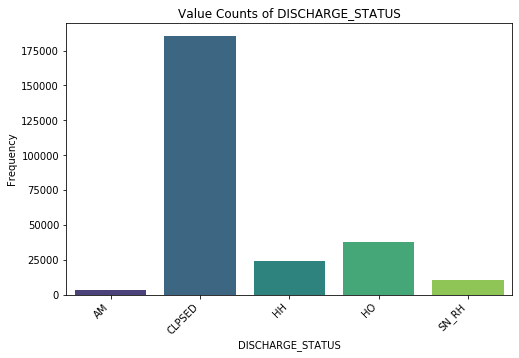


SEX Value Counts and Percentages:
    Count  Percentage
F  139932   53.613793
M  121068   46.386207


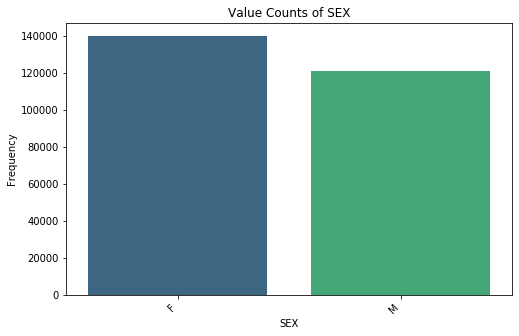


HISPANIC Value Counts and Percentages:
         Count  Percentage
N       181915   69.699234
Y        74133   28.403448
CLPSED    4952    1.897318


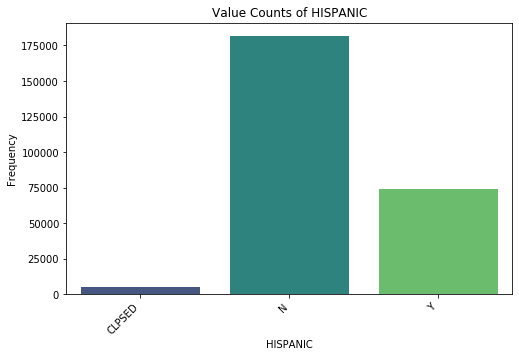


RACE Value Counts and Percentages:
           Count  Percentage
03        134968   51.711877
CLPSED     77282   29.609962
05         44725   17.136015
01_02_04    4025    1.542146


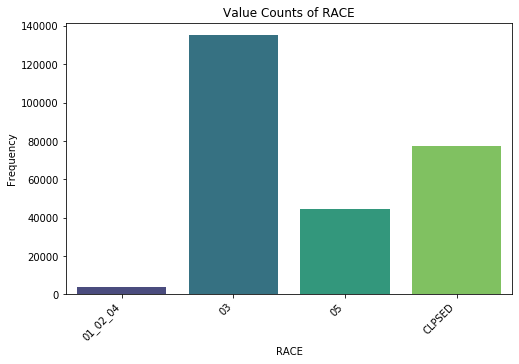


TOBACCO Value Counts and Percentages:
         Count  Percentage
03      102281   39.188123
02       99239   38.022605
01       55378   21.217625
CLPSED    4102    1.571648


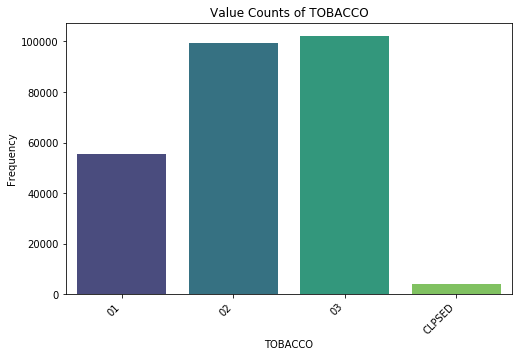


SDI_quantile Value Counts and Percentages:
   Count  Percentage
4  94113   36.058621
3  60863   23.319157
1  40675   15.584291
2  39252   15.039080
0  26097    9.998851


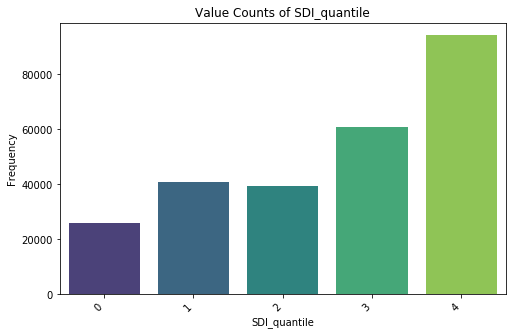


isMetropolitan Value Counts and Percentages:
         Count  Percentage
1.0     259795   99.538314
0.0        640    0.245211
CLPSED     565    0.216475


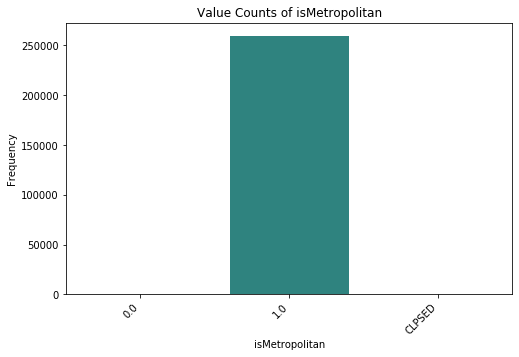


CKD Value Counts and Percentages:
    Count  Percentage
0  148935   57.063218
2   40638   15.570115
3   38922   14.912644
5   14147    5.420307
4   13445    5.151341
1    4913    1.882375


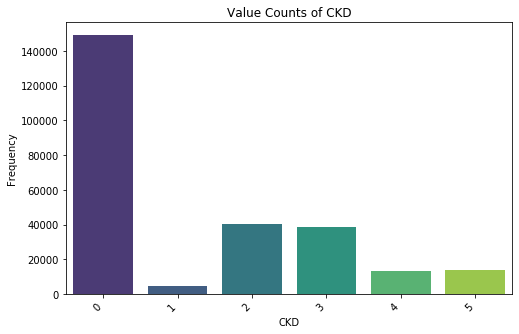


BMI Value Counts and Percentages:
              Count  Percentage
30.0+        139757   53.546743
25.0 – 29.9   67612   25.904981
18.5 – 24.9   44996   17.239847
<18.5          4737    1.814943
CLPSED         3898    1.493487


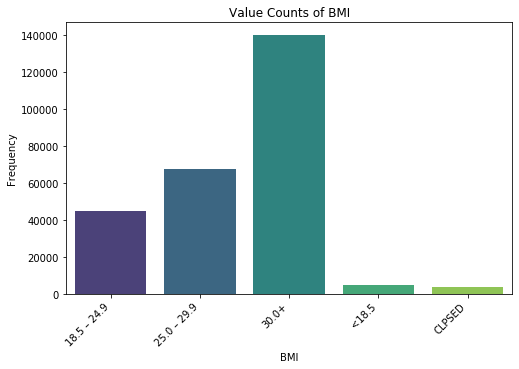


RUCA_CODE Value Counts and Percentages:
         Count  Percentage
1.0     258216   98.933333
2.0       1432    0.548659
3+        1075    0.411877
CLPSED     277    0.106130


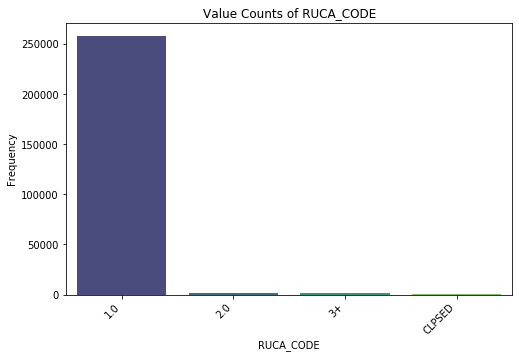


Insulins Value Counts and Percentages:
    Count  Percentage
0  159561   61.134483
1  101439   38.865517


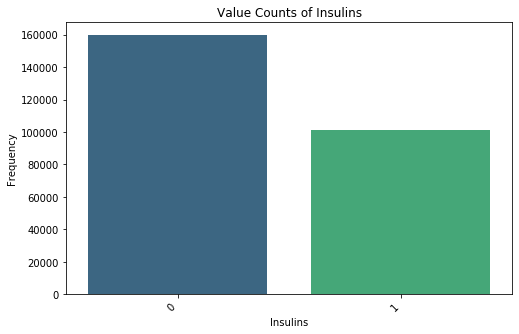


Glucagon-like peptide-1 (GLP-1) analogues Value Counts and Percentages:
    Count  Percentage
0  252029   96.562835
1    8971    3.437165


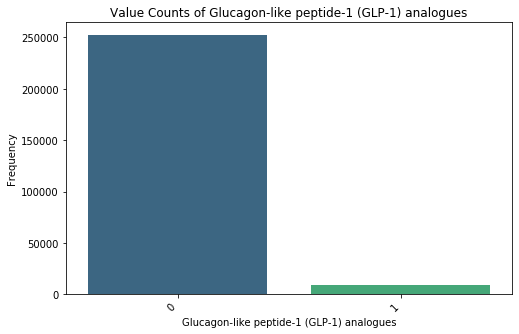


Biguanides Value Counts and Percentages:
    Count  Percentage
0  218700   83.793103
1   42300   16.206897


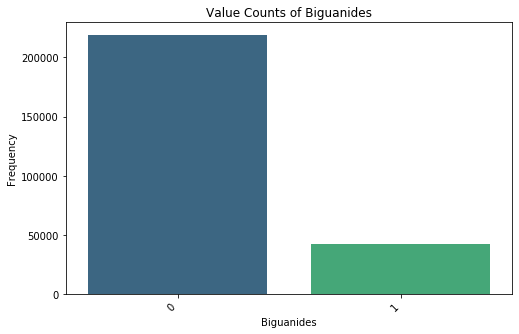


Sulfonylureas Value Counts and Percentages:
    Count  Percentage
0  249928   95.757854
1   11072    4.242146


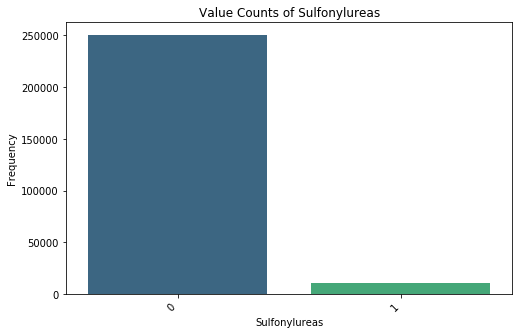


Sulfonamides (heterocyclic) Value Counts and Percentages:
    Count  Percentage
0  261000       100.0


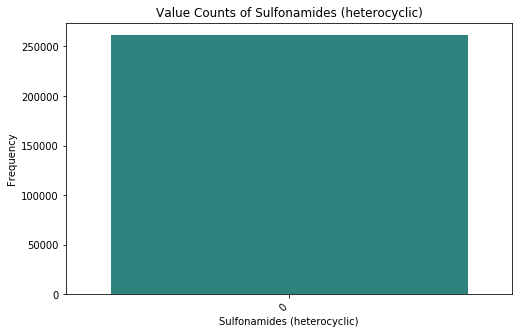


Alpha glucosidase inhibitors Value Counts and Percentages:
    Count  Percentage
0  260916   99.967816
1      84    0.032184


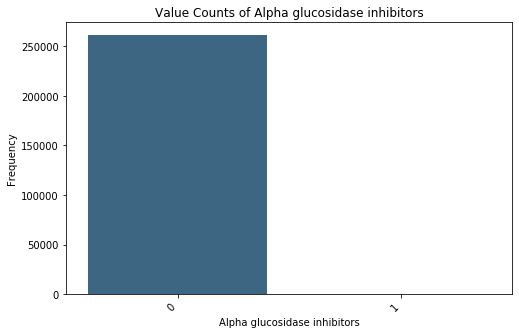


Thiazolidinediones Value Counts and Percentages:
    Count  Percentage
0  259877   99.569732
1    1123    0.430268


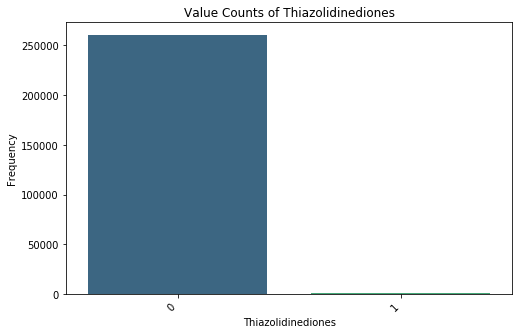


Dipeptidyl peptidase 4 (DPP-4) inhibitors Value Counts and Percentages:
    Count  Percentage
0  252939   96.911494
1    8061    3.088506


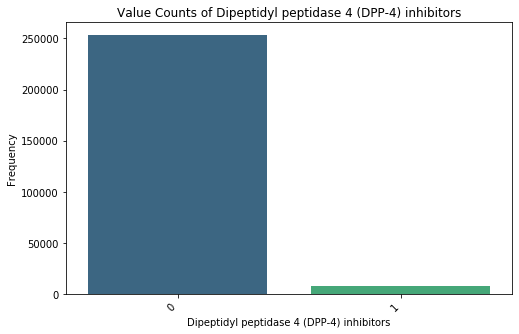


Sodium-glucose co-transporter 2 (SGLT2) inhibitors Value Counts and Percentages:
    Count  Percentage
0  255706   97.971648
1    5294    2.028352


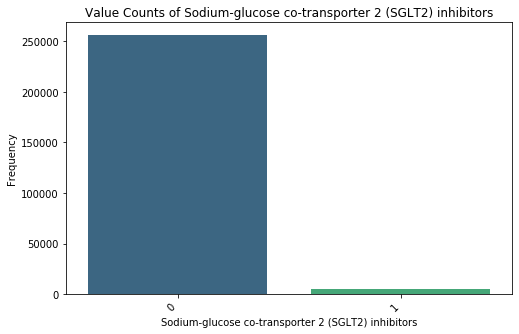


Other blood glucose lowering drugs, excl. insulins Value Counts and Percentages:
    Count  Percentage
0  260310   99.735632
1     690    0.264368


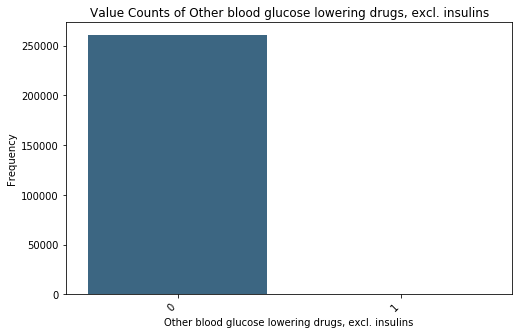


Aldose reductase inhibitors Value Counts and Percentages:
    Count  Percentage
0  261000       100.0


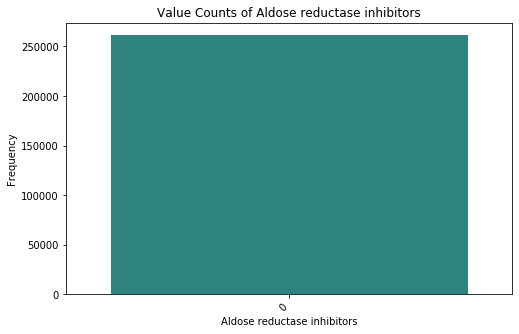


AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM Value Counts and Percentages:
    Count  Percentage
0  199397   76.397318
1   61603   23.602682


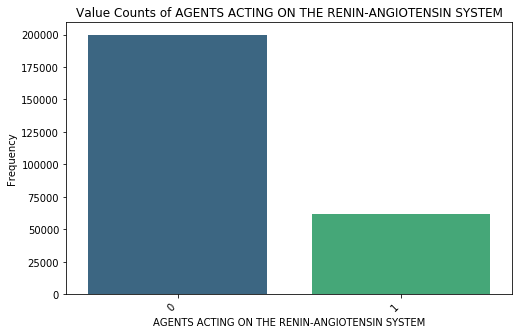


ANTIHYPERTENSIVES Value Counts and Percentages:
    Count  Percentage
0  239810   91.881226
1   21190    8.118774


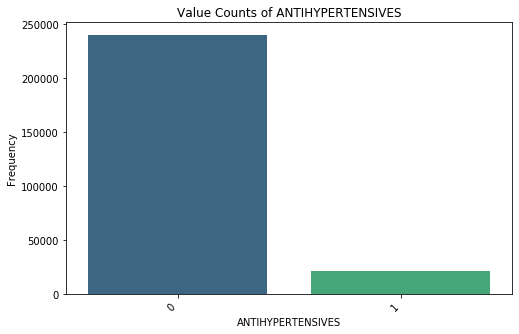


BETA BLOCKING AGENTS Value Counts and Percentages:
    Count  Percentage
0  200597   76.857088
1   60403   23.142912


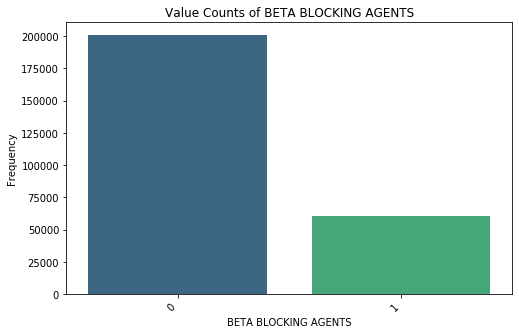


CORTICOSTEROIDS FOR SYSTEMIC USE Value Counts and Percentages:
    Count  Percentage
0  226359   86.727586
1   34641   13.272414


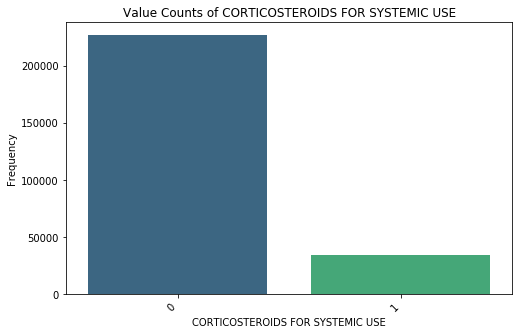


LIPID MODIFYING AGENTS Value Counts and Percentages:
    Count  Percentage
0  184183   70.568199
1   76817   29.431801


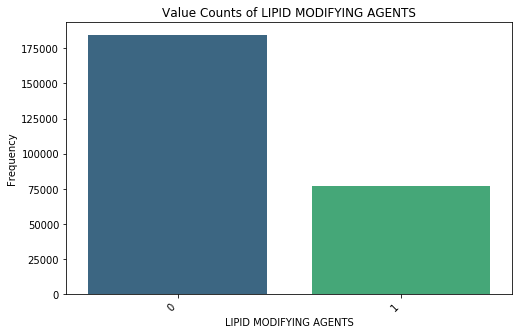


congestive_heart_failure Value Counts and Percentages:
    Count  Percentage
0  221484    84.85977
1   39516    15.14023


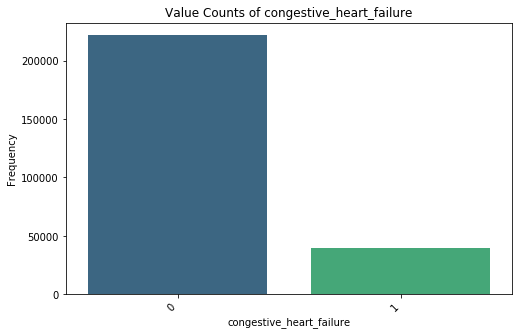


cardiac_arrhythmia Value Counts and Percentages:
    Count  Percentage
0  232589   89.114559
1   28411   10.885441


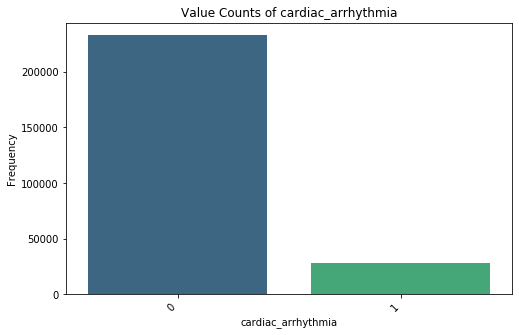


valvular_disease Value Counts and Percentages:
    Count  Percentage
0  250182   95.855172
1   10818    4.144828


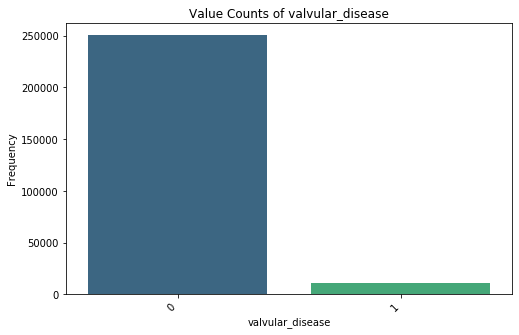


pulmonary_circulation_disorder Value Counts and Percentages:
    Count  Percentage
0  250791   96.088506
1   10209    3.911494


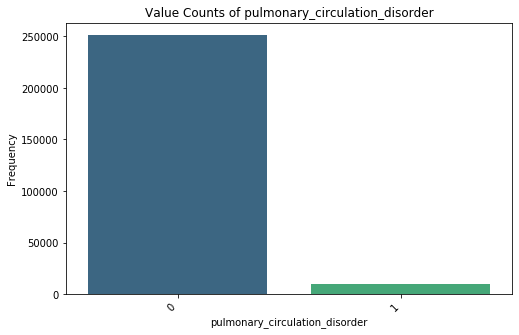


peripheral_vascular_disorder Value Counts and Percentages:
    Count  Percentage
0  241884   92.675862
1   19116    7.324138


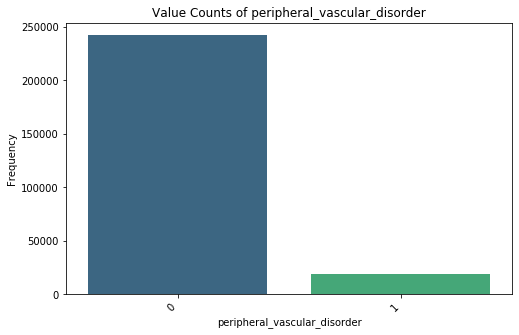


hypertension_uncomplicated Value Counts and Percentages:
    Count  Percentage
0  164016   62.841379
1   96984   37.158621


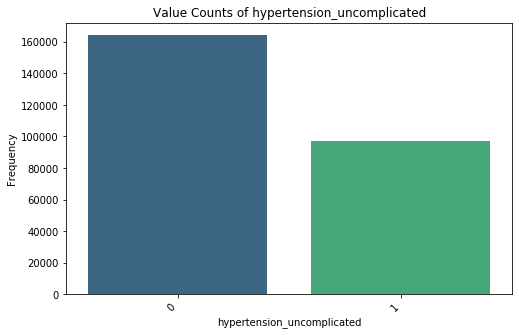


hypertension_complicated Value Counts and Percentages:
    Count  Percentage
0  219971   84.280077
1   41029   15.719923


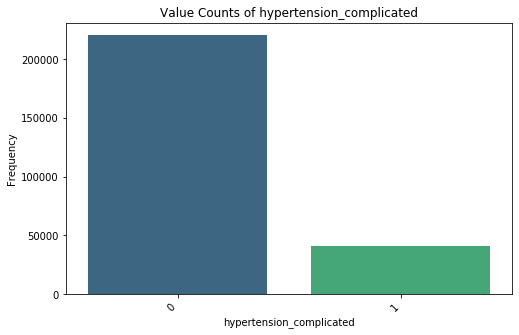


paralysis Value Counts and Percentages:
    Count  Percentage
0  258580   99.072797
1    2420    0.927203


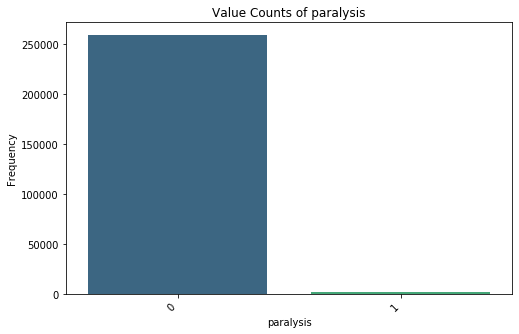


other_neurological_disorder Value Counts and Percentages:
    Count  Percentage
0  248210   95.099617
1   12790    4.900383


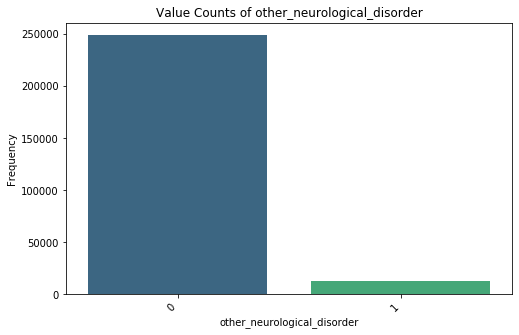


chronic_pulmonary_disease Value Counts and Percentages:
    Count  Percentage
0  217836   83.462069
1   43164   16.537931


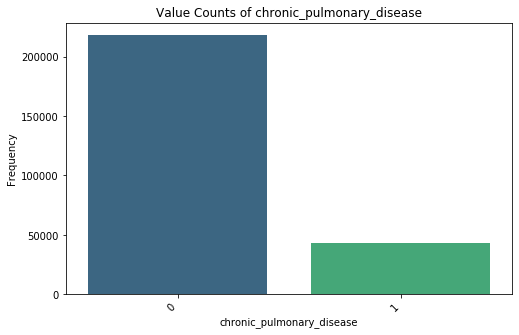


diabetes_uncomplicated Value Counts and Percentages:
    Count  Percentage
0  157168   60.217625
1  103832   39.782375


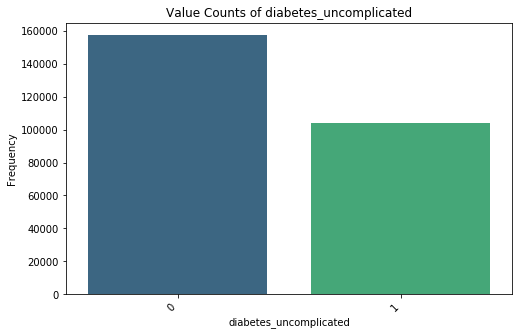


diabetes_complicated Value Counts and Percentages:
    Count  Percentage
0  141901   54.368199
1  119099   45.631801


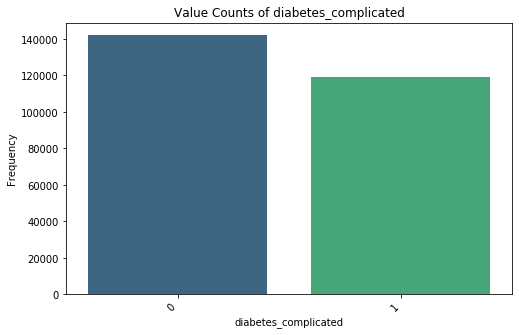


hypothyroidism Value Counts and Percentages:
    Count  Percentage
0  246402   94.406897
1   14598    5.593103


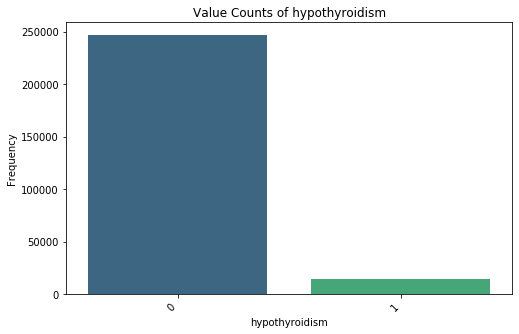


renal_failure Value Counts and Percentages:
    Count  Percentage
0  205493    78.73295
1   55507    21.26705


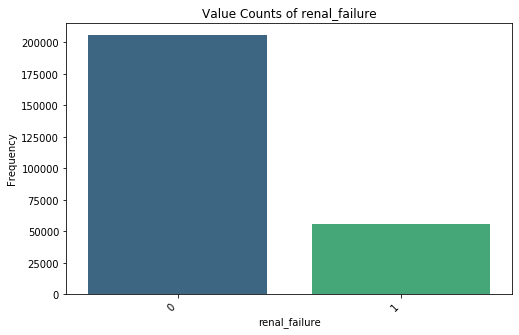


liver_disease Value Counts and Percentages:
    Count  Percentage
0  248944   95.380843
1   12056    4.619157


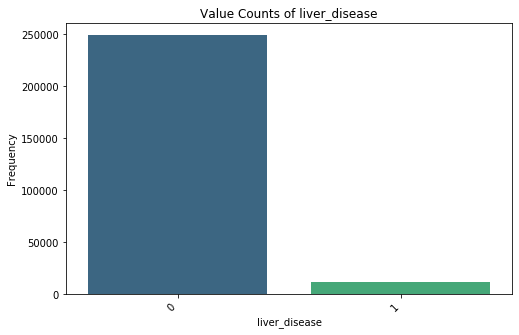


peptic_ulcer_disease_excluding_bleeding Value Counts and Percentages:
    Count  Percentage
0  259964   99.603065
1    1036    0.396935


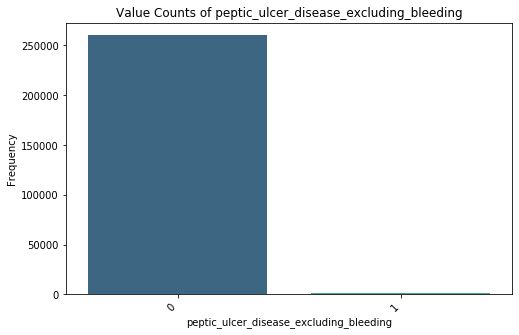


aids_hiv Value Counts and Percentages:
    Count  Percentage
0  256882   98.422222
1    4118    1.577778


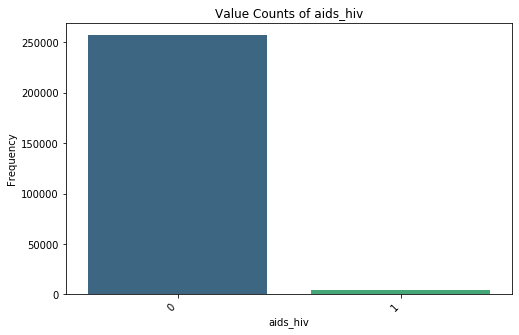


lymphoma Value Counts and Percentages:
    Count  Percentage
0  259654   99.484291
1    1346    0.515709


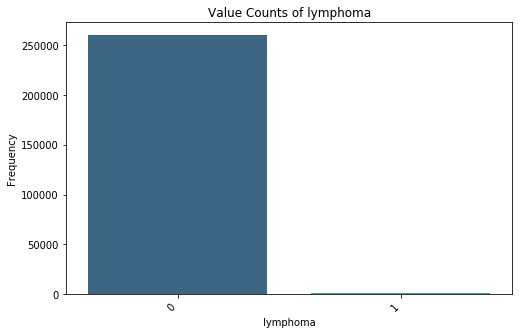


metastatic_cancer Value Counts and Percentages:
    Count  Percentage
0  258014   98.855939
1    2986    1.144061


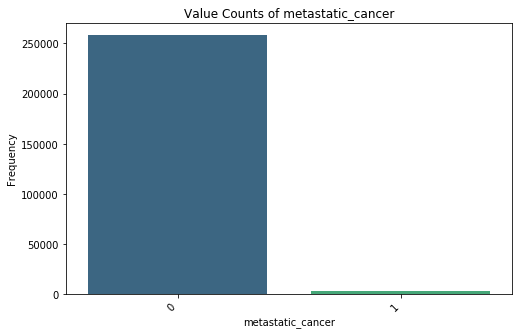


solid_tumor_wo_metastasis Value Counts and Percentages:
    Count  Percentage
0  251497   96.359004
1    9503    3.640996


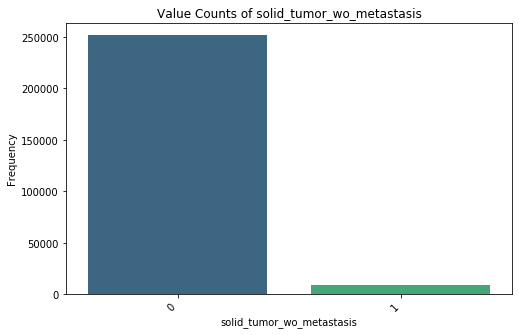


rheumatoid_arhritis Value Counts and Percentages:
    Count  Percentage
0  255969   98.072414
1    5031    1.927586


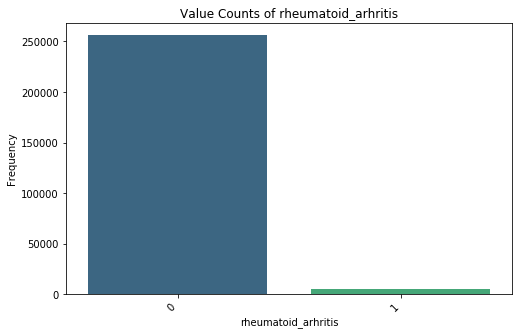


coagulopathy Value Counts and Percentages:
    Count  Percentage
0  253529   97.137548
1    7471    2.862452


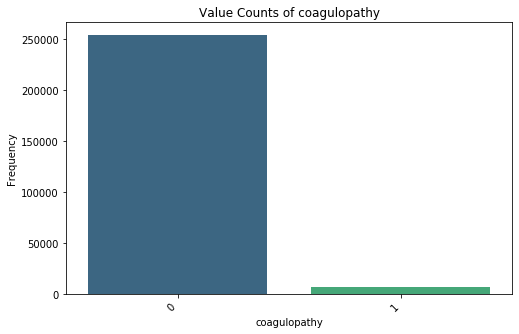


obesity Value Counts and Percentages:
    Count  Percentage
0  227963   87.342146
1   33037   12.657854


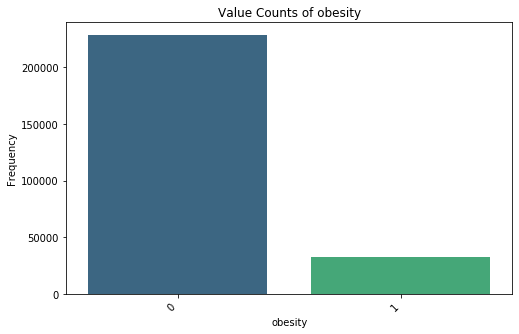


weight_loss Value Counts and Percentages:
    Count  Percentage
0  247730   94.915709
1   13270    5.084291


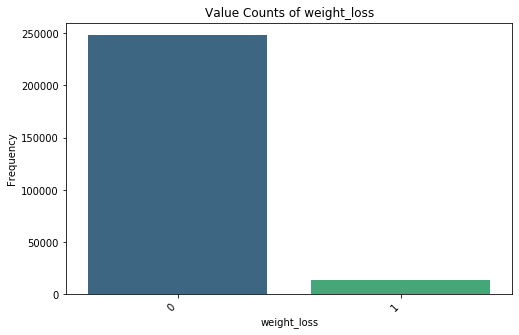


fluid_and_electrolyte_disorders Value Counts and Percentages:
    Count  Percentage
0  228589   87.581992
1   32411   12.418008


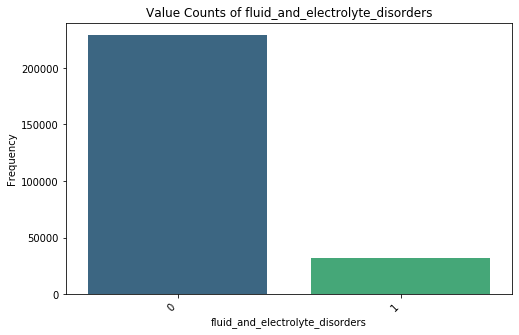


blood_loss_anemia Value Counts and Percentages:
    Count  Percentage
0  259186   99.304981
1    1814    0.695019


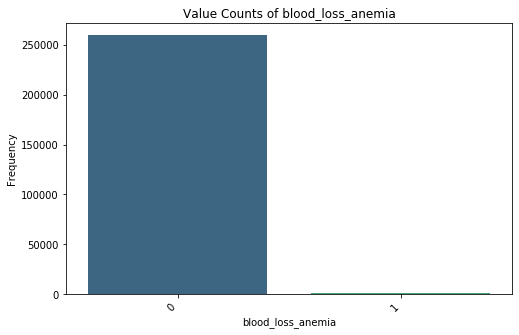


deficiency_anemia Value Counts and Percentages:
    Count  Percentage
0  251244   96.262069
1    9756    3.737931


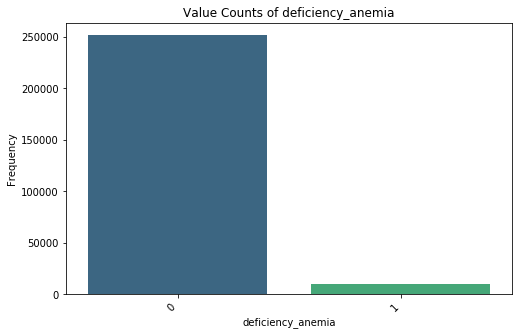


alcohol_abuse Value Counts and Percentages:
    Count  Percentage
0  254128    97.36705
1    6872     2.63295


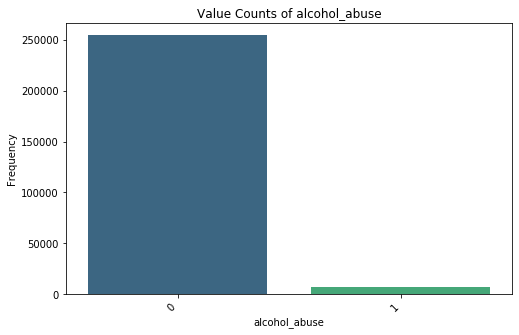


drug_abuse Value Counts and Percentages:
    Count  Percentage
0  248685   95.281609
1   12315    4.718391


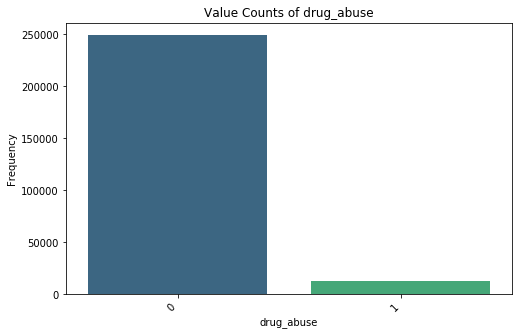


psychoses Value Counts and Percentages:
    Count  Percentage
0  255706   97.971648
1    5294    2.028352


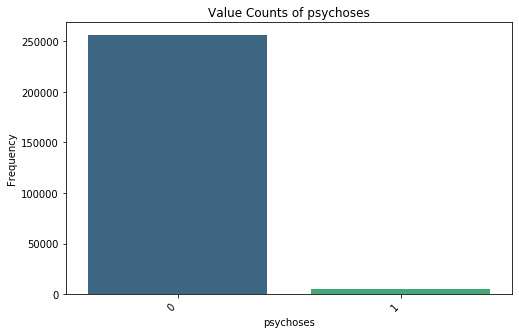


depression Value Counts and Percentages:
    Count  Percentage
0  242909   93.068582
1   18091    6.931418


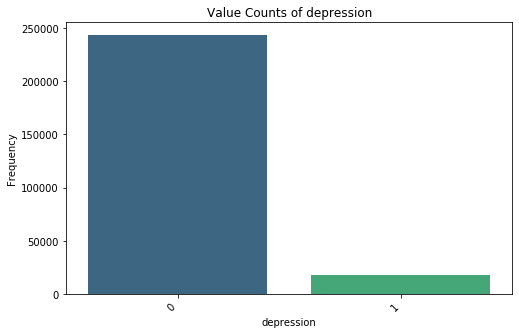

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# For categorical columns, print the value counts and display bar charts:

# 1. Expand the Elixhauser Comorbidity Index into separate columns
elixhauser_columns = [
    'congestive_heart_failure', 'cardiac_arrhythmia', 'valvular_disease',
    'pulmonary_circulation_disorder', 'peripheral_vascular_disorder', 
    'hypertension_uncomplicated', 'hypertension_complicated', 'paralysis', 
    'other_neurological_disorder', 'chronic_pulmonary_disease', 'diabetes_uncomplicated', 
    'diabetes_complicated', 'hypothyroidism', 'renal_failure', 'liver_disease', 
    'peptic_ulcer_disease_excluding_bleeding', 'aids_hiv', 'lymphoma', 
    'metastatic_cancer', 'solid_tumor_wo_metastasis', 'rheumatoid_arhritis', 
    'coagulopathy', 'obesity', 'weight_loss', 'fluid_and_electrolyte_disorders', 
    'blood_loss_anemia', 'deficiency_anemia', 'alcohol_abuse', 'drug_abuse', 
    'psychoses', 'depression'
]

medication_columns = ['Insulins', 'Glucagon-like peptide-1 (GLP-1) analogues', 'Biguanides', 'Sulfonylureas', 
                    'Sulfonamides (heterocyclic)', 'Alpha glucosidase inhibitors', 'Thiazolidinediones',
                    'Dipeptidyl peptidase 4 (DPP-4) inhibitors',
                    'Sodium-glucose co-transporter 2 (SGLT2) inhibitors',
                    'Other blood glucose lowering drugs, excl. insulins',
                    'Aldose reductase inhibitors',
                    'AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM', 'ANTIHYPERTENSIVES',
                    'BETA BLOCKING AGENTS', 'CORTICOSTEROIDS FOR SYSTEMIC USE', 'LIPID MODIFYING AGENTS']

categorical_columns = ['ENC_TYPE', 'DISCHARGE_STATUS', 'SEX', 'HISPANIC', 'RACE', 'TOBACCO', 
                     'SDI_quantile', 'isMetropolitan', 'CKD', 'BMI', 'RUCA_CODE']


# 2. Split the 'ELIXHAUSER' column into multiple new columns (this is expected to be a semicolon-separated string)
df_elixhauser_expanded = df_['ELIXHAUSER'].str.split(';', expand=True)

# Ensure the number of resulting columns matches the Elixhauser columns list
df_elixhauser_expanded.columns = elixhauser_columns

# 3. Join the expanded Elixhauser columns back to the original dataframe
df_ = df_.join(df_elixhauser_expanded)

all_categorical_cols = categorical_columns + medication_columns + elixhauser_columns

# Ensure categorical columns are converted to 'category' dtype for further analysis
df_[all_categorical_cols] = df_[all_categorical_cols].apply(lambda x: x.astype('category'))

print("Categorical Columns Value Counts and Bar Charts:")
for col in all_categorical_cols:
    if col in df_.columns:
        print(f"\n{col} Value Counts and Percentages:")
        
        # Get value counts and percentages
        value_counts = df_[col].value_counts(dropna=False)  # dropna=False to include NaN values if needed
        percentages = df_[col].value_counts(normalize=True, dropna=False) * 100  # normalize=True gives percentages
        
        # Combine value counts and percentages into a DataFrame
        value_percent_df = pd.DataFrame({
            'Count': value_counts,
            'Percentage': percentages
        })
        
        print(value_percent_df)
        
        # Plot bar chart for categorical values
        plt.figure(figsize=(8, 5))
        sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
        plt.title(f'Value Counts of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.show()


### Categorical Feature Relationships 

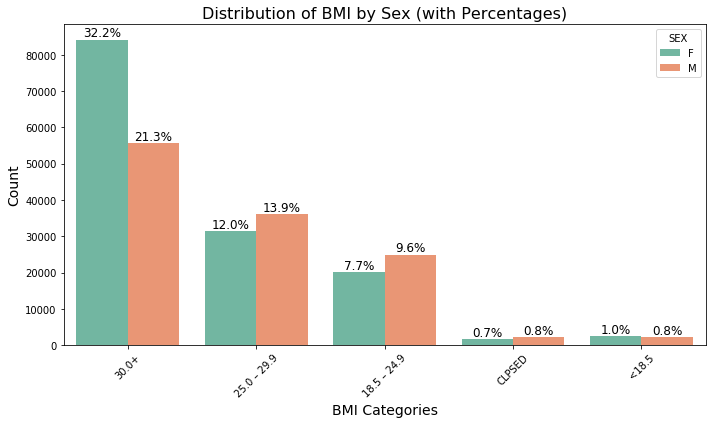

In [27]:
# Countplot to show the distribution of BMI categories by SEX with percentages

# Count the number of occurrences of each combination of 'BMI' and 'SEX'
count_data = pd.crosstab(df['BMI'], df['SEX'])

# Calculate percentages for each combination
count_data_percentage = count_data.div(count_data.sum(axis=1), axis=0) * 100

# Plotting the countplot with percentages
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='BMI', hue='SEX', palette='Set2')

# Add percentages on top of bars
for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get the position of the rectangle
    percentage = (height / df.shape[0]) * 100  # Calculate the percentage
    plt.text(x + width / 2, y + height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=12)

# Set titles and labels
plt.title('Distribution of BMI by Sex (with Percentages)', fontsize=16)
plt.xlabel('BMI Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

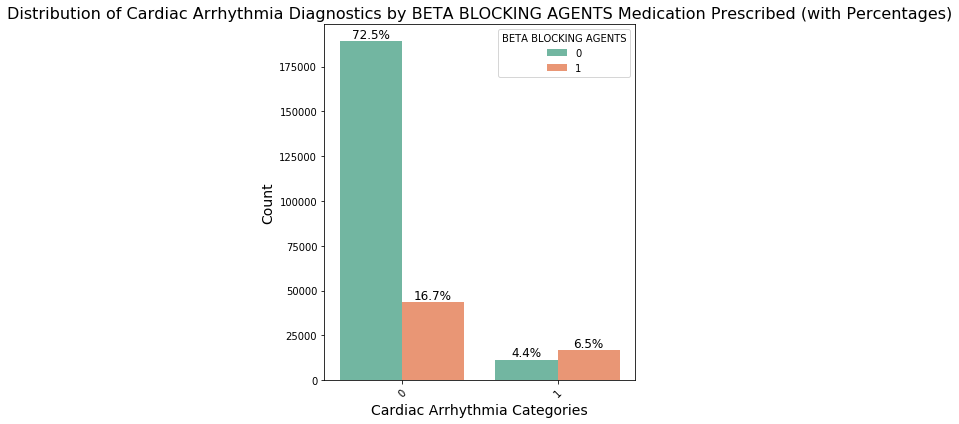

In [36]:
# Countplot to show the distribution of BMI categories by HISPANIC status with percentages
count_data = pd.crosstab(df_['cardiac_arrhythmia'], df_['BETA BLOCKING AGENTS'])
count_data_percentage = count_data.div(count_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.countplot(data=df_, x='cardiac_arrhythmia', hue='BETA BLOCKING AGENTS', palette='Set2')

# Add percentages on top of bars
for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get the position of the rectangle
    percentage = (height / df.shape[0]) * 100  # Calculate the percentage
    plt.text(x + width / 2, y + height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Cardiac Arrhythmia Diagnostics by BETA BLOCKING AGENTS Medication Prescribed (with Percentages)', fontsize=16)
plt.xlabel('Cardiac Arrhythmia Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


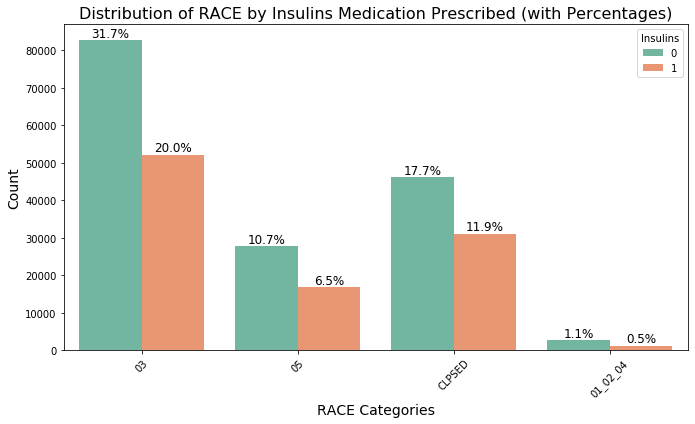

In [33]:
# Countplot to show the distribution of BMI categories by TOBACCO use with percentages
count_data = pd.crosstab(df['RACE'], df['Insulins'])
count_data_percentage = count_data.div(count_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='RACE', hue='Insulins', palette='Set2')

# Add percentages on top of bars
for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get the position of the rectangle
    percentage = (height / df.shape[0]) * 100  # Calculate the percentage
    plt.text(x + width / 2, y + height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title('Distribution of RACE by Insulins Medication Prescribed (with Percentages)', fontsize=16)
plt.xlabel('RACE Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/data/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 720x432 with 0 Axes>

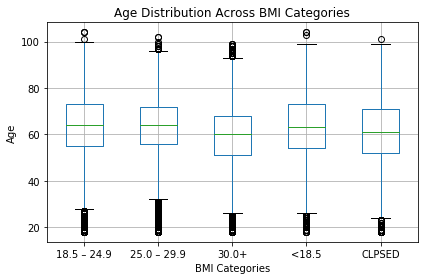

/data/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 720x432 with 0 Axes>

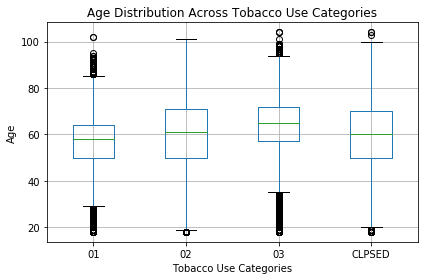

/data/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 720x432 with 0 Axes>

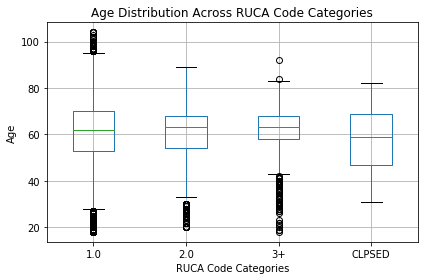

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Boxplot: Age Distribution by BMI 
df['age'] = pd.to_numeric(df['age'], errors='coerce')

plt.figure(figsize=(10, 6))
df.boxplot(column='age', by='BMI')

plt.title('Age Distribution Across BMI Categories')
plt.suptitle('')  
plt.xlabel('BMI Categories')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

# -------------------
# 2. Boxplot: Age Distribution by Tobacco Use
plt.figure(figsize=(10, 6))
df.boxplot(column='age', by='TOBACCO')

# Remove default title and add custom labels
plt.title('Age Distribution Across Tobacco Use Categories')
plt.suptitle('')  # Remove default "Boxplot" title
plt.xlabel('Tobacco Use Categories')
plt.ylabel('Age')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# -------------------
# 3. Boxplot: Age Distribution by RUCA_CODE
plt.figure(figsize=(10, 6))
df.boxplot(column='age', by='RUCA_CODE')

# Remove default title and add custom labels
plt.title('Age Distribution Across RUCA Code Categories')
plt.suptitle('')  # Remove default "Boxplot" title
plt.xlabel('RUCA Code Categories')
plt.ylabel('Age')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#### Observations on Diastolic and Systolic Blood Pressure Trends:

Below, we observe two key trends based on the boxplots of **diastolic** and **systolic** blood pressure across various age groups:

1. **Diastolic Blood Pressure**:  
   As expected, **diastolic blood pressure tends to decrease with age**. This trend is consistent with medical knowledge, where older individuals typically experience lower diastolic values due to changes in vascular elasticity and other age-related factors.

2. **Systolic Blood Pressure**:  
   Conversely, **systolic blood pressure generally increases with age**. This is also consistent with expected physiological changes, where the heart works harder to pump blood as individuals get older, resulting in higher systolic pressures.

These trends highlight the natural physiological changes that occur in the cardiovascular system as people age.


/data/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 720x432 with 0 Axes>

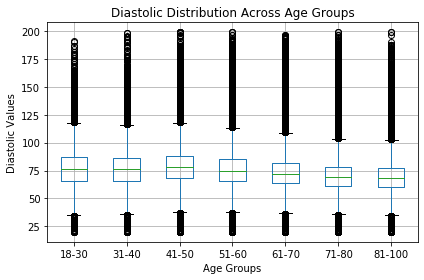

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Handle semicolon-separated 'DIASTOLIC' values by splitting and exploding them
df_['DIASTOLIC'] = df_['DIASTOLIC'].str.split(';')

# Explode the 'DIASTOLIC' column to create separate rows for each diastolic value
df_exploded = df_.explode('DIASTOLIC')

# 2. Convert 'DIASTOLIC' to numeric, forcing errors to NaN
df_exploded['DIASTOLIC'] = pd.to_numeric(df_exploded['DIASTOLIC'], errors='coerce')

# 3. Convert 'age' to numeric, forcing errors to NaN
df_exploded['age'] = pd.to_numeric(df_exploded['age'], errors='coerce')

# 4. Create age groups (bins)
age_bins = [18, 30, 40, 50, 60, 70, 80, 100]  # Define age group bins
age_labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-100']  # Labels for each bin

df_exploded['age_group'] = pd.cut(df_exploded['age'], bins=age_bins, labels=age_labels, right=False)

# 5. Boxplot: Diastolic Values Distribution by Age Group
plt.figure(figsize=(10, 6))
df_exploded.boxplot(column='DIASTOLIC', by='age_group')

# Remove default title and add custom labels
plt.title('Diastolic Distribution Across Age Groups')
plt.suptitle('')  # Remove default "Boxplot" title
plt.xlabel('Age Groups')
plt.ylabel('Diastolic Values')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


/data/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 720x432 with 0 Axes>

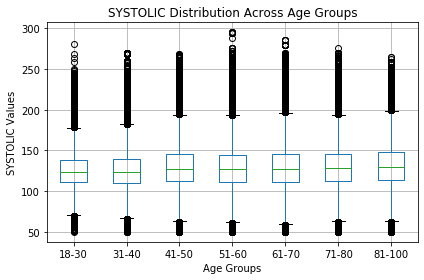

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Handle semicolon-separated 'SYSTOLIC' values by splitting and exploding them
df_['SYSTOLIC'] = df_['SYSTOLIC'].str.split(';')

# Explode the 'SYSTOLIC' column to create separate rows for each diastolic value
df_exploded = df_.explode('SYSTOLIC')

# 2. Convert 'SYSTOLIC' to numeric, forcing errors to NaN
df_exploded['SYSTOLIC'] = pd.to_numeric(df_exploded['SYSTOLIC'], errors='coerce')

# 3. Convert 'age' to numeric, forcing errors to NaN
df_exploded['age'] = pd.to_numeric(df_exploded['age'], errors='coerce')

# 4. Create age groups (bins)
age_bins = [18, 30, 40, 50, 60, 70, 80, 100]  # Define age group bins
age_labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-100']  # Labels for each bin

df_exploded['age_group'] = pd.cut(df_exploded['age'], bins=age_bins, labels=age_labels, right=False)

# 5. Boxplot: SYSTOLIC Values Distribution by Age Group
plt.figure(figsize=(10, 6))
df_exploded.boxplot(column='SYSTOLIC', by='age_group')

# Remove default title and add custom labels
plt.title('SYSTOLIC Distribution Across Age Groups')
plt.suptitle('')  # Remove default "Boxplot" title
plt.xlabel('Age Groups')
plt.ylabel('SYSTOLIC Values')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Bivariate Analysis
- Relationships between variables (both dependent and independent features)

### Correlation Analysis Between Numerical Features

**Note that before finding correlations, I calculated the mean Diastolic and Systolic for each encounter (row) in the table as each encounter had multiple diastolic/systolic values**

Below is an analysis of the correlations between various numerical features in the dataset. Here's an overview of the findings:

### Highest Correlations (Top 5)

1. **Correlation between `n_px` and `n_dx` = 75.16%**
   - This strong positive correlation suggests that as the number of procedures (`n_px`) increases, the number of diagnoses (`n_dx`) also tends to increase. This could be expected, as more diagnoses often lead to more procedures being performed on the patient.

2. **Correlation between `mean_diastolic` and `mean_systolic` = 62.19%**
   - The moderate correlation between diastolic and systolic blood pressures indicates that they are generally related. Higher systolic blood pressure tends to accompany higher diastolic pressure, which aligns with the physiological relationship between the two measurements.

3. **Correlation between `ADMIT_DURATION` and `n_px` = 59.53%**
   - There is a moderate positive correlation between the duration of hospital admission (`ADMIT_DURATION`) and the number of procedures (`n_px`). This suggests that patients who undergo more procedures tend to stay in the hospital for a longer duration, which is a reasonable assumption in many healthcare settings.

---

### Observations

- **High Correlation Between `n_px` and `n_dx`**: The 78.41% correlation between `n_px` (number of procedures) and `n_dx` (number of diagnoses) is quite strong. This suggests that the number of diagnoses and the number of procedures are closely related in this dataset. It might be worthwhile to investigate this relationship further to understand how these two factors influence each other.

- **Moderate Correlation Between Diastolic and Systolic Blood Pressure**: The 61.00% correlation between diastolic and systolic blood pressures is moderate. While both are related to heart health and tend to increase together, there are differences in how they are measured and what they represent, which is why the correlation is not perfect.

- **Moderate Correlation Between Length of Stay and Procedures**: The 62.88% correlation between `ADMIT_DURATION` (length of hospital stay) and `n_px` (number of procedures) suggests that longer hospital stays are often associated with patients who require more procedures. This is intuitive, as more complex or severe conditions might require more medical interventions.

---

#### Key Takeaways:
- Understanding these correlations can help in identifying patterns and making data-driven predictions about patient care requirements and hospital resource utilization.

In [10]:
numerical_cols = ['age', 'distance', 
                 'prior_IP_OS_ED_count', 
                  'days_since_prior_IP_OS_ED_patient_level_int', 
                  'n_dx', 'n_px', 
                  'ADMIT_DURATION',
                  'prior_other_encounter_types_count', 'days_since_prior_enc_patient_level',
                 'DIASTOLIC', 'SYSTOLIC']

df_num = df[numerical_cols].copy()
print(df_num.isna().sum())

age                                            0
distance                                       0
prior_IP_OS_ED_count                           0
days_since_prior_IP_OS_ED_patient_level_int    0
n_dx                                           0
n_px                                           0
ADMIT_DURATION                                 0
prior_other_encounter_types_count              0
days_since_prior_enc_patient_level             0
DIASTOLIC                                      0
SYSTOLIC                                       0
dtype: int64


   mean_diastolic  mean_systolic
0       81.111111     161.666667
1       87.500000     153.000000
2       72.636364     148.500000
3       63.484848     107.484848
4       65.123077     103.723077


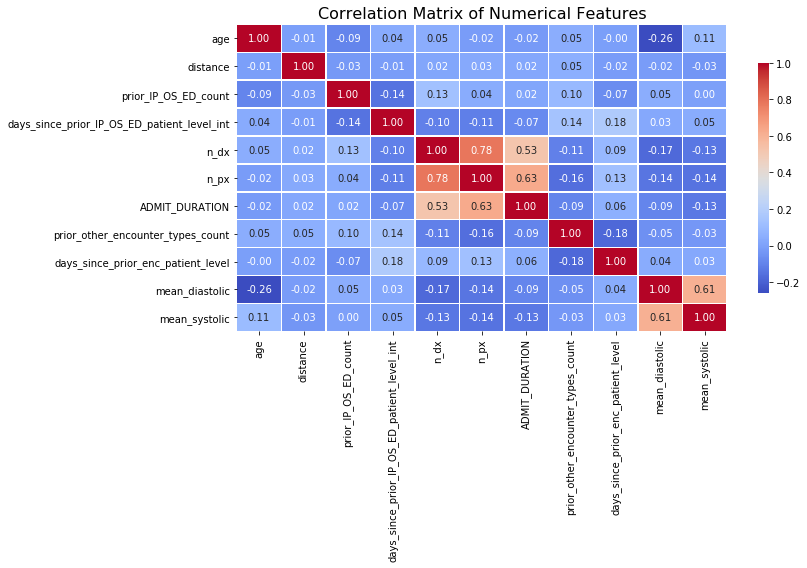

Correlation between n_px and n_dx = 78.41%
Correlation between n_dx and n_px = 78.41%
Correlation between n_px and ADMIT_DURATION = 62.88%
Correlation between ADMIT_DURATION and n_px = 62.88%
Correlation between mean_diastolic and mean_systolic = 61.00%


In [51]:
import pandas as pd
import numpy as np
import ast  # To safely evaluate string representations of lists
# Plotting the heatmap for the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert DIASTOLIC from string to list of floats
def convert_to_list(value):
    if isinstance(value, str) and ';' in value:
        # Convert semicolon-separated string to list of floats
        return [float(x) for x in value.split(';')]
    elif isinstance(value, list):
        # Ensure the value is a list of floats if it's already in list form
        return [float(x) for x in value]
    return []

# Function to compute the mean from the list
def compute_mean_from_list(value):
    if isinstance(value, list) and len(value) > 0:
        return np.mean(value)
    return np.nan  # Return NaN if list is empty or invalid

# Convert 'DIASTOLIC' and 'SYSTOLIC' columns to lists (if necessary)
df_num['DIASTOLIC'] = df_num['DIASTOLIC'].apply(convert_to_list)
df_num['SYSTOLIC'] = df_num['SYSTOLIC'].apply(convert_to_list)

# Calculate the mean of each list
df_num['mean_diastolic'] = df_num['DIASTOLIC'].apply(compute_mean_from_list)
df_num['mean_systolic'] = df_num['SYSTOLIC'].apply(compute_mean_from_list)

# Add the mean diastolic and systolic to the numerical columns
numerical_cols = ['age', 'distance', 'prior_IP_OS_ED_count', 
                  'days_since_prior_IP_OS_ED_patient_level_int', 'n_dx', 'n_px', 
                  'ADMIT_DURATION', 'prior_other_encounter_types_count', 
                  'days_since_prior_enc_patient_level', 'mean_diastolic', 'mean_systolic']

print(df_num[['mean_diastolic', 'mean_systolic']].head())

# Convert all numerical columns to numeric, forcing errors to NaN
df_num[numerical_cols] = df_num[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Compute the correlation matrix for numerical features
correlation_matrix = df_num[numerical_cols].corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.75})

# Set titles and labels
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# Set the diagonal to NaN to avoid self-correlations
np.fill_diagonal(correlation_matrix.values, np.nan)

# Convert the matrix to a long-form Series
correlation_series = correlation_matrix.stack()

# Sort the values based on absolute correlation values (use abs to get absolute values)
correlation_series = correlation_series.iloc[np.abs(correlation_series).argsort()[::-1]]

# Print the top 5 correlations (highest correlations)
top_5_corr = correlation_series.head(5)

# Print the results
for index, value in top_5_corr.items():
    feature1, feature2 = index
    corr_percentage = value * 100  # Convert the correlation to percentage
    print(f"Correlation between {feature1} and {feature2} = {corr_percentage:.2f}%")

## Strong Categorical Correlations (Cramér's V > 0.3) Between Features

Below are the strong correlations identified between categorical variables based on Cramér's V values, which suggest a moderate to strong association between the respective features:

### isMetropolitan and RUCA_CODE  
**Cramér's V = 0.7816**  
A very strong correlation exists between whether a location is metropolitan and the Rural-Urban Continuum Code (RUCA). This suggests that metropolitan areas tend to have a distinct RUCA classification compared to non-metropolitan areas.

### ENC_TYPE and Insulins  
**Cramér's V = 0.6590**  
There is a strong correlation between the type of encounter (e.g., inpatient, outpatient) and the use of insulins. This implies that certain encounter types, such as inpatient admissions, are more likely to involve insulin treatments, likely due to the higher incidence of diabetes or complications requiring insulin management in such settings.

### DISCHARGE_STATUS and Insulins  
**Cramér's V = 0.6357**  
Discharge status and the use of insulins show a strong correlation, indicating that patients who are discharged with insulin prescriptions may be dealing with diabetes or related conditions. This reflects the link between diabetes management and discharge outcomes.

### HISPANIC and RACE  
**Cramér's V = 0.6155**  
A strong correlation exists between Hispanic ethnicity and race, highlighting the relationship between these demographic categories. Ethnicity and race are often closely associated in health data, reflecting how certain racial and ethnic groups may overlap.

### ENC_TYPE and BETA BLOCKING AGENTS  
**Cramér's V = 0.5633**  
The type of encounter (e.g., emergency, outpatient) shows a strong correlation with the use of beta-blocking agents. This suggests that certain encounter types, particularly inpatient settings, may be more likely to involve the prescription of beta-blockers, which are commonly used to manage conditions like hypertension or heart disease.

### ENC_TYPE and LIPID MODIFYING AGENTS  
**Cramér's V = 0.5481**  
There is a strong correlation between the type of encounter and the use of lipid-modifying agents. This likely reflects the increased need for these medications in inpatient settings, where patients with cardiovascular risk factors may require more intensive treatment.

### ENC_TYPE and CORTICOSTEROIDS FOR SYSTEMIC USE  
**Cramér's V = 0.5411**  
The use of corticosteroids for systemic use is strongly correlated with encounter type. Patients who are hospitalized or encounter certain acute conditions may be more likely to receive corticosteroids for inflammation or immune system regulation.

### ENC_TYPE and DISCHARGE_STATUS  
**Cramér's V = 0.5306**  
There is a strong correlation between encounter type and discharge status, suggesting that different types of healthcare encounters (e.g., emergency, inpatient) are associated with distinct discharge outcomes, such as being sent home or transferred to another facility.

### ENC_TYPE and hypertension_complicated  
**Cramér's V = 0.5276**  
The type of encounter is strongly correlated with complicated hypertension, which may indicate that more severe or complicated cases of hypertension are more likely to be encountered in inpatient or emergency settings.

### ENC_TYPE and AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM  
**Cramér's V = 0.4523**  
A strong correlation is seen between encounter type and the use of agents acting on the renin-angiotensin system. These medications, which are commonly used for hypertension and heart failure, are more likely to be prescribed during inpatient encounters.

### DISCHARGE_STATUS and fluid_and_electrolyte_disorders  
**Cramér's V = 0.4457**  
Discharge status is strongly correlated with fluid and electrolyte disorders. Patients with these disorders may have more complex discharge plans, such as requiring follow-up care or specialized home monitoring.

### ENC_TYPE and CKD  
**Cramér's V = 0.3752**  
Chronic kidney disease (CKD) shows a moderate to strong correlation with encounter type. Patients with CKD are likely to have more frequent hospital encounters, especially in more severe stages of the disease.

### ENC_TYPE and ANTIHYPERTENSIVES  
**Cramér's V = 0.3680**  
The use of antihypertensives is moderately correlated with encounter type. This suggests that patients in inpatient or emergency settings may have more complex hypertension that requires medication management.

### ENC_TYPE and chronic_pulmonary_disease  
**Cramér's V = 0.3509**  
Encounter type and chronic pulmonary disease (e.g., COPD) show a moderate correlation. Patients with chronic pulmonary conditions may be more likely to be encountered in inpatient or emergency settings due to exacerbations or complications.

### DISCHARGE_STATUS and weight_loss  
**Cramér's V = 0.3475**  
Weight loss and discharge status are moderately correlated, suggesting that patients who experience significant weight loss (often a sign of malnutrition or chronic illness) may have more complex discharge planning, potentially requiring rehabilitation or specialized follow-up care.

### ENC_TYPE and congestive_heart_failure  
**Cramér's V = 0.3374**  
There is a moderate correlation between encounter type and congestive heart failure (CHF). Hospitalized patients with CHF are likely to have more severe manifestations of the disease, leading to increased healthcare encounters.

### DISCHARGE_STATUS and BETA BLOCKING AGENTS  
**Cramér's V = 0.5385**  
A strong correlation exists between discharge status and beta-blocking agents, with patients discharged from the hospital more likely to have prescriptions for beta-blockers, often used in managing heart disease or hypertension.

### DISCHARGE_STATUS and LIPID MODIFYING AGENTS  
**Cramér's V = 0.5176**  
Discharge status is also strongly correlated with the use of lipid-modifying agents. This indicates that patients who are discharged following cardiovascular events may be prescribed these medications to manage cholesterol levels and reduce future risk.

### DISCHARGE_STATUS and CORTICOSTEROIDS FOR SYSTEMIC USE  
**Cramér's V = 0.4974**  
Discharge status and corticosteroids for systemic use are moderately to strongly correlated, likely due to the need for corticosteroid therapy in patients discharged with inflammatory or autoimmune conditions.

### DISCHARGE_STATUS and hypertension_complicated  
**Cramér's V = 0.4974**  
Complicated hypertension and discharge status are strongly correlated. Patients with severe hypertension may require specialized discharge planning, including medications and follow-up care.

### ENC_TYPE and fluid_and_electrolyte_disorders  
**Cramér's V = 0.4841**  
Fluid and electrolyte disorders show a strong correlation with encounter type. These disorders are more commonly managed in inpatient settings, especially when patients require intravenous fluids or other intensive treatments.

### DISCHARGE_STATUS and AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM  
**Cramér's V = 0.4272**  
Discharge status and the use of agents acting on the renin-angiotensin system show a moderate to strong correlation, suggesting that these medications are often prescribed at discharge for patients with hypertension or heart failure.

### DISCHARGE_STATUS and CKD  
**Cramér's V = 0.3600**  
Chronic kidney disease and discharge status are moderately correlated. Patients with CKD may have specific discharge needs, such as dialysis or specialized care, influencing their discharge plans.

### DISCHARGE_STATUS and ANTIHYPERTENSIVES  
**Cramér's V = 0.3460**  
There is a moderate correlation between discharge status and antihypertensives, which may be prescribed at discharge to manage blood pressure in patients who were hospitalized for hypertension-related complications. 

### ENC_TYPE and weight_loss  
**Cramér's V = 0.3384**  
A moderate correlation exists between encounter type and weight loss, suggesting that patients who lose significant weight may have encounters in inpatient settings, such as for treatment of underlying conditions like cancer or severe malnutrition.

### DISCHARGE_STATUS and chronic_pulmonary_disease  
**Cramér's V = 0.3241**  
Discharge status and chronic pulmonary disease (e.g., COPD) show a moderate correlation, indicating that patients with these conditions may have different discharge outcomes depending on the severity of their disease and the need for ongoing care.

### DISCHARGE_STATUS and congestive_heart_failure  
**Cramér's V = 0.3209**  
Congestive heart failure and discharge status are moderately correlated, with patients who have CHF often requiring specialized discharge care, such as medications or rehabilitation.

---

These correlations reflect meaningful relationships between different clinical and demographic factors. Understanding these associations is critical for healthcare providers when making decisions regarding patient management, discharge planning, and medication prescriptions.

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency


# 4. Function to calculate Cramér's V for categorical variables
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# 5. Calculate Cramér's V correlations between all categorical features (including Elixhauser comorbidities)
categorical_correlations = {}

# Loop over each pair of categorical columns
for col1 in df_[all_categorical_cols]:
    for col2 in df_[all_categorical_cols]:
        if col1 != col2 and (col2, col1) not in categorical_correlations:
            contingency_table = pd.crosstab(df_[col1], df_[col2])
            cramer_v_value = cramers_v(contingency_table)
            categorical_correlations[(col1, col2)] = cramer_v_value

# 6. Sort and display the correlations in descending order
sorted_categorical_correlations = dict(sorted(categorical_correlations.items(), key=lambda item: item[1], reverse=True))

# Display the top correlations
for (col1, col2), value in sorted_categorical_correlations.items():
    print(f"Correlation between '{col1}' and '{col2}': Cramér's V = {value:.4f}")

# 7. Filter for strong correlations (Cramér's V > 0.2)
strong_correlations = {key: val for key, val in sorted_categorical_correlations.items() if val > 0.2}

# Display strong correlations
print("\nStrong correlations (Cramér's V > 0.2):")
for (col1, col2), value in strong_correlations.items():
    print(f"Correlation between '{col1}' and '{col2}': Cramér's V = {value:.4f}")

/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Correlation between 'isMetropolitan' and 'RUCA_CODE': Cramér's V = 0.7816
Correlation between 'ENC_TYPE' and 'Insulins': Cramér's V = 0.6590
Correlation between 'ENC_TYPE' and 'Sulfonamides (heterocyclic)': Cramér's V = nan
Correlation between 'ENC_TYPE' and 'Aldose reductase inhibitors': Cramér's V = nan
Correlation between 'DISCHARGE_STATUS' and 'Insulins': Cramér's V = 0.6357
Correlation between 'HISPANIC' and 'RACE': Cramér's V = 0.6155
Correlation between 'ENC_TYPE' and 'BETA BLOCKING AGENTS': Cramér's V = 0.5633
Correlation between 'ENC_TYPE' and 'LIPID MODIFYING AGENTS': Cramér's V = 0.5481
Correlation between 'ENC_TYPE' and 'CORTICOSTEROIDS FOR SYSTEMIC USE': Cramér's V = 0.5411
Correlation between 'ENC_TYPE' and 'DISCHARGE_STATUS': Cramér's V = 0.5306
Correlation between 'ENC_TYPE' and 'hypertension_complicated': Cramér's V = 0.5276
Correlation between 'ENC_TYPE' and 'AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM': Cramér's V = 0.4523
Correlation between 'DISCHARGE_STATUS' and

#### Interpret what ENC_TYPE Correlaions are Because Several Values for this Feature

Insulins      0      1
ENC_TYPE              
AV_TH     96065  20141
CLPSED    53808  13158
ED         2603   3720
IP         5186  54340
OS         1899  10080


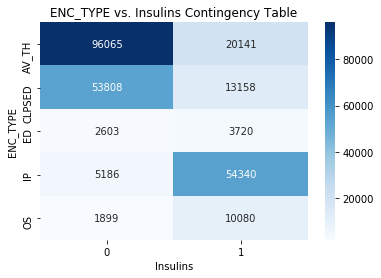

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

contingency_table = pd.crosstab(df_['ENC_TYPE'], df_['Insulins'])
print(contingency_table)


# Heatmap of the contingency table
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='d')
plt.title('ENC_TYPE vs. Insulins Contingency Table')
plt.show()

Insulins               0      1
DISCHARGE_STATUS               
AM                   607   2922
CLPSED            150049  35618
HH                  1839  21964
HO                  6231  31380
SN_RH                835   9555


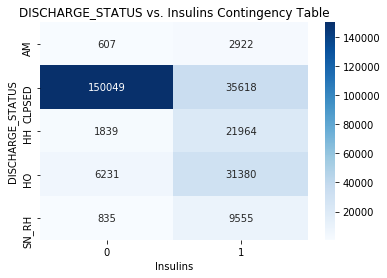

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

contingency_table = pd.crosstab(df_['DISCHARGE_STATUS'], df_['Insulins'])
print(contingency_table)


# Heatmap of the contingency table
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='d')
plt.title('DISCHARGE_STATUS vs. Insulins Contingency Table')
plt.show()

RACE      01_02_04      03     05  CLPSED
HISPANIC                                 
CLPSED          70    2151    747    1984
N             3540  130625  40742    7008
Y              415    2192   3236   68290


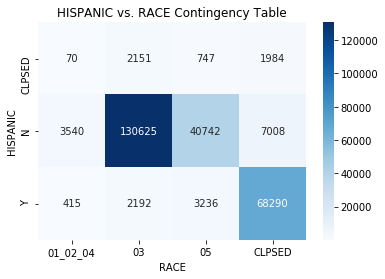

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

contingency_table = pd.crosstab(df_['HISPANIC'], df_['RACE'])
print(contingency_table)


# Heatmap of the contingency table
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='d')
plt.title('HISPANIC vs. RACE Contingency Table')
plt.show()

In [54]:
# Display the top correlations

# 7. Filter for strong correlations (Cramér's V > 0.3)
strong_correlations = {key: val for key, val in sorted_categorical_correlations.items() if val > 0.3}

# Display strong correlations
print("\nStrong correlations (Cramér's V > 0.3):")
for (col1, col2), value in strong_correlations.items():
    print(f"Correlation between '{col1}' and '{col2}': Cramér's V = {value:.4f}")


Strong correlations (Cramér's V > 0.3):
Correlation between 'isMetropolitan' and 'RUCA_CODE': Cramér's V = 0.7816
Correlation between 'ENC_TYPE' and 'Insulins': Cramér's V = 0.6590
Correlation between 'DISCHARGE_STATUS' and 'Insulins': Cramér's V = 0.6357
Correlation between 'HISPANIC' and 'RACE': Cramér's V = 0.6155
Correlation between 'ENC_TYPE' and 'BETA BLOCKING AGENTS': Cramér's V = 0.5633
Correlation between 'ENC_TYPE' and 'LIPID MODIFYING AGENTS': Cramér's V = 0.5481
Correlation between 'ENC_TYPE' and 'CORTICOSTEROIDS FOR SYSTEMIC USE': Cramér's V = 0.5411
Correlation between 'ENC_TYPE' and 'DISCHARGE_STATUS': Cramér's V = 0.5306
Correlation between 'ENC_TYPE' and 'hypertension_complicated': Cramér's V = 0.5276
Correlation between 'ENC_TYPE' and 'AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM': Cramér's V = 0.4523
Correlation between 'DISCHARGE_STATUS' and 'fluid_and_electrolyte_disorders': Cramér's V = 0.4457
Correlation between 'ENC_TYPE' and 'CKD': Cramér's V = 0.3752
Correla

### Lastly, I will analyze correlations between each feature and the target value - readmission

### Correlations Between Numerical Features and Readmission

Below are the correlations between the numerical features (including diastolic and systolic values) and the `readmission` variable:


| Feature                                       | Correlation with Readmission|
|-----------------------------------------------|-----------------------------|
| Age                                           | -2.72%                      |
| Distance                                      | 0.37%                       |
| Prior IP/OS/ED Count                          | 17.17%                      |
| Days Since Prior IP/OS/ED Patient Level Int   | -12.73%                     |
| n_dx                                          | 34.92%                      |
| n_px                                          | 26.38%                      |
| Admit Duration                                | 21.58%                      |
| Prior Other Encounter Types Count             | -4.97%                      |
| Days Since Prior Encounter Patient Level      | -6.09%                      |
| Mean Diastolic                                | -5.67%                      |
| Mean Systolic                                 | -7.37%                      |

---

### Observations:

1. **Strong Correlation Between n_dx and Readmission**:
   - The number of diagnoses (`n_dx`) has a moderate positive correlation (34.92%) with readmission, indicating that patients with more diagnoses are more likely to be readmitted.

2. **Moderate Correlation Between n_px and Readmission**:
   - The number of procedures (`n_px`) shows a moderate positive correlation (26.38%) with readmission. This suggests that patients who undergo more procedures are at a higher risk of readmission.

3. **Admit Duration Correlation**:
   - The admission duration (`ADMIT_DURATION`) shows a positive correlation (21.58%) with readmission, indicating that longer stays in the hospital may be associated with a higher likelihood of readmission.

4. **Blood Pressure (Diastolic and Systolic)**:
   - **Mean Diastolic** (-5.67%) and **Mean Systolic** (-7.37%) show weak negative correlations with readmission. This suggests that, in this dataset, lower blood pressure may be slightly associated with a higher chance of readmission, although the correlation is not strong.

5. **Age and Distance**:
   - Both **Age** (-2.72%) and **Distance** (0.37%) have weak correlations with readmission, implying that the patient's age and the distance they live from the hospital do not have a significant impact on readmission.

6. **Other Features**:
   - **Prior IP/OS/ED Count** (17.17%) and **Days Since Prior IP/OS/ED Patient Level Int** (-12.73%) show relatively weak correlations with readmission, suggesting that the number of prior encounters and time since the last encounter play a minor role in the likelihood of readmission.

These correlations help to identify factors that influence readmission risk. Features like **number of diagnoses**, **number of procedures**, and **admission duration** show moderate positive correlations, while **blood pressure** and other features exhibit weaker correlations, suggesting that further analysis may be needed to understand these relationships better.




### Correlations Between Categorical Features and Readmission

Below are the correlations between the categorical features and the `readmission` variable, measured using Cramér's V. This statistic provides a measure of association between categorical variables, with values closer to 1 indicating a stronger association:

| Feature                                      | Cramér's V with Readmission |
|----------------------------------------------|-----------------------------|
| **ENC_TYPE**                                 | 0.3987                      |
| **DISCHARGE_STATUS**                         | 0.3414                      |
| **SEX**                                      | 0.0297                      |
| **HISPANIC**                                 | 0.0232                      |
| **RACE**                                     | 0.0185                      |
| **TOBACCO**                                  | 0.0567                      |
| **SDI_quantile**                             | 0.0239                      |
| **isMetropolitan**                           | 0.0069                      |
| **CKD**                                      | 0.2770                      |
| **BMI**                                      | 0.1122                      |
| **RUCA_CODE**                                | 0.0147                      |
| **Insulins**                                 | 0.2556                      |
| **Glucagon-like peptide-1 (GLP-1) analogues**| 0.0008                      |
| **Biguanides**                               | 0.0375                      |
| **Sulfonylureas**                            | 0.0324                      |
| **Sulfonamides (heterocyclic)**              | NaN                         |
| **Alpha glucosidase inhibitors**             | 0.0008                      |
| **Thiazolidinediones**                       | 0.0003                      |
| **Dipeptidyl peptidase 4 (DPP-4) inhibitors**| 0.0348                      |
| **Sodium-glucose co-transporter 2 (SGLT2) inhibitors**| 0.0034                |
| **Other blood glucose lowering drugs, excl. insulins**| 0.0121            |
| **Aldose reductase inhibitors**              | NaN                         |
| **AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM**| 0.1723                    |
| **ANTIHYPERTENSIVES**                        | 0.2267                      |
| **BETA BLOCKING AGENTS**                     | 0.2593                      |
| **CORTICOSTEROIDS FOR SYSTEMIC USE**         | 0.2887                      |
| **LIPID MODIFYING AGENTS**                   | 0.2030                      |
| **Congestive Heart Failure**                 | 0.1638                      |
| **Cardiac Arrhythmia**                       | 0.1255                      |
| **Valvular Disease**                         | 0.0499                      |
| **Pulmonary Circulation Disorder**           | 0.0853                      |
| **Peripheral Vascular Disorder**             | 0.0778                      |
| **Hypertension Uncomplicated**               | 0.0255                      |
| **Hypertension Complicated**                 | 0.2344                      |
| **Paralysis**                                | 0.0386                      |
| **Other Neurological Disorder**              | 0.1202                      |
| **Chronic Pulmonary Disease**                | 0.1474                      |
| **Diabetes Uncomplicated**                   | 0.0665                      |
| **Diabetes Complicated**                     | 0.0141                      |
| **Hypothyroidism**                           | 0.0389                      |
| **Renal Failure**                            | 0.1295                      |
| **Liver Disease**                            | 0.0886                      |
| **Peptic Ulcer Disease (Excluding Bleeding)**| 0.0309                      |
| **AIDS/HIV**                                 | 0.0157                      |
| **Lymphoma**                                 | 0.0272                      |
| **Metastatic Cancer**                        | 0.0607                      |
| **Solid Tumor without Metastasis**           | 0.0500                      |
| **Rheumatoid Arthritis**                     | 0.0366                      |
| **Coagulopathy**                             | 0.0966                      |
| **Obesity**                                  | 0.0600                      |
| **Weight Loss**                              | 0.1829                      |
| **Fluid and Electrolyte Disorders**          | 0.2181                      |
| **Blood Loss Anemia**                        | 0.0312                      |
| **Deficiency Anemia**                        | 0.0846                      |
| **Alcohol Abuse**                            | 0.0756                      |
| **Drug Abuse**                               | 0.1261                      |
| **Psychoses**                                | 0.0813                      |
| **Depression**                               | 0.1063                      |

---

### Analysis:

- **Strong correlations** (Cramér's V > 0.3):
  - **ENC_TYPE** (0.3987) and **DISCHARGE_STATUS** (0.3414) show strong correlations with **readmission**. This suggests that the type of encounter (e.g., inpatient vs. outpatient) and the patient's discharge status (e.g., alive, transferred, expired) are significant factors in determining the likelihood of readmission.
  - **CORTICOSTEROIDS FOR SYSTEMIC USE** (0.2887) and **BETA BLOCKING AGENTS** (0.2593) are also strongly correlated, indicating that certain medications may be linked to a higher risk of readmission.

- **Moderate correlations** (Cramér's V between 0.2 and 0.3):
  - **CKD** (0.2770), **Insulins** (0.2556), and **ANTIHYPERTENSIVES** (0.2267) show moderate correlations with readmission. This suggests that conditions like chronic kidney disease and the use of medications such as insulin and antihypertensives may increase the likelihood of readmission.
  - **Fluid and Electrolyte Disorders** (0.2181) and **Weight Loss** (0.1829) also have moderate associations, suggesting that these health conditions are important considerations for readmission risk.

- **Weaker correlations** (Cramér's V < 0.1):
  - Several features such as **SEX** (0.0297), **HISPANIC** (0.0232), and **RACE** (0.0185) show very weak correlations with readmission. This implies that these factors have minimal influence on readmission outcomes in this dataset.
  - **Glucagon-like peptide-1 (GLP-1) analogues** (0.0008) and **Thiazolidinediones** (0.0003) show very weak or negligible correlations with readmission.

- **Other observations**:
  - Medications like **Sodium-glucose co-transporter 2 (SGLT2) inhibitors** (0.0034) and **Dipeptidyl peptidase 4 (DPP-4) inhibitors** (0.0348) show weak correlations, suggesting that their use may have some relationship with readmission, but further analysis is required.
  - **Hypertension Complicated** (0.2344) shows a moderate association, highlighting the role of hypertension severity in influencing readmission risk.

### Conclusion:
The most significant predictors of readmission from the categorical features are **ENC_TYPE** and **DISCHARGE_STATUS**, indicating that the type of encounter and the discharge status of patients are crucial in predicting readmission likelihood. Medications such as **Corticosteroids**, **Beta-blocking agents**, and **Insulin use** also show moderate associations with readmission, while health conditions like **CKD**, **Hypertension**, and **Obesity** are notable factors in the risk of readmission.




In [11]:
# Convert readmission from string to numeric
df_['readmission'] = pd.to_numeric(df_['readmission'], errors='coerce')
print(df_['readmission'].value_counts())

df_num['readmission'] = pd.to_numeric(df_['readmission'], errors='coerce')
print(df_['readmission'].value_counts())

0    249291
1     11709
Name: readmission, dtype: int64
0    249291
1     11709
Name: readmission, dtype: int64


In [57]:
# List of numerical features
numerical_features = ['age', 'distance', 'prior_IP_OS_ED_count', 
                      'days_since_prior_IP_OS_ED_patient_level_int', 'n_dx', 'n_px', 
                      'ADMIT_DURATION', 'prior_other_encounter_types_count', 
                      'days_since_prior_enc_patient_level', 'mean_diastolic', 'mean_systolic']

# Calculate Pearson correlation with readmission (assuming readmission is now numeric)
correlation_numerical = {}
for feature in numerical_features:
    correlation_numerical[feature] = df_num[feature].corr(df_num['readmission'])

# Convert dictionary to DataFrame for better readability
correlation_numerical_df = pd.DataFrame(correlation_numerical.items(), columns=['Feature', 'Correlation with Readmission'])

# Display the correlation
print(correlation_numerical_df)


                                        Feature  Correlation with Readmission
0                                           age                     -0.027165
1                                      distance                      0.003711
2                          prior_IP_OS_ED_count                      0.171703
3   days_since_prior_IP_OS_ED_patient_level_int                     -0.127291
4                                          n_dx                      0.349162
5                                          n_px                      0.263812
6                                ADMIT_DURATION                      0.215783
7             prior_other_encounter_types_count                     -0.049677
8            days_since_prior_enc_patient_level                     -0.060912
9                                mean_diastolic                     -0.056660
10                                mean_systolic                     -0.073697


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Function to compute Cramér's V
def cramers_v(x, y):
    # Compute the confusion matrix
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, ex = chi2_contingency(confusion_matrix)
    
    # Calculate Cramér's V
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Calculate Cramér's V for each categorical feature with readmission
cramers_v_categorical = {}
for feature in df_[all_categorical_cols]:
    cramers_v_categorical[feature] = cramers_v(df_[feature], df_['readmission'])

# Convert dictionary to DataFrame for better readability
cramers_v_df = pd.DataFrame(cramers_v_categorical.items(), columns=['Feature', 'Cramér\'s V with Readmission'])

# Display the Cramér's V values
display(cramers_v_df)


/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


,Feature,Cramér's V with Readmission
0,ENC_TYPE,0.398715
1,DISCHARGE_STATUS,0.341446
2,SEX,0.029660
3,HISPANIC,0.023195
4,RACE,0.018528
5,TOBACCO,0.056662
6,SDI_quantile,0.023865
7,isMetropolitan,0.006906
8,CKD,0.277021
9,BMI,0.112242


readmission       0      1
ENC_TYPE                  
AV_TH        116206      0
CLPSED        66966      0
ED             6323      0
IP            47817  11709
OS            11979      0


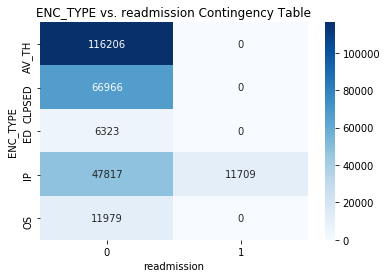

In [18]:
contingency_table = pd.crosstab(df_['ENC_TYPE'], df_['readmission'])
print(contingency_table)

import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of the contingency table
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='d')
plt.title('ENC_TYPE vs. readmission Contingency Table')
plt.show()


# Feature Engineering

## 1. Creating One-Hot-Encodings for Categorical Features
## 2. Normalizing Numerical Features

### One Hot Encodings for Categorical Features

In [4]:
columns = ['ENC_TYPE', 'DISCHARGE_STATUS', 'SEX', 'HISPANIC', 'RACE', 'TOBACCO', 'SDI_quantile', 'CKD', 'BMI', 'isMetropolitan', 'RUCA_CODE']

# Iterate through each column and print unique values
for col in columns:
    unique_values = df[col].unique()
    print(f"Unique values for '{col}': {unique_values}")


Unique values for 'ENC_TYPE': ['OS' 'AV_TH' 'IP' 'CLPSED' 'ED']
Unique values for 'DISCHARGE_STATUS': ['HO' 'CLPSED' 'HH' 'SN_RH' 'AM']
Unique values for 'SEX': ['F' 'M']
Unique values for 'HISPANIC': ['N' 'Y' 'CLPSED']
Unique values for 'RACE': ['03' '05' 'CLPSED' '01_02_04']
Unique values for 'TOBACCO': ['02' '03' '01' 'CLPSED']
Unique values for 'SDI_quantile': ['1' '3' '0' '4' '2']
Unique values for 'CKD': ['2' '0' '3' '4' '5' '1']
Unique values for 'BMI': ['30.0+' '25.0 – 29.9' '18.5 – 24.9' 'CLPSED' '<18.5']
Unique values for 'isMetropolitan': ['1.0' 'CLPSED' '0.0']
Unique values for 'RUCA_CODE': ['1.0' '2.0' '3+' 'CLPSED']


In [6]:
# Check for missing values in categorical columns
missing_values = df[columns].isna().sum()
print("Missing values in categorical columns:\n", missing_values)

print(df[columns].dtypes)

Missing values in categorical columns:
 ENC_TYPE            0
DISCHARGE_STATUS    0
SEX                 0
HISPANIC            0
RACE                0
TOBACCO             0
SDI_quantile        0
CKD                 0
BMI                 0
isMetropolitan      0
RUCA_CODE           0
dtype: int64
ENC_TYPE            object
DISCHARGE_STATUS    object
SEX                 object
HISPANIC            object
RACE                object
TOBACCO             object
SDI_quantile        object
CKD                 object
BMI                 object
isMetropolitan      object
RUCA_CODE           object
dtype: object


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# Define categories
categories = {
    'ENC_TYPE': ['ED', 'OS', 'AV_TH', 'IP', 'CLPSED'],
    'DISCHARGE_STATUS': ['HO', 'HH', 'SN_RH', 'AM', 'CLPSED'],
    'SEX': ['F', 'M'],
    'HISPANIC': ['N', 'Y', 'CLPSED'],
    'RACE': ['01_02_04', '03', '05', 'CLPSED'],
    'TOBACCO': ['01', '02', '03', 'CLPSED'],   
    'SDI_quantile': ['0', '1', '2', '3', '4'],           
    'isMetropolitan': ['0.0', '1.0', 'CLPSED'],
    'CKD': ['0', '1', '2', '3', '4', '5'],              
    'BMI': ['<18.5', '18.5 – 24.9', '25.0 – 29.9', '30.0+', 'CLPSED'],
    'RUCA_CODE': ['1.0', '2.0', '3+', 'CLPSED']
}


# Create a dummy DataFrame with one sample for each category
dummy_data = {col: [categories[col][0]] for col in categories.keys()}
dummy_df = pd.DataFrame(dummy_data)

# Create OneHotEncoder with specified categories
encoder = OneHotEncoder(categories=[categories[col] for col in categories.keys()], sparse=False, handle_unknown='ignore')

# Fit encoder on the dummy data
encoder.fit(dummy_df)

def encode_site(df):
    # Identify and subset categorical columns
    categorical_columns = [col for col in df.columns if col in categories]
    
    # Fill missing values in categorical columns
    for col in categorical_columns:
        df[col] = df[col].fillna('CLPSED')
    
    # Ensure all categorical columns are treated as categorical with specified categories
    for feature, cats in categories.items():
        df[feature] = pd.Categorical(df[feature], categories=cats)
    
    # Apply one-hot encoding
    encoded_array = encoder.transform(df[categorical_columns])
    
    # Convert the encoded array to a DataFrame with appropriate column names
    feature_names = encoder.get_feature_names_out() if hasattr(encoder, 'get_feature_names_out') else encoder.get_feature_names()
    encoded_df = pd.DataFrame(encoded_array, columns=feature_names)
    
    # Map feature names to categories to make it clearer
    feature_name_mapping = {}
    for feature in categories.keys():
        for category in categories[feature]:
            feature_name_mapping[f"x{list(categories.keys()).index(feature)}_{category}"] = f"{feature}_{category}"

    # Rename columns in encoded_df to match the feature names
    encoded_df = encoded_df.rename(columns=feature_name_mapping)
    
    # Concatenate the one-hot encoded columns back into a single column per feature
    concatenated_features = {}
    for feature in categories.keys():
        cols_to_concat = [f"{feature}_{category}" for category in categories[feature]]
        concatenated_features[feature] = encoded_df[cols_to_concat].astype(int).astype(str).apply(lambda row: ';'.join(row), axis=1)
    
    # Drop original categorical columns and add the concatenated ones
#     df = df.drop(columns=categorical_columns)
    df.reset_index(drop=True, inplace=True)
    encoded_df.reset_index(drop=True, inplace=True)
    df_encoded = pd.concat([df, encoded_df], axis=1)
    
    return df_encoded

# Encode site
df_encoded = encode_site(df.copy())

print(df_encoded.shape)
display(df_encoded.head(5))

(261000, 95)


,ENCOUNTERID,PATID,ADMIT_DATETIME,DISCHARGE_DATETIME,ENC_TYPE,DISCHARGE_STATUS,DX_codes,SEX,HISPANIC,RACE,...,CKD_5,BMI_<18.5,BMI_18.5 – 24.9,BMI_25.0 – 29.9,BMI_30.0+,BMI_CLPSED,RUCA_CODE_1.0,RUCA_CODE_2.0,RUCA_CODE_3+,RUCA_CODE_CLPSED
0,TEMPLE63025039,700000015,2018-06-12,2018-06-12,OS,HO,R6884;R079;Z6838;E785;Z7982;Z7984;E119;K219;I1...,F,N,03,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,TEMPLE93601259,700000015,2020-02-19,2020-02-19,AV_TH,CLPSED,E119;Z1211;K219,F,N,03,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,TEMPLE58999755,700000015,2022-08-26,2022-08-29,IP,HO,N3090;E876;R7881;N179;N3000;Z7982;I2510;E785;Z...,F,N,03,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,TEMPLE89592217,700000021,2017-02-15,2017-02-19,IP,HH,C671;R351;Z125;N179;L89629;Z809;Z8249;R251;D63...,M,N,03,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,TEMPLE63296416,700000021,2017-04-15,2017-04-25,IP,HH,I5023;Z7902;Z91119;Z95810;Z794;F5089;Z809;Z824...,M,N,03,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [8]:
for col in df_encoded.columns:
    print(col)


ENCOUNTERID
PATID
ADMIT_DATETIME
DISCHARGE_DATETIME
ENC_TYPE
DISCHARGE_STATUS
DX_codes
SEX
HISPANIC
RACE
loincs_results_modifier_unit
DIASTOLIC
SYSTOLIC
TOBACCO
RXNORM_CUI
age
distance
SDI_quantile
ELIXHAUSER
DX_CCS_codes
PX_CCS
n_dx
n_px
readmission
ADMIT_DURATION
prior_IP_OS_ED_count
days_since_prior_IP_OS_ED_patient_level_int
isMetropolitan
CKD
BMI
prior_other_encounter_types_count
RUCA_CODE
days_since_prior_enc_patient_level
Insulins
Glucagon-like peptide-1 (GLP-1) analogues
Biguanides
Sulfonylureas
Sulfonamides (heterocyclic)
Alpha glucosidase inhibitors
Thiazolidinediones
Dipeptidyl peptidase 4 (DPP-4) inhibitors
Sodium-glucose co-transporter 2 (SGLT2) inhibitors
Other blood glucose lowering drugs, excl. insulins
Aldose reductase inhibitors
AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM
ANTIHYPERTENSIVES
BETA BLOCKING AGENTS
CORTICOSTEROIDS FOR SYSTEMIC USE
LIPID MODIFYING AGENTS
ENC_TYPE_ED
ENC_TYPE_OS
ENC_TYPE_AV_TH
ENC_TYPE_IP
ENC_TYPE_CLPSED
DISCHARGE_STATUS_HO
DISCHARGE_STATU

In [9]:
print(df_encoded.shape)

(261000, 95)


In [10]:
df = df_encoded.copy()

### Normalize Numerical Features

### First, use Min-Max Normalization on Diastolic and Systolic Features 
- These features must be treated differently than other continuous features since these features might have multiple values stored as a semicolon-separated string (e.g., "80;85;90"). For each encounter, the code calculates the min, max, and mean of the diastolic values within that encounter.
- Normalization: These values are then normalized using the global min and max values from the entire dataset, ensuring that each encounter's diastolic values are scaled according to the range of values across all encounters.
- Storage: The normalized values (min, max, mean) are stored back into the column in a semicolon-separated string format.

In [11]:
# Normalize DIASTOLIC using Mean 
# min max

df['DIASTOLIC'] = df['DIASTOLIC'].fillna(-1)
diastolic_vals = []
mean_vals = []

for indx, row in df.iterrows():
    
    if row['DIASTOLIC'] == -1: diastolic_vals.append(-1)
    else:
        dt_ = str(row['DIASTOLIC']).split(';') # Convert to string and split using ;
        dt_ = list(map(float, dt_)) # Convert each element to a floating point number and create a new list
        for i in dt_: diastolic_vals.append(i) # Append each element in dt_ list to create a flat list
        for i in dt_: mean_vals.append( np.mean(dt_) ) # Calculate mean of whole list and append (same) mean value for all elements in dt_
    
# -----
# Convert diastolic_vals to np array
diastolic_vals = np.asarray(diastolic_vals, dtype=float)
min_d = np.min(diastolic_vals) # find min
max_d = np.max(diastolic_vals) # find max

# find min and max mean values for mean vals
min_mean = np.min(mean_vals)
max_mean = np.max(mean_vals)

# NORMALIZE
for indx, row in df.iterrows():
    
    if row['DIASTOLIC'] == -1: # if current row equals -1, normalize
        min_norm = normalize(min_d, max_d, -1)
        max_norm = normalize(min_d, max_d, -1)
        mean_norm = normalize(min_mean, max_mean, -1)
        
    else:
        dt_ = str(row['DIASTOLIC']).split(';') 
        
        while 'nan' in dt_: # replace nan values with -1
            dt_[ dt_.index('nan') ] = -1
            
        dt_ = list(map(float, dt_)) # convert string values to float
        
        dt_ = np.asarray(dt_, dtype=float) # convert dt_ to numpy array
        
        min_norm = normalize(min_d, max_d, np.min(dt_))
        max_norm = normalize(min_d, max_d, np.max(dt_))
        mean_norm = normalize(min_mean, max_mean, np.mean(dt_))
        
    df.at[indx, 'DIASTOLIC'] = ';'.join([str(min_norm), str(max_norm), str(mean_norm)]) # normalized values are joined back to Diastolic column
    
    
print("cleaning up...")
del diastolic_vals
del min_d
del max_d
del mean_norm

cleaning up...


In [12]:
display(df['DIASTOLIC'].head(20))

0      0.345;0.47;0.39531368102796677
1       0.44;0.445;0.4387755102040816
2       0.31;0.45;0.33766233766233766
3      0.205;0.36;0.27540713254998966
4      0.285;0.42;0.28655154369440083
5         0.32;0.32;0.272108843537415
6       0.33;0.555;0.4750752760120442
7        0.355;0.6;0.4107643057222889
8       0.265;0.49;0.3447971781305115
9        0.0;0.0;-0.16326530612244897
10      0.295;0.42;0.3327664399092971
11       0.33;0.33;0.2857142857142857
12       0.35;0.35;0.3129251700680272
13      0.36;0.36;0.32653061224489793
14       0.0;0.0;-0.16326530612244897
15       0.0;0.0;-0.16326530612244897
16       0.3;0.445;0.3169512703040399
17    0.305;0.305;0.25170068027210885
18     0.335;0.335;0.2925170068027211
19      0.24;0.24;0.16326530612244897
Name: DIASTOLIC, dtype: object

In [13]:
# Normalize SYSTOLIC using mean 
# min max

df['SYSTOLIC'] = df['SYSTOLIC'].fillna(-1)
systolic_vals = []
mean_vals = []

for indx, row in df.iterrows():
    
    if row['SYSTOLIC'] == -1: systolic_vals.append(-1)
    else:
        st_ = str(row['SYSTOLIC']).split(';')
        st_ = list(map(float, st_))
        for i in st_: systolic_vals.append(i)
        for i in dt_: mean_vals.append( np.mean(st_) )
    
# -----

systolic_vals = np.asarray(systolic_vals, dtype=float)
min_s = np.min(systolic_vals)
max_s = np.max(systolic_vals)
    
min_mean = np.min(mean_vals)
max_mean = np.max(mean_vals)

for indx, row in df.iterrows():
    
    if row['SYSTOLIC'] == -1: 
        min_norm = normalize(min_s, max_s, -1)
        max_norm = normalize(min_s, max_s, -1)
        mean_norm = normalize(min_mean, max_mean, -1)
        
    else:
        st_ = str(row['SYSTOLIC']).split(';')
        
        while 'nan' in st_:
            st_[ st_.index('nan') ] = -1
            
        st_ = list(map(float, st_))
        
        st_ = np.asarray(st_, dtype=float)
        
        min_norm = normalize(min_s, max_s, np.min(st_))
        max_norm = normalize(min_s, max_s, np.max(st_))
        mean_norm = normalize(min_mean, max_mean, np.mean(st_))
        
        
    df.at[indx, 'SYSTOLIC'] = ';'.join([str(min_norm), str(max_norm), str(mean_norm)])
    
    
print("cleaning up...")
del systolic_vals
del min_s
del max_s

cleaning up...


In [14]:
display(df['SYSTOLIC'].head(20))

0     0.4966216216216216;0.6554054054054054;0.488993...
1     0.5202702702702703;0.5202702702702703;0.448113...
2     0.4189189189189189;0.5912162162162162;0.426886...
3     0.32094594594594594;0.41216216216216217;0.2334...
4     0.30743243243243246;0.42567567567567566;0.2156...
5     0.3310810810810811;0.3310810810810811;0.183962...
6     0.3581081081081081;0.5743243243243243;0.369703...
7     0.38175675675675674;0.5540540540540541;0.37104...
8     0.3310810810810811;0.5608108108108109;0.359276...
9                           0.0;0.0;-0.2783018867924528
10    0.3581081081081081;0.543918918918919;0.3388364...
11    0.4358108108108108;0.4358108108108108;0.330188...
12    0.44256756756756754;0.44256756756756754;0.3396...
13    0.40878378378378377;0.40878378378378377;0.2924...
14                          0.0;0.0;-0.2783018867924528
15                          0.0;0.0;-0.2783018867924528
16    0.35135135135135137;0.5506756756756757;0.32402...
17    0.44256756756756754;0.44256756756756754;0.

### Normalize other Continuous Features Using Min-Max Normalization
- these features are normalized as expected, where a single value exists for a given encounter

In [15]:
display(df[['age', 'n_dx', 'n_px', 'days_since_prior_enc_patient_level', 
                        'days_since_prior_IP_OS_ED_patient_level_int',
                       'prior_IP_OS_ED_count', 'prior_other_encounter_types_count', 'ADMIT_DURATION', 'distance']])

,age,n_dx,n_px,days_since_prior_enc_patient_level,days_since_prior_IP_OS_ED_patient_level_int,prior_IP_OS_ED_count,prior_other_encounter_types_count,ADMIT_DURATION,distance
0,71,11,10,77.0,76,1,0,0,5
1,73,3,0,18.0,17,3,0,0,5
2,76,15,13,492.0,936,0,1,3,5
3,58,39,13,13.0,0,0,4,4,4
4,58,40,30,24.0,54,1,7,10,4
...,...,...,...,...,...,...,...,...,...
260995,59,19,22,13.0,165,1,13,12,5
260996,59,26,26,8.0,15,2,14,4,5
260997,59,12,1,30.0,80,3,16,0,9
260998,60,3,0,0.0,75,6,13,0,5


In [16]:
# normalize continous variables using min and max values

columns_to_normalize = ['age', 'n_dx', 'n_px', 'days_since_prior_enc_patient_level', 
                        'days_since_prior_IP_OS_ED_patient_level_int',
                       'prior_IP_OS_ED_count', 'prior_other_encounter_types_count', 'ADMIT_DURATION', 'distance']

for col in columns_to_normalize:
    
    print("processing %s..." % col)
    
    df[col] = df[col].astype(np.float64)
    vals = df[col].values.tolist()
    vals = np.asarray(vals, dtype=np.float64)

    min_val = np.min(vals)
    max_val = np.max(vals)

    for indx, row in df.iterrows(): # normalize each value in column
        df.at[indx, col] = normalize(min_val, max_val, row[col])
        
        
print("cleaning up...")
del vals
del min_val
del max_val

processing age...
processing n_dx...
processing n_px...
processing days_since_prior_enc_patient_level...
processing days_since_prior_IP_OS_ED_patient_level_int...
processing prior_IP_OS_ED_count...
processing prior_other_encounter_types_count...
processing ADMIT_DURATION...
processing distance...
cleaning up...


In [17]:
print(df.columns)

Index(['ENCOUNTERID', 'PATID', 'ADMIT_DATETIME', 'DISCHARGE_DATETIME',
       'ENC_TYPE', 'DISCHARGE_STATUS', 'DX_codes', 'SEX', 'HISPANIC', 'RACE',
       'loincs_results_modifier_unit', 'DIASTOLIC', 'SYSTOLIC', 'TOBACCO',
       'RXNORM_CUI', 'age', 'distance', 'SDI_quantile', 'ELIXHAUSER',
       'DX_CCS_codes', 'PX_CCS', 'n_dx', 'n_px', 'readmission',
       'ADMIT_DURATION', 'prior_IP_OS_ED_count',
       'days_since_prior_IP_OS_ED_patient_level_int', 'isMetropolitan', 'CKD',
       'BMI', 'prior_other_encounter_types_count', 'RUCA_CODE',
       'days_since_prior_enc_patient_level', 'Insulins',
       'Glucagon-like peptide-1 (GLP-1) analogues', 'Biguanides',
       'Sulfonylureas', 'Sulfonamides (heterocyclic)',
       'Alpha glucosidase inhibitors', 'Thiazolidinediones',
       'Dipeptidyl peptidase 4 (DPP-4) inhibitors',
       'Sodium-glucose co-transporter 2 (SGLT2) inhibitors',
       'Other blood glucose lowering drugs, excl. insulins',
       'Aldose reductase inhibitors',

In [18]:
display(df['SYSTOLIC'].head(20))

0     0.4966216216216216;0.6554054054054054;0.488993...
1     0.5202702702702703;0.5202702702702703;0.448113...
2     0.4189189189189189;0.5912162162162162;0.426886...
3     0.32094594594594594;0.41216216216216217;0.2334...
4     0.30743243243243246;0.42567567567567566;0.2156...
5     0.3310810810810811;0.3310810810810811;0.183962...
6     0.3581081081081081;0.5743243243243243;0.369703...
7     0.38175675675675674;0.5540540540540541;0.37104...
8     0.3310810810810811;0.5608108108108109;0.359276...
9                           0.0;0.0;-0.2783018867924528
10    0.3581081081081081;0.543918918918919;0.3388364...
11    0.4358108108108108;0.4358108108108108;0.330188...
12    0.44256756756756754;0.44256756756756754;0.3396...
13    0.40878378378378377;0.40878378378378377;0.2924...
14                          0.0;0.0;-0.2783018867924528
15                          0.0;0.0;-0.2783018867924528
16    0.35135135135135137;0.5506756756756757;0.32402...
17    0.44256756756756754;0.44256756756756754;0.

In [19]:
display(df['DIASTOLIC'].head(10))

0    0.345;0.47;0.39531368102796677
1     0.44;0.445;0.4387755102040816
2     0.31;0.45;0.33766233766233766
3    0.205;0.36;0.27540713254998966
4    0.285;0.42;0.28655154369440083
5       0.32;0.32;0.272108843537415
6     0.33;0.555;0.4750752760120442
7      0.355;0.6;0.4107643057222889
8     0.265;0.49;0.3447971781305115
9      0.0;0.0;-0.16326530612244897
Name: DIASTOLIC, dtype: object

In [21]:
df.to_csv(PATH_PROCESSED_DATA + "ml_project_v3.csv", index=False)

In [81]:
df = pd.read_csv(PATH_PROCESSED_DATA + "ml_project_v3.csv", dtype=str)

# Chi Square Tests to Determine Which Diagnostic and Procedure Codes to Retain for One-Hot-Encoding

In order to properly preprocess the diagnosis (DX) and procedure (PX) codes, I need to first assess which codes are statistically significant in relation to the target variable (readmission). This can be done by performing **Chi-Square Tests** of independence, which will help identify which codes are most likely to have a meaningful relationship with the likelihood of readmission.


## Chi Square for DX_CCS Codes

In [82]:
df_ = df[['PATID', 'ENCOUNTERID', 'DX_CCS_codes', 'readmission']]

In [83]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency


# Step 1: Replace invalid codes with NaN and explode the DX_CCS_codes
df_['DX_CCS_codes'] = df_['DX_CCS_codes'].replace('-1', np.nan)
final_result_exploded = df_.assign(DX_CCS_codes=df_['DX_CCS_codes'].str.split(';')).explode('DX_CCS_codes')

# Step 2: List of unique DX_CCS codes to test
dx_cols = final_result_exploded['DX_CCS_codes'].dropna().unique()

# List to store results
chi_square_results = {}

# Step 3: Perform Chi-square tests for each unique DX_CCS code
for code in dx_cols:
    # Create a contingency table for the specific code
    contingency_table = pd.crosstab(final_result_exploded['DX_CCS_codes'] == code, final_result_exploded['readmission'])
    print(f'Contingency table for {code}:\n{contingency_table}\n')

    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store results
    chi_square_results[code] = {'chi2_stat': chi2, 'p_value': p}

# Convert results to DataFrame for easier viewing
chi_square_results_df = pd.DataFrame(chi_square_results).T
print(chi_square_results_df)

# Filter for significant results (p < 0.05)
significant_results = chi_square_results_df[chi_square_results_df['p_value'] < 0.05]
print("Significant Results (p < 0.05):")
print(significant_results)

print(chi_square_results_df.shape)
print(significant_results.shape)


feature_names = significant_results.index
print("Significant feature names:")
print(feature_names)
print(len(feature_names))
unique_feature_names = significant_results.index.unique()

print("Number of unique feature names:", unique_feature_names.size)

/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Contingency table for CIR012:
readmission         0       1
DX_CCS_codes                 
False         2458882  378521
True            18660    1270

Contingency table for END010:
readmission         0       1
DX_CCS_codes                 
False         2363942  368144
True           113600   11647

Contingency table for FAC025:
readmission         0       1
DX_CCS_codes                 
False         2339786  351845
True           137756   27946

Contingency table for END002:
readmission         0       1
DX_CCS_codes                 
False         2363781  374847
True           113761    4944

Contingency table for DIG004:
readmission         0       1
DX_CCS_codes                 
False         2435236  373232
True            42306    6559

Contingency table for CIR007:
readmission         0       1
DX_CCS_codes                 
False         2358787  372747
True           118755    7044

Contingency table for END009:
readmission         0       1
DX_CCS_codes                 
Fals

Contingency table for END007:
readmission         0       1
DX_CCS_codes                 
False         2464458  378893
True            13084     898

Contingency table for INJ027:
readmission         0       1
DX_CCS_codes                 
False         2476223  379605
True             1319     186

Contingency table for INJ037:
readmission         0       1
DX_CCS_codes                 
False         2474742  378460
True             2800    1331

Contingency table for RSP007:
readmission         0       1
DX_CCS_codes                 
False         2471279  379000
True             6263     791

Contingency table for FAC016:
readmission         0       1
DX_CCS_codes                 
False         2472487  378734
True             5055    1057

Contingency table for CIR028:
readmission         0       1
DX_CCS_codes                 
False         2475916  379263
True             1626     528

Contingency table for CIR026:
readmission         0       1
DX_CCS_codes                 
Fals

Contingency table for INJ006:
readmission         0       1
DX_CCS_codes                 
False         2476909  379731
True              633      60

Contingency table for INJ005:
readmission         0       1
DX_CCS_codes                 
False         2476056  379688
True             1486     103

Contingency table for INJ042:
readmission         0       1
DX_CCS_codes                 
False         2477144  379723
True              398      68

Contingency table for MUS026:
readmission         0       1
DX_CCS_codes                 
False         2474891  379475
True             2651     316

Contingency table for MBD005:
readmission         0       1
DX_CCS_codes                 
False         2457381  376181
True            20161    3610

Contingency table for CIR039:
readmission         0       1
DX_CCS_codes                 
False         2474483  378964
True             3059     827

Contingency table for CIR013:
readmission         0       1
DX_CCS_codes                 
Fals

Contingency table for NEO017:
readmission         0       1
DX_CCS_codes                 
False         2476674  379650
True              868     141

Contingency table for MBD026:
readmission         0       1
DX_CCS_codes                 
False         2475132  379293
True             2410     498

Contingency table for INJ035:
readmission         0       1
DX_CCS_codes                 
False         2477086  379714
True              456      77

Contingency table for CIR032:
readmission         0       1
DX_CCS_codes                 
False         2476233  379610
True             1309     181

Contingency table for INF012:
readmission         0       1
DX_CCS_codes                 
False         2469876  378652
True             7666    1139

Contingency table for GEN012:
readmission         0       1
DX_CCS_codes                 
False         2467624  378229
True             9918    1562

Contingency table for CIR030:
readmission         0       1
DX_CCS_codes                 
Fals

Contingency table for RSP015:
readmission         0       1
DX_CCS_codes                 
False         2477383  379751
True              159      40

Contingency table for FAC014:
readmission         0       1
DX_CCS_codes                 
False         2474435  379583
True             3107     208

Contingency table for INJ002:
readmission         0       1
DX_CCS_codes                 
False         2476515  379712
True             1027      79

Contingency table for RSP005:
readmission         0       1
DX_CCS_codes                 
False         2476102  379589
True             1440     202

Contingency table for NEO070:
readmission         0       1
DX_CCS_codes                 
False         2470006  377965
True             7536    1826

Contingency table for MUS014:
readmission         0       1
DX_CCS_codes                 
False         2477331  379752
True              211      39

Contingency table for NEO015:
readmission         0       1
DX_CCS_codes                 
Fals

Contingency table for INJ043:
readmission         0       1
DX_CCS_codes                 
False         2477414  379742
True              128      49

Contingency table for EYE005:
readmission         0       1
DX_CCS_codes                 
False         2471198  379671
True             6344     120

Contingency table for NEO074:
readmission         0       1
DX_CCS_codes                 
False         2476620  379501
True              922     290

Contingency table for INJ025:
readmission         0       1
DX_CCS_codes                 
False         2477468  379785
True               74       6

Contingency table for NVS006:
readmission         0       1
DX_CCS_codes                 
False         2476577  379628
True              965     163

Contingency table for MBD024:
readmission         0       1
DX_CCS_codes                 
False         2477239  379779
True              303      12

Contingency table for NEO061:
readmission         0       1
DX_CCS_codes                 
Fals

Contingency table for INJ054:
readmission         0       1
DX_CCS_codes                 
False         2477391  379768
True              151      23

Contingency table for PNL006:
readmission         0       1
DX_CCS_codes                 
False         2477532  379791
True               10       0

Contingency table for INJ020:
readmission         0       1
DX_CCS_codes                 
False         2477222  379698
True              320      93

Contingency table for BLD002:
readmission         0       1
DX_CCS_codes                 
False         2476997  379680
True              545     111

Contingency table for NEO025:
readmission         0       1
DX_CCS_codes                 
False         2477454  379787
True               88       4

Contingency table for PRG001:
readmission         0       1
DX_CCS_codes                 
False         2477431  379789
True              111       2

Contingency table for INF011:
readmission         0       1
DX_CCS_codes                 
Fals

Contingency table for NEO028:
readmission         0       1
DX_CCS_codes                 
False         2477461  379787
True               81       4

Contingency table for NEO016:
readmission         0       1
DX_CCS_codes                 
False         2477482  379787
True               60       4

Contingency table for FAC004:
readmission         0       1
DX_CCS_codes                 
False         2477517  379791
True               25       0

Contingency table for FAC012:
readmission         0       1
DX_CCS_codes                 
False         2477540  379791
True                2       0

Contingency table for FAC020:
readmission         0       1
DX_CCS_codes                 
False         2477520  379786
True               22       5

Contingency table for PRG017:
readmission         0       1
DX_CCS_codes                 
False         2477378  379781
True              164      10

Contingency table for MAL007:
readmission         0       1
DX_CCS_codes                 
Fals

Contingency table for GEN011:
readmission         0       1
DX_CCS_codes                 
False         2477531  379789
True               11       2

Contingency table for PRG007:
readmission         0       1
DX_CCS_codes                 
False         2477536  379791
True                6       0

Contingency table for BLD009:
readmission         0       1
DX_CCS_codes                 
False         2477534  379789
True                8       2

Contingency table for PRG004:
readmission         0       1
DX_CCS_codes                 
False         2477541  379790
True                1       1

Contingency table for NEO041:
readmission         0       1
DX_CCS_codes                 
False         2477516  379772
True               26      19

Contingency table for NEO063:
readmission         0       1
DX_CCS_codes                 
False         2477535  379791
True                7       0

Contingency table for NVS022:
readmission         0       1
DX_CCS_codes                 
Fals

In [84]:
dx_significant = significant_results.copy()

## Chi Square for PX_CCS Codes

In [85]:
df_ = df[['PATID', 'ENCOUNTERID', 'PX_CCS', 'readmission']]

In [86]:
# Step 1: Explode PX_CCS codes into separate rows
final_result_exploded = df_.assign(PX_CCS=df_['PX_CCS'].str.split(';')).explode('PX_CCS')

# Step 2: List of unique PX_CCS codes to test
px_cols = final_result_exploded['PX_CCS'].unique()

# List to store results
chi_square_results = {}

# Step 3: Perform Chi-square tests for each unique PX_CCS code
for code in px_cols:
    # Create a contingency table for the specific code
    contingency_table = pd.crosstab(final_result_exploded['PX_CCS'] == code, final_result_exploded['readmission'])
    print(f'Contingency table for {code}:\n{contingency_table}\n')

    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store results
    chi_square_results[code] = {'chi2_stat': chi2, 'p_value': p}

# Convert results to DataFrame for easier viewing
chi_square_results_df = pd.DataFrame(chi_square_results).T
print(chi_square_results_df)

# Filter for significant results (p < 0.05)
significant_results = chi_square_results_df[chi_square_results_df['p_value'] < 0.05]
print("Significant Results (p < 0.05):")
print(significant_results)

Contingency table for 235:
readmission       0      1
PX_CCS                    
False        565635  63180
True          79301   8989

Contingency table for 236:
readmission       0      1
PX_CCS                    
False        628613  70167
True          16323   2002

Contingency table for 233:
readmission       0      1
PX_CCS                    
False        506736  60496
True         138200  11673

Contingency table for -1:
readmission       0      1
PX_CCS                    
False        561119  72149
True          83817     20

Contingency table for 180:
readmission       0      1
PX_CCS                    
False        639212  71380
True           5724    789

Contingency table for 206:
readmission       0      1
PX_CCS                    
False        595078  65003
True          49858   7166

Contingency table for 179:
readmission       0      1
PX_CCS                    
False        631438  69829
True          13498   2340

Contingency table for 205:
readmission       0   

Contingency table for 29:
readmission       0      1
PX_CCS                    
False        644693  72137
True            243     32

Contingency table for 50:
readmission       0      1
PX_CCS                    
False        643767  72013
True           1169    156

Contingency table for 229:
readmission       0      1
PX_CCS                    
False        644656  72085
True            280     84

Contingency table for 220:
readmission       0      1
PX_CCS                    
False        642467  72168
True           2469      1

Contingency table for 100:
readmission       0      1
PX_CCS                    
False        644744  72152
True            192     17

Contingency table for 132:
readmission       0      1
PX_CCS                    
False        644883  72166
True             53      3

Contingency table for 109:
readmission       0      1
PX_CCS                    
False        644852  72165
True             84      4

Contingency table for 32:
readmission       0     

Contingency table for 48:
readmission       0      1
PX_CCS                    
False        644432  72058
True            504    111

Contingency table for 90:
readmission       0      1
PX_CCS                    
False        644640  72142
True            296     27

Contingency table for 96:
readmission       0      1
PX_CCS                    
False        644610  72131
True            326     38

Contingency table for 33:
readmission       0      1
PX_CCS                    
False        644798  72155
True            138     14

Contingency table for 117:
readmission       0      1
PX_CCS                    
False        644900  72165
True             36      4

Contingency table for 85:
readmission       0      1
PX_CCS                    
False        644911  72165
True             25      4

Contingency table for 199:
readmission       0      1
PX_CCS                    
False        644261  72064
True            675    105

Contingency table for 44:
readmission       0      1


Contingency table for 181:
readmission       0      1
PX_CCS                    
False        644904  72164
True             32      5

Contingency table for 127:
readmission       0      1
PX_CCS                    
False        644931  72168
True              5      1

Contingency table for 129:
readmission       0      1
PX_CCS                    
False        644935  72169
True              1      0

Contingency table for 51:
readmission       0      1
PX_CCS                    
False        644811  72159
True            125     10

Contingency table for 116:
readmission       0      1
PX_CCS                    
False        644899  72169
True             37      0

Contingency table for 2:
readmission       0      1
PX_CCS                    
False        644901  72156
True             35     13

Contingency table for 18:
readmission       0      1
PX_CCS                    
False        644934  72168
True              2      1

Contingency table for 133:
readmission       0      

In [87]:
px_significant = significant_results.copy()

In [88]:
# Reset the index and move it to a regular column for dx_significant
dx_significant = dx_significant.reset_index()
dx_significant.rename(columns={'index': 'DX_codes'}, inplace=True)
print(dx_significant)

px_significant = px_significant.reset_index()
px_significant.rename(columns={'index': 'PX_codes'}, inplace=True)
print(px_significant)

    DX_codes    chi2_stat        p_value
0     CIR012   833.176995  3.303437e-183
1     END010  1811.378914   0.000000e+00
2     FAC025  1948.600347   0.000000e+00
3     END002  8950.657459   0.000000e+00
4     CIR007  6755.622484   0.000000e+00
..       ...          ...            ...
284   NVS001    13.532011   2.345286e-04
285   NEO047     4.059628   4.392016e-02
286   NEO041    30.218166   3.860763e-08
287   NVS022    11.025927   8.984635e-04
288   NEO019    30.218166   3.860763e-08

[289 rows x 3 columns]
    PX_codes     chi2_stat        p_value
0        236     15.306025   9.142444e-05
1        233   1083.453107  1.304014e-237
2         -1  10571.875454   0.000000e+00
3        180     30.298158   3.704776e-08
4        206    428.405414   3.613692e-95
..       ...           ...            ...
115       75     13.208331   2.787075e-04
116      186      4.258550   3.905324e-02
117      166      4.082444   4.333095e-02
118       81      5.286299   2.149385e-02
119      221      6.62

### Now Perform Lexicon One-Hot-Encoding for DX and PX Codes

### First check DX and PX Most Occurring Codes for Significant DX and PX Codes Found

In [89]:
from collections import Counter

# 1. Check for missing or empty DX_CCS_codes
missing_values = df[df['DX_CCS_codes'].isna() | (df['DX_CCS_codes'] == '') | (df['DX_CCS_codes'] == 'XXX000')]

print("Rows with missing or empty DX_CCS_codes:")
display(missing_values[['PATID', 'ENCOUNTERID', 'DX_codes', 'DX_CCS_codes']])

def get_top_codes_with_percentages(df, column_name, top_n=10):
    # Flatten all codes into a list
    all_codes = [code for sublist in df[column_name].dropna().str.split(';').tolist() for code in sublist]
    
    # Count occurrences of each code
    code_counts = Counter(all_codes)
    
    # Total number of codes
    total_codes = len(all_codes)
    
    # Get the top most common codes
    most_common_codes = code_counts.most_common(top_n)
    
    # Calculate percentages
    most_common_codes_with_percentages = [(code, count, (count / total_codes) * 100) for code, count in most_common_codes]
    
    return most_common_codes_with_percentages

# Get top 10 DX codes for all encounters
top_encounters_dx_codes = get_top_codes_with_percentages(df, 'DX_CCS_codes')

print("Top 10 most frequently occurring DX codes for all encounters:")
for code, count, percentage in top_encounters_dx_codes:
    print(f"{code}: {count} ({percentage:.2f}%)")


# Get top 10 PX codes for each DataFrame
top_encounters_px_codes = get_top_codes_with_percentages(df, 'PX_CCS')


print("\nTop 10 most frequently occurring PX codes for all encounters:")
for code, count, percentage in top_encounters_px_codes:
    print(f"{code}: {count} ({percentage:.2f}%)")
    
print("\nSample of DX and PX codes for all encounters:")    
print(df['DX_CCS_codes'].head())
print(df['PX_CCS'].head())

Rows with missing or empty DX_CCS_codes:


,PATID,ENCOUNTERID,DX_codes,DX_CCS_codes


Top 10 most frequently occurring DX codes for all encounters:
END003: 225748 (7.90%)
FAC025: 165702 (5.80%)
CIR007: 125799 (4.40%)
END010: 125247 (4.38%)
END002: 118705 (4.15%)
GEN003: 111115 (3.89%)
CIR019: 109349 (3.83%)
CIR011: 89753 (3.14%)
END011: 83126 (2.91%)
RSP008: 51944 (1.82%)

Top 10 most frequently occurring PX codes for all encounters:
233: 149873 (20.90%)
235: 88290 (12.31%)
-1: 83837 (11.69%)
206: 57024 (7.95%)
200: 31683 (4.42%)
205: 29043 (4.05%)
236: 18325 (2.56%)
227: 18284 (2.55%)
177: 16737 (2.33%)
226: 16309 (2.27%)

Sample of DX and PX codes for all encounters:
0    CIR012;END010;FAC025;END002;DIG004;CIR007;END0...
1                                        END002;DIG004
2    GEN004;END011;SYM017;GEN002;FAC025;CIR011;END0...
3    NEO043;SYM011;FAC008;GEN002;SKN003;SYM010;RSP0...
4    CIR019;FAC025;MBD010;NVS016;END010;END003;CIR0...
Name: DX_CCS_codes, dtype: object
0                            235;236;233
1                                     -1
2                

### Retain Only Significant Codes for DX and PX Found from Chai Square Test

In [90]:
# Filter DX Codes so that only Significant Codes are Used

# Load significant DX codes from the dx_significant DataFrame
valid_dx_codes = set(dx_significant['DX_codes'].dropna().unique())  # Set of valid DX codes

def process_codes(codes):
    # If codes are NaN or '-1', return '-1'
    if pd.isna(codes) or codes == '-1':
        return '-1'
    
    # Split the codes by ';'
    code_list = codes.split(';')
    
    # Filter out 'XXX000' and codes not in valid_dx_codes
    filtered_codes = [code for code in code_list if code != 'XXX000' and code in valid_dx_codes]
    
    # Return the filtered codes as a semicolon-separated string, or '-1' if no valid codes remain
    return ';'.join(filtered_codes) if filtered_codes else '-1'


# Replace 'nan' strings and NaNs in the DX_CCS_codes column with '-1'
df['DX_CCS_codes'] = df['DX_CCS_codes'].replace('nan', np.nan)  # Replace string 'nan' with np.nan
df['DX_CCS_codes'] = df['DX_CCS_codes'].fillna('-1')  # Fill NaNs with '-1'

print('BEFORE...')
print(df['DX_CCS_codes'].head(10))

# # Apply the processing function to the DX_CCS_codes column in place
df['DX_CCS_codes'] = df['DX_CCS_codes'].apply(process_codes)

print('AFTER...')
print(df['DX_CCS_codes'].head(10))


BEFORE...
0    CIR012;END010;FAC025;END002;DIG004;CIR007;END0...
1                                        END002;DIG004
2    GEN004;END011;SYM017;GEN002;FAC025;CIR011;END0...
3    NEO043;SYM011;FAC008;GEN002;SKN003;SYM010;RSP0...
4    CIR019;FAC025;MBD010;NVS016;END010;END003;CIR0...
5            CIR019;NVS016;CIR017;SYM016;CIR007;GEN003
6    GEN003;INJ036;FAC010;BLD007;END011;CIR033;CIR0...
7                          NEO072;NVS020;NEO049;NEO049
8    SKN001;END003;FAC025;END016;GEN002;SKN001;INF0...
9                   SKN001;END003;INF006;END007;CIR007
Name: DX_CCS_codes, dtype: object
AFTER...
0     CIR012;END010;FAC025;END002;CIR007;END009;SYM017
1                                               END002
2    GEN004;END011;SYM017;GEN002;FAC025;END010;NEO0...
3    FAC008;GEN002;SKN003;SYM010;RSP009;END010;CIR0...
4    CIR019;FAC025;NVS016;END010;END003;CIR017;BLD0...
5            CIR019;NVS016;CIR017;SYM016;CIR007;GEN003
6    GEN003;INJ036;FAC010;BLD007;END011;CIR033;CIR0...
7           

In [91]:
print(px_significant.columns)

Index(['PX_codes', 'chi2_stat', 'p_value'], dtype='object')


In [92]:
import numpy as np
import pandas as pd

# Load significant PX codes from the px_significant DataFrame
valid_px_codes = set(px_significant['PX_codes'].dropna().astype(str).unique())  # Set of valid PX codes (ensure it's string type)
print("Valid PX codes:", valid_px_codes)

def process_codes(codes):
    # If codes are NaN or '-1', return '-1'
    if pd.isna(codes) or codes == '-1':
        return '-1'
    
    # Split the codes by ';'
    code_list = str(codes).split(';')
    
    # Filter out 'XXX000' and codes not in valid_px_codes (convert to string for matching)
    filtered_codes = [str(code) for code in code_list if code != 'XXX000' and code in valid_px_codes]
    
    # Return the filtered codes as a semicolon-separated string, or '-1' if no valid codes remain
    return ';'.join(filtered_codes) if filtered_codes else '-1'


# Replace 'nan' strings and NaNs in the PX_CCS column with '-1'
df['PX_CCS'] = df['PX_CCS'].replace('nan', np.nan)  # Replace string 'nan' with np.nan
df['PX_CCS'] = df['PX_CCS'].fillna('-1')  # Fill NaNs with '-1'

print('BEFORE...')
print(df['PX_CCS'].head(10))

# Apply the processing function to the PX_CCS column
df['PX_CCS'] = df['PX_CCS'].apply(process_codes)

print('AFTER...')
print(df['PX_CCS'].head(10))


Valid PX codes: {'31', '227', '153', '37', '39', '76', '82', '205', '157', '229', '216', '201', '186', '166', '58', '178', '185', '174', '119', '69', '47', '63', '162', '226', '44', '4', '164', '158', '211', '176', '3', '49', '206', '48', '55', '208', '209', '159', '179', '105', '187', '43', '234', '54', '168', '215', '142', '88', '70', '62', '74', '155', '94', '197', '92', '193', '192', '213', '93', '91', '200', '173', '225', '114', '97', '35', '95', '222', '41', '199', '72', '65', '124', '45', '110', '81', '160', '245', '180', '221', '-1', '2', '170', '204', '177', '233', '202', '214', '20', '228', '220', '98', '172', '99', '212', '223', '163', '236', '210', '56', '123', '50', '42', '27', '71', '75', '73', '152', '83', '67', '111', '224', '156', '175', '165', '101', '195', '40', '196', '231'}
BEFORE...
0                                  235;236;233
1                                           -1
2                              180;206;179;233
3                      235;205;197;233;200;

### Check Most Frequently Occurring Diagnostic (DX) and Procedural (PX) Codes Post-Filtering

In [93]:
# Check top counts again
missing_values = df[df['DX_CCS_codes'].isna() | (df['DX_CCS_codes'] == '') | (df['DX_CCS_codes'] == 'XXX000')]

print("Rows with missing or empty PX_CCS:")
display(missing_values[['PATID', 'ENCOUNTERID', 'DX_codes', 'DX_CCS_codes']])

# Get top 10 DX codes for all encounters
top_encounters_dx_codes = get_top_codes_with_percentages(df, 'DX_CCS_codes')

print("Top 10 most frequently occurring DX codes for all encounters:")
for code, count, percentage in top_encounters_dx_codes:
    print(f"{code}: {count} ({percentage:.2f}%)")


# Get top 10 PX codes for each DataFrame
top_encounters_px_codes = get_top_codes_with_percentages(df, 'PX_CCS')


print("\nTop 10 most frequently occurring PX codes for all encounters:")
for code, count, percentage in top_encounters_px_codes:
    print(f"{code}: {count} ({percentage:.2f}%)")
    
print("\nSample of DX and PX codes for all encounters:")    
print(df['DX_CCS_codes'].head())
print(df['PX_CCS'].head())

Rows with missing or empty PX_CCS:


,PATID,ENCOUNTERID,DX_codes,DX_CCS_codes


Top 10 most frequently occurring DX codes for all encounters:
END003: 225748 (8.94%)
FAC025: 165702 (6.57%)
CIR007: 125799 (4.98%)
END010: 125247 (4.96%)
END002: 118705 (4.70%)
GEN003: 111115 (4.40%)
CIR019: 109349 (4.33%)
END011: 83126 (3.29%)
RSP008: 51944 (2.06%)
END009: 50619 (2.01%)

Top 10 most frequently occurring PX codes for all encounters:
233: 149873 (24.83%)
-1: 84623 (14.02%)
206: 57024 (9.45%)
200: 31683 (5.25%)
205: 29043 (4.81%)
236: 18325 (3.04%)
227: 18284 (3.03%)
177: 16737 (2.77%)
226: 16309 (2.70%)
179: 15838 (2.62%)

Sample of DX and PX codes for all encounters:
0     CIR012;END010;FAC025;END002;CIR007;END009;SYM017
1                                               END002
2    GEN004;END011;SYM017;GEN002;FAC025;END010;NEO0...
3    FAC008;GEN002;SKN003;SYM010;RSP009;END010;CIR0...
4    CIR019;FAC025;NVS016;END010;END003;CIR017;BLD0...
Name: DX_CCS_codes, dtype: object
0                            236;233
1                                 -1
2                    180;2

## Perform SVD on Diagnostic and Procedural Codes

In [94]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

valid_dx_codes_set = set(valid_dx_codes)  # Use a set for faster lookup
valid_dx_codes_list = list(valid_dx_codes)  # List for indexing later

print("Encoding with universal diagnosis lexicon...")

dx_codes_encoded = []
c = 0
for indx, row in df.iterrows():
    # Initialize a zeroed array with length equal to the number of valid codes
    dx_ = np.zeros(len(valid_dx_codes), dtype=int)
    
    # Split the DX_CCS_codes string by ';'
    codes = str(row['DX_CCS_codes']).split(';')
    
    if c < 5:  # Debugging the first 5 rows
        print(codes)
    c += 1

    # Set corresponding indices to 1 in the binary array if the code is present in the universal lexicon
    for code in codes:
        if code in valid_dx_codes_set:
            # If the code is in valid_dx_codes, get its index and set that position to 1
            i = valid_dx_codes_list.index(code)
            dx_[i] = 1
        else:
            if c < 5:  # Print missing codes for debugging
                print(f"Code '{code}' not found in valid_dx_codes.")
    
    dx_codes_encoded.append(dx_)  # Append the binary array to the list
    
    if c < 5:
        print(dx_)  # Debugging the first 5 rows

Encoding with universal diagnosis lexicon...
['CIR012', 'END010', 'FAC025', 'END002', 'CIR007', 'END009', 'SYM017']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
['END002']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


Applying SVD with 2 components...


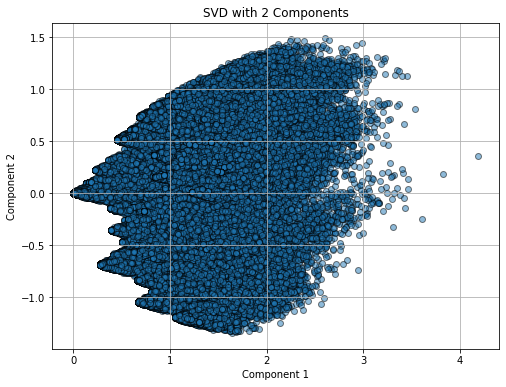


Applying SVD with 5 components...

Applying SVD with 10 components...

Applying SVD with 20 components...

Applying SVD with 50 components...

Applying SVD with 60 components...

Applying SVD with 70 components...

Applying SVD with 80 components...

Applying SVD with 90 components...


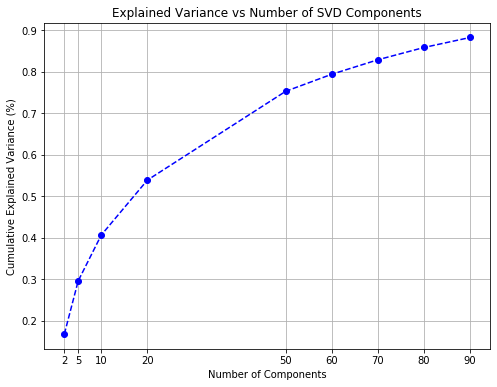

2 components: 16.84% of variance explained
5 components: 29.61% of variance explained
10 components: 40.65% of variance explained
20 components: 53.87% of variance explained
50 components: 75.26% of variance explained
60 components: 79.36% of variance explained
70 components: 82.85% of variance explained
80 components: 85.80% of variance explained
90 components: 88.21% of variance explained


In [95]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Example of applying SVD with different n_components
n_components_list = [2, 5, 10, 20, 50, 60, 70, 80, 90]  # Test different values for n_components
explained_variance = []  # To store explained variance for each n_components


for n in n_components_list:
    print(f"\nApplying SVD with {n} components...")

    # Apply TruncatedSVD (SVD) for dimensionality reduction
    svd = TruncatedSVD(n_components=n)
    svd_result = svd.fit_transform(dx_codes_encoded)  # Perform the dimensionality reduction

    # Store the explained variance ratio
    explained_variance.append(np.sum(svd.explained_variance_ratio_))  # Cumulative explained variance

    # Visualize if n_components is 2 (for easy plotting)
    if n == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(svd_result[:, 0], svd_result[:, 1], alpha=0.5, edgecolors='k', cmap='viridis')
        plt.title(f"SVD with {n} Components")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.show()

# Plot the cumulative explained variance for different n_components
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, explained_variance, marker='o', linestyle='--', color='b')
plt.title("Explained Variance vs Number of SVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.grid(True)
plt.xticks(n_components_list)  # Make sure we have ticks for each test component
plt.show()

# Print out the cumulative explained variance percentages
for n, ev in zip(n_components_list, explained_variance):
    print(f"{n} components: {ev * 100:.2f}% of variance explained")


In [96]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Initialize variables
n = 70  # Set the number of components to 70
explained_variance = []  # To store the explained variance

print(f"\nApplying SVD with {n} components...")

# Apply TruncatedSVD (SVD) for dimensionality reduction
svd = TruncatedSVD(n_components=n)
svd_result = svd.fit_transform(dx_codes_encoded)  # Perform the dimensionality reduction

# Store the explained variance ratio
explained_variance.append(np.sum(svd.explained_variance_ratio_))  # Cumulative explained variance

# Print the cumulative variance explained by 70 components
print(f"{n} components: {explained_variance[0] * 100:.2f}% of variance explained")


Applying SVD with 70 components...
70 components: 82.84% of variance explained


In [97]:
# Print explained variance ratio and singular values
print("Explained variance ratio by component:", svd.explained_variance_ratio_)
print("Sum of explained variance ratios:", svd.explained_variance_ratio_.sum())
print("Singular values:", svd.singular_values_)

Explained variance ratio by component: [0.07721071 0.09117934 0.06256196 0.03275304 0.03244684 0.02708235
 0.02448577 0.02154321 0.02005777 0.01720442 0.01591525 0.01527798
 0.01406845 0.01332504 0.01312881 0.01287264 0.01268187 0.01220745
 0.01201785 0.01097007 0.01062658 0.01019493 0.01009313 0.00959085
 0.00951844 0.00898125 0.00861309 0.00846753 0.00828126 0.00826507
 0.00798282 0.00757139 0.00719953 0.00695611 0.00686949 0.00677693
 0.00666166 0.0063545  0.0062284  0.00612263 0.00597503 0.00588536
 0.00573625 0.00546127 0.00516577 0.00515554 0.00505773 0.00491791
 0.00476659 0.00455835 0.00450764 0.00444748 0.00428615 0.00412295
 0.00405848 0.00399333 0.00397913 0.00391975 0.00381639 0.00380302
 0.00377168 0.00369258 0.003646   0.00357757 0.00343647 0.00340002
 0.00332774 0.00323028 0.00320264 0.00317351]
Sum of explained variance ratios: 0.8284190196058452
Singular values: [558.58261054 334.68015729 279.47151284 208.74403381 198.57883144
 181.4338951  172.81101743 161.8225568  15

In [98]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD

# Apply TruncatedSVD (SVD) for dimensionality reduction (already done earlier)
n = 70  # Number of components
svd = TruncatedSVD(n_components=n)
transformed = svd.fit_transform(dx_codes_encoded)  # Perform the dimensionality reduction

# Update the DataFrame with the SVD-transformed values
print("Updating transformed values in DataFrame...")
df['DX_CCS_codes'] = [';'.join(map(str, row)) for row in transformed]

# Print explained variance ratio and singular values
print("Explained variance ratio by component:", svd.explained_variance_ratio_)
print("Sum of explained variance ratios:", np.sum(svd.explained_variance_ratio_))
print("Singular values:", svd.singular_values_)

Updating transformed values in DataFrame...
Explained variance ratio by component: [0.07721071 0.09117934 0.06256196 0.03275304 0.03244684 0.02708235
 0.02448577 0.02154321 0.02005777 0.01720442 0.01591525 0.01527798
 0.01406845 0.01332504 0.01312881 0.01287264 0.01268187 0.01220745
 0.01201785 0.01097007 0.01062658 0.01019493 0.01009313 0.00959087
 0.00951844 0.00898127 0.00861308 0.00846746 0.00828128 0.00826505
 0.00798283 0.0075714  0.0071994  0.00695602 0.00686954 0.00677686
 0.0066618  0.00635435 0.0062289  0.00612227 0.00597556 0.00588714
 0.00573511 0.00546098 0.00516818 0.0051543  0.00505788 0.00491801
 0.00476472 0.00455525 0.00451271 0.00444687 0.00428733 0.00413052
 0.00406175 0.00398118 0.00395224 0.00390573 0.00384711 0.00380381
 0.00376059 0.00368644 0.00366412 0.00359867 0.00347853 0.00338054
 0.00328599 0.00324917 0.00318276 0.00317919]
Sum of explained variance ratios: 0.8284186800375518
Singular values: [558.58261054 334.68015729 279.47151284 208.74403381 198.5788314

In [99]:
import numpy as np

# Ensure valid_dx_codes_set is a list for indexing
valid_dx_codes_list = list(valid_dx_codes_set)

# Find the indices of the maximum absolute values in each component (top contributing codes)
top_indices = [np.argmax(np.abs(svd.components_[i])) for i in range(10)]

# Get the corresponding codes from the universal lexicon (valid_dx_codes_list)
top_codes = [valid_dx_codes_list[index] for index in top_indices]

# Output the results
print("The first 10 codes contributing most to the variance are:")
for i, code in enumerate(top_codes):
    print(f"Component {i+1}: {code}")


The first 10 codes contributing most to the variance are:
Component 1: PRG029
Component 2: SYM017
Component 3: PRG029
Component 4: SYM017
Component 5: BLD007
Component 6: NVS012
Component 7: PRG016
Component 8: NVS012
Component 9: DIG019
Component 10: GEN018


In [100]:
# Get the top contributing codes for each component from SVD
components = pd.DataFrame(svd.components_, columns=valid_dx_codes_list)
for i, component in enumerate(components.iterrows(), start=1):
    top_codes = component[1].nlargest(10).index
    print(f"Component {i}: {', '.join(top_codes)}")

Component 1: PRG029, INJ030, BLD007, DIG019, SYM017, PRG016, MUS002, RSP002, NVS012, NVS018
Component 2: PRG029, PRG016, DIG019, MUS002, RSP002, NVS018, NVS010, INJ072, EYE004, DIG003
Component 3: DIG019, MUS002, RSP002, NVS018, INJ072, GEN018, BLD006, PRG016, NVS010, SYM017
Component 4: BLD007, INJ030, INJ021, RSP007, NVS012, DIG019, RSP002, INJ010, INJ070, BLD003
Component 5: INJ030, RSP002, DIG019, NVS018, DIG003, NVS010, INJ070, EYE004, INJ014, INJ072
Component 6: NVS012, BLD003, GEN018, END015, MUS002, INJ021, RSP007, PRG029, INJ010, INJ072
Component 7: PRG016, MUS002, INJ030, BLD006, GEN018, BLD003, NVS012, NEO029, GEN020, PRG024
Component 8: NVS012, PRG016, BLD003, END015, RSP002, MUS010, DIG018, EYE004, SYM002, INJ021
Component 9: RSP002, GEN018, INJ072, DIG003, NVS018, NVS010, INJ070, EYE004, PRG029, MUS038
Component 10: GEN018, PRG016, RSP007, INJ021, INJ010, INJ072, BLD003, PRG009, DIG019, END015
Component 11: INJ070, MUS002, INJ021, DIG018, END015, CIR025, PRG009, DIG005, N

In [101]:
# Clean up
print("cleaning up...")
del dx_codes_encoded
del svd
del transformed

cleaning up...


In [110]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Assuming valid_dx_codes is a list of all unique valid DX codes.
valid_px_codes_set = set(px_significant['PX_codes'].dropna().astype(int).unique())
# print(valid_px_codes_set)
valid_px_codes_list = list(valid_px_codes)  # List for indexing later
# print(valid_px_codes_set)
# print(df['PX_CCS'].head())
# print("Encoding with universal diagnosis lexicon...")

px_codes_encoded = []
c = 0
for indx, row in df.iterrows():
    # Initialize a zeroed array with length equal to the number of valid codes
    px_ = np.zeros(len(valid_px_codes), dtype=int)
    
    # Split the PX_CCS string by ';'
    codes = str(row['PX_CCS']).split(';')
    
    if c < 5:  # Debugging the first 5 rows
        print(codes)
    c += 1

    # Set corresponding indices to 1 in the binary array if the code is present in the universal lexicon
    # If valid_px_codes_list contains integers, and 'code' is a string, convert it to integer
    for code in codes:
        code = int(code) 
        if code in valid_px_codes_set:
            i = valid_px_codes_list.index(code)
            px_[i] = 1
        else:
            if c < 5:  # Debugging missing codes
                print(f"Code '{code}' not found in valid_px_codes.")

    
    px_codes_encoded.append(px_)  # Append the binary array to the list
    
    if c < 5:
        print(px_)  # Debugging the first 5 rows

['236', '233']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0]
['-1']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1]
['180', '206', '179', '233']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0]
['205', '197', '233', '200', '226']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1


Applying SVD with 2 components on PX_CCS_codes...


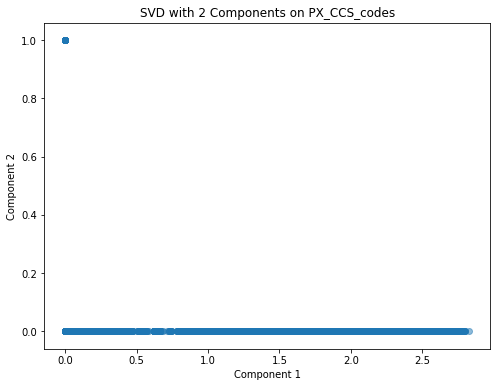


Applying SVD with 5 components on PX_CCS_codes...

Applying SVD with 10 components on PX_CCS_codes...

Applying SVD with 20 components on PX_CCS_codes...

Applying SVD with 25 components on PX_CCS_codes...

Applying SVD with 30 components on PX_CCS_codes...

Applying SVD with 35 components on PX_CCS_codes...

Applying SVD with 40 components on PX_CCS_codes...

Applying SVD with 50 components on PX_CCS_codes...

Applying SVD with 70 components on PX_CCS_codes...


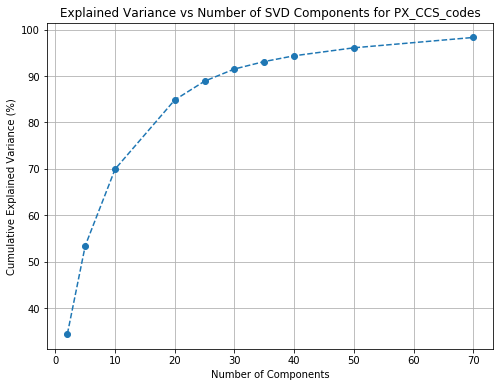

2 components: 34.40% of variance explained
5 components: 53.44% of variance explained
10 components: 69.93% of variance explained
20 components: 84.84% of variance explained
25 components: 88.88% of variance explained
30 components: 91.51% of variance explained
35 components: 93.11% of variance explained
40 components: 94.35% of variance explained
50 components: 96.07% of variance explained
70 components: 98.30% of variance explained


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

valid_px_codes_list = list(valid_px_codes)  # Convert set to list for indexing

# List of different numbers of components to test
n_components_list = [2, 5, 10, 20, 25, 30, 35, 40, 50, 70]

explained_variance_px = []  # To store explained variance for each n_components

# Loop over each value of n_components
for n in n_components_list:
    print(f"\nApplying SVD with {n} components on PX_CCS_codes...")
    
    # Apply TruncatedSVD (SVD) for dimensionality reduction on PX_CCS_codes
    svd = TruncatedSVD(n_components=n)
    svd_result = svd.fit_transform(px_codes_encoded)  # Perform dimensionality reduction
    
    # Store the explained variance ratio in percentage
    explained_variance_px.append(np.sum(svd.explained_variance_ratio_))  # Cumulative explained variance
    
    # Optionally visualize the first two components if n == 2
    if n == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(svd_result[:, 0], svd_result[:, 1], alpha=0.5)
        plt.title(f"SVD with {n} Components on PX_CCS_codes")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.show()

# Plot the cumulative explained variance for different n_components
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, np.array(explained_variance_px) * 100, marker='o', linestyle='--')
plt.title("Explained Variance vs Number of SVD Components for PX_CCS_codes")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.grid(True)
plt.show()

# Print out the cumulative explained variance percentages
for n, ev in zip(n_components_list, explained_variance_px):
    print(f"{n} components: {ev * 100:.2f}% of variance explained")


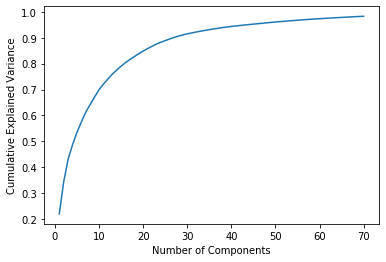

In [112]:
import matplotlib.pyplot as plt
import numpy as np

cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [113]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD

# Apply TruncatedSVD (SVD) for dimensionality reduction (already done earlier)
n = 30  # Number of components
svd = TruncatedSVD(n_components=n)
transformed = svd.fit_transform(px_codes_encoded)  # Perform the dimensionality reduction

# Update the DataFrame with the SVD-transformed values
print("Updating transformed values in DataFrame...")
df['PX_CCS'] = [';'.join(map(str, row)) for row in transformed]

# Print explained variance ratio and singular values
print("Explained variance ratio by component:", svd.explained_variance_ratio_)
print("Sum of explained variance ratios:", np.sum(svd.explained_variance_ratio_))
print("Singular values:", svd.singular_values_)

Updating transformed values in DataFrame...
Explained variance ratio by component: [0.21988682 0.12409475 0.0871393  0.05529222 0.04794762 0.04045252
 0.03795566 0.02958013 0.02872258 0.02822085 0.02165433 0.01954786
 0.01840449 0.01629436 0.01482101 0.01379697 0.01199991 0.01132996
 0.01110544 0.01019137 0.00943585 0.00909111 0.00858007 0.00680038
 0.00647331 0.00623824 0.00580057 0.00546181 0.00460844 0.00413504]
Sum of explained variance ratios: 0.9150629769523361
Singular values: [462.30571211 290.90032657 206.18663789 159.74945501 148.65717296
 136.69339234 133.38147748 116.75451458 115.04825784 114.04316003
  99.90028292  94.91157451  92.72092025  86.65394943  82.64368437
  79.7371011   74.40107752  72.26162203  71.54343057  68.53166149
  65.94232709  64.72913074  62.88039798  55.9946221   54.61791866
  53.62776646  51.70162902  50.39999092  46.14895502  43.65262101]


In [114]:
import numpy as np

# Ensure valid_dx_codes_set is a list for indexing
valid_dx_codes_list = list(valid_px_codes_set)

# Find the indices of the maximum absolute values in each component (top contributing codes)
top_indices = [np.argmax(np.abs(svd.components_[i])) for i in range(10)]

# Get the corresponding codes from the universal lexicon (valid_dx_codes_list)
top_codes = [valid_px_codes_list[index] for index in top_indices]

# Output the results
print("The first 10 codes contributing most to the variance are:")
for i, code in enumerate(top_codes):
    print(f"Component {i+1}: {code}")


The first 10 codes contributing most to the variance are:
Component 1: 233
Component 2: -1
Component 3: 233
Component 4: 206
Component 5: 200
Component 6: 205
Component 7: 227
Component 8: 236
Component 9: 226
Component 10: 177


In [115]:
# Clean up
print("cleaning up...")
del px_codes_encoded
del svd
del transformed

cleaning up...


In [116]:
df.to_csv(PATH_PROCESSED_DATA + "ml_project_v2.csv", index=False)

### Normalize Lab Codes and Perform SVD
- Normalizing lab codes is different than prior normalization subce lab result (in loincs_results_modifier_unit) may have multiple values associated with it.
- Different labs may have different value ranges, so for each lab code, we calculate its own min and max values.
- These values are then used to normalize the results for that specific lab.

In [117]:
# create a dictionary of max and min vals for each lab unit to normalize each unit differently 
code_results = {}

print("retrieving values...")
for indx, row in df.iterrows():
    
    if pd.isna(row['loincs_results_modifier_unit']): continue
    
    labs = row['loincs_results_modifier_unit'].replace('\'', '')
    
    if '{#}' in labs: labs = labs.replace('{#}', '{}')
    tokens = labs.split('#')
    
    for t in tokens:
        
        t_ = str(t).split(';')
        while 'nan' in t_:
            t_.remove('nan')
            
        result = t_[1] # value
        code = t_[0] # key
            
        if code in code_results: # create dictionary of key value pairs
            code_results[ code ].append( result )
        else:
            code_results[ code ] = [ result ]

print("getting min and max...")   
for k, v in code_results.items(): 
    while 'TX' in v:
        v.remove('TX')
    while 'NI' in v: 
        v.remove('NI')
    while 'EQ' in v:
        v.remove('EQ')
            
    v = np.asarray(v, dtype=np.float64)
    v = np.nan_to_num(v, nan=-1)
    
    code_results[k] = [np.min(v), np.max(v)] # replace values of key item with min and max from the list for that key
    print(code_results[k])

retrieving values...
getting min and max...
[0.0, 2219.0]
[0.0, 308.0]
[0.0, 388.5]
[0.0, 408.1]
[4.0, 200.0]
[2.0, 97.0]
[-48.0, 98.0]
[0.0, 297.5]
[2.6, 3405.0]
[0.0, 2331.0]
[10.0, 5058.0]
[2.4, 22.8]
[-67.0, 564.0]
[0.0, 33.2]
[0.0, 236.8]
[6.53, 7.84]
[6.53, 7.81]
[5.0, 244.0]
[10.0, 700.0]
[1.0, 192.0]
[0.0, 123.0]
[0.0, 25858.0]
[1.0, 10623.0]
[0.1, 34.9]
[10.0, 350.0]
[0.0, 42.4]
[54.0, 427.0]
[7.0, 763.0]
[26.0, 95.0]
[7.493, 7.493]


In [118]:
print(code_results)

{'2345-7': [0.0, 2219.0], '6299-2': [0.0, 308.0], '98979-8': [0.0, 388.5], '2160-0': [0.0, 408.1], '2951-2': [4.0, 200.0], '2028-9': [2.0, 97.0], '33037-3': [-48.0, 98.0], '26464-8': [0.0, 297.5], '4544-3': [2.6, 3405.0], '10839-9': [0.0, 2331.0], '2339-0': [10.0, 5058.0], '4548-4': [2.4, 22.8], '13457-7': [-67.0, 564.0], '2524-7': [0.0, 33.2], '6690-2': [0.0, 236.8], '2746-6': [6.53, 7.84], '2744-1': [6.53, 7.81], '2019-8': [5.0, 244.0], '2703-7': [10.0, 700.0], '3094-0': [1.0, 192.0], '1751-7': [0.0, 123.0], '1920-8': [0.0, 25858.0], '1742-6': [1.0, 10623.0], '34543-9': [0.1, 34.9], '18262-6': [10.0, 350.0], '15152-2': [0.0, 42.4], '1558-6': [54.0, 427.0], '1743-4': [7.0, 763.0], '48642-3': [26.0, 95.0], '11558-4': [7.493, 7.493]}


In [119]:
def create_unique_loinc_codes(df):
    print("creating lexicon...")
    loinc_codes = []

    for indx, row in df.iterrows():
        loinc_unit = str(row['loincs_results_modifier_unit'])  # Convert to string to handle float values
        
        if loinc_unit == '-99':
            loinc_codes.append('-99')
            continue
        
        labs = loinc_unit.replace('\'', '')
       
        if '{#}' in labs:
            labs = labs.replace('{#}', '{}')
        tokens = labs.split('#')
        
        for t in tokens:
            loinc_codes.append(t.split(';')[0])

    print("sorting...")
    unique_loinc_codes = sorted(list(set(loinc_codes)))  # creates a unique sorted list of loinc_codes
    print("unique loinc codes:", len(unique_loinc_codes))
    
    return unique_loinc_codes

In [120]:
all_loinc_codes = create_unique_loinc_codes(df)
print(all_loinc_codes)

creating lexicon...
sorting...
unique loinc codes: 31
['10839-9', '11558-4', '13457-7', '15152-2', '1558-6', '1742-6', '1743-4', '1751-7', '18262-6', '1920-8', '2019-8', '2028-9', '2160-0', '2339-0', '2345-7', '2524-7', '26464-8', '2703-7', '2744-1', '2746-6', '2951-2', '3094-0', '33037-3', '34543-9', '4544-3', '4548-4', '48642-3', '6299-2', '6690-2', '98979-8', 'nan']


In [88]:
loincs_PATH = '/data/dassie/Stats/CDM_Stats/Lexicons/loincs/'

all_loinc_codes = np.load(loincs_PATH + 'all_loinc_codes.npy', allow_pickle=True)

print("Unique loinc codes:")
print(all_loinc_codes)

Unique loinc codes:
['10839-9' '11558-4' '13457-7' '15152-2' '1558-6' '1742-6' '1743-4'
 '1751-7' '18262-6' '1920-8' '2019-8' '2028-9' '2160-0' '2339-0' '2345-7'
 '2524-7' '26464-8' '2703-7' '2744-1' '2746-6' '2951-2' '3094-0' '33037-3'
 '34543-9' '42757-5' '4544-3' '4548-4' '48642-3' '6299-2' '6690-2'
 '69405-9' '98979-8' 'nan']


### SVD on Lab Codes

In [121]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Ensure '-99' is included in the list if not present
if '-99' not in all_loinc_codes:
    all_loinc_codes = np.append(all_loinc_codes, '-99')

print("encoding...")
loinc_codes_encoded = []

for indx, row in df.iterrows():
    
    loinc_ = np.zeros((len(all_loinc_codes),), dtype=float)
    
    loincs_value = row['loincs_results_modifier_unit']
    
    # Handle NaN values in 'loincs_results_modifier_unit'
    if isinstance(loincs_value, float) and np.isnan(loincs_value):
        loincs_value = '-99'
    
    if loincs_value == '-99':  # Missing as a new category
        i = list(all_loinc_codes).index('-99')
        loinc_[i] = -1
        
    else:
        labs = loincs_value.replace('\'', '')
        if '{#}' in labs: labs = labs.replace('{#}', '{}')
        tokens = labs.split('#')

        for t in tokens:
            t_ = t.split(';')
            
            # Remove 'nan' from the tokens list
            while 'nan' in t_:
                t_.remove('nan')
                
            code = t_[0]
            result = -1 if (t_[1] == 'nan') or (t_[1] == 'TX') or (t_[1] == 'NI') or (t_[1] == 'EQ') else float(t_[1])
            
            # Fetch population min and max for normalization
            pop_min = -1 if code_results[code][0] is np.nan else code_results[code][0]
            pop_max = -1 if code_results[code][1] is np.nan else code_results[code][1]
            
            if pop_min == -1 and pop_max == -1:
                loinc_[i] = -1
            else:
                i = list(all_loinc_codes).index(code)
                loinc_[i] = normalize(pop_min, pop_max, result)

    loinc_ = np.nan_to_num(loinc_, nan=-1)
    loinc_codes_encoded.append(loinc_)
    

encoding...


/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars



Applying SVD with 2 components on loinc_codes_encoded...
2 components: 80.25% of variance explained


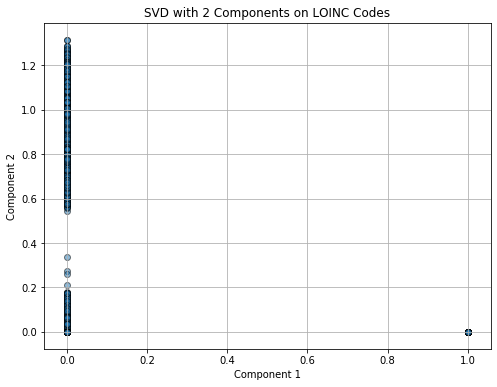


Applying SVD with 5 components on loinc_codes_encoded...
5 components: 95.00% of variance explained

Applying SVD with 7 components on loinc_codes_encoded...
7 components: 97.60% of variance explained

Applying SVD with 9 components on loinc_codes_encoded...
9 components: 98.92% of variance explained

Applying SVD with 10 components on loinc_codes_encoded...
10 components: 99.22% of variance explained

Applying SVD with 12 components on loinc_codes_encoded...
12 components: 99.54% of variance explained

Applying SVD with 15 components on loinc_codes_encoded...
15 components: 99.82% of variance explained

Applying SVD with 20 components on loinc_codes_encoded...
20 components: 99.95% of variance explained


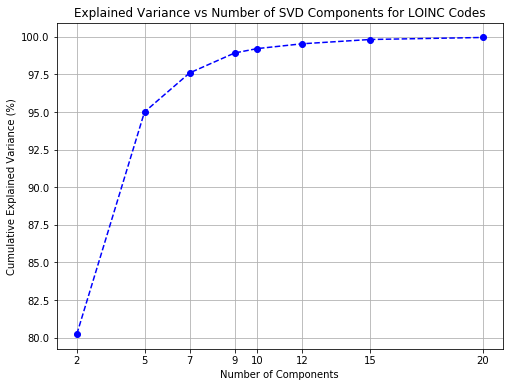

In [122]:
# -------------------
# List of different numbers of components to test
n_components_list = [2, 5, 7, 9, 10, 12, 15, 20]

# Assuming loinc_codes_encoded is the encoded data
# If using a sparse matrix, convert it to a dense matrix before applying SVD if needed

# Initialize an empty list to store explained variance for each n_components
explained_variance_list = []

# Loop through each value in n_components_list and apply SVD
for n in n_components_list:
    print(f"\nApplying SVD with {n} components on loinc_codes_encoded...")

    # Apply TruncatedSVD for dimensionality reduction
    svd = TruncatedSVD(n_components=n)
    transformed = svd.fit_transform(loinc_codes_encoded)  # Perform dimensionality reduction
    
    # Store the cumulative explained variance ratio for the current n_components
    explained_variance = np.sum(svd.explained_variance_ratio_)
    explained_variance_list.append(explained_variance)
    
    # Print explained variance for this number of components
    print(f"{n} components: {explained_variance * 100:.2f}% of variance explained")
    
    # Optionally, visualize the first two components if n == 2
    if n == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5, edgecolors='k', cmap='viridis')
        plt.title(f"SVD with {n} Components on LOINC Codes")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.show()

# Plot the cumulative explained variance for different n_components
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, np.array(explained_variance_list) * 100, marker='o', linestyle='--', color='b')
plt.title("Explained Variance vs Number of SVD Components for LOINC Codes")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.grid(True)
plt.xticks(n_components_list)  # Make sure we have ticks for each test component
plt.show()

In [123]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD


# Apply TruncatedSVD (SVD) for dimensionality reduction (already done earlier)
n = 10  # Number of components
svd = TruncatedSVD(n_components=n)
transformed = svd.fit_transform(loinc_codes_encoded)  # Perform the dimensionality reduction

# Update the DataFrame with the SVD-transformed values
print("Updating transformed values in DataFrame...")
df['loincs_results_modifier_unit'] = [';'.join(map(str, row)) for row in transformed]

# Print explained variance ratio and singular values
print("Explained variance ratio by component:", svd.explained_variance_ratio_)
print("Sum of explained variance ratios:", np.sum(svd.explained_variance_ratio_))
print("Singular values:", svd.singular_values_)

Updating transformed values in DataFrame...
Explained variance ratio by component: [0.45646221 0.34601946 0.08195384 0.04002101 0.02557913 0.01652854
 0.0094064  0.00808148 0.00519586 0.00290243]
Sum of explained variance ratios: 0.9921503616615479
Singular values: [355.02394285 294.44088447 108.71167769  75.59674654  60.48249281
  48.57932969  36.65102165  33.9708373   27.23727186  20.35785156]


In [124]:
import numpy as np

# Ensure valid_dx_codes_set is a list for indexing
valid_dx_codes_list = list(all_loinc_codes)

# Find the indices of the maximum absolute values in each component (top contributing codes)
top_indices = [np.argmax(np.abs(svd.components_[i])) for i in range(10)]

# Get the corresponding codes from the universal lexicon (valid_dx_codes_list)
top_codes = [all_loinc_codes[index] for index in top_indices]

# Output the results
print("The first 10 codes contributing most to the variance are:")
for i, code in enumerate(top_codes):
    print(f"Component {i+1}: {code}")


The first 10 codes contributing most to the variance are:
Component 1: -99
Component 2: 2951-2
Component 3: 2746-6
Component 4: 2746-6
Component 5: 4548-4
Component 6: 33037-3
Component 7: 13457-7
Component 8: 98979-8
Component 9: 18262-6
Component 10: 3094-0


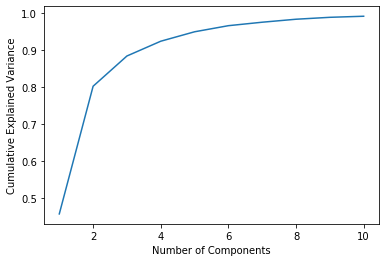

In [125]:
import matplotlib.pyplot as plt
import numpy as np

cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [126]:
print(df.shape)
print(df.columns)

(261000, 95)
Index(['ENCOUNTERID', 'PATID', 'ADMIT_DATETIME', 'DISCHARGE_DATETIME',
       'ENC_TYPE', 'DISCHARGE_STATUS', 'DX_codes', 'SEX', 'HISPANIC', 'RACE',
       'loincs_results_modifier_unit', 'DIASTOLIC', 'SYSTOLIC', 'TOBACCO',
       'RXNORM_CUI', 'age', 'distance', 'SDI_quantile', 'ELIXHAUSER',
       'DX_CCS_codes', 'PX_CCS', 'n_dx', 'n_px', 'readmission',
       'ADMIT_DURATION', 'prior_IP_OS_ED_count',
       'days_since_prior_IP_OS_ED_patient_level_int', 'isMetropolitan', 'CKD',
       'BMI', 'prior_other_encounter_types_count', 'RUCA_CODE',
       'days_since_prior_enc_patient_level', 'Insulins',
       'Glucagon-like peptide-1 (GLP-1) analogues', 'Biguanides',
       'Sulfonylureas', 'Sulfonamides (heterocyclic)',
       'Alpha glucosidase inhibitors', 'Thiazolidinediones',
       'Dipeptidyl peptidase 4 (DPP-4) inhibitors',
       'Sodium-glucose co-transporter 2 (SGLT2) inhibitors',
       'Other blood glucose lowering drugs, excl. insulins',
       'Aldose reductase

In [127]:
df.to_csv(PATH_PROCESSED_DATA + "ml_project_v4.csv", index=False)

### Calculate Rate of Readmission for IP Encounters

In [3]:
df = pd.read_csv(PATH_PROCESSED_DATA + "ml_project_v4.csv", dtype=str)

In [4]:
# Filter the DataFrame to include only inpatient encounters (ENC_TYPE == 'IP')
df_ip = df[df['ENC_TYPE'] == 'IP'].copy()  # Make an explicit copy

# Ensure 'readmission_new' is an integer type using .loc to avoid SettingWithCopyWarning
df_ip['readmission'] = df_ip['readmission'].astype(int)

# Calculate readmission count for inpatient encounters (sum of readmissions, where readmission_new == 1)
readmission_count_encounters = int(df_ip['readmission'].sum())  # Sum of all readmission encounters (y == 1)

# Total number of inpatient encounters
total_encounters = int(df_ip.shape[0])  # Total number of inpatient encounters (rows in dataset)

# Check if there are inpatient encounters to avoid division by zero
if total_encounters > 0:
    # Calculate the readmission rate as the ratio of readmissions to total inpatient encounters
    readmission_rate_encounters = float(readmission_count_encounters) / float(total_encounters)

    # Print the result as a percentage
    print(f"Total Inpatient Encounters: {total_encounters}")
    print(f"Total Readmissions (IP Encounters): {readmission_count_encounters}")
    print(f"Readmission Rate (IP Encounters): {readmission_rate_encounters * 100:.2f}%")
else:
    print("No inpatient encounters found.")

Total Inpatient Encounters: 59526
Total Readmissions (IP Encounters): 11709
Readmission Rate (IP Encounters): 19.67%


## Prepare Data for Machine Learning

In [3]:
df = pd.read_csv(PATH_PROCESSED_DATA + "ml_project_v4.csv", dtype=str)
print(df.shape)

(261000, 95)


In [6]:
# Get Count of Unique Patients, Readmission Rates:
print("Number of Unique Patients: ", df['PATID'].unique().shape[0])

# Readmission Rates Across Encounters
df['readmission'] = df['readmission'].astype(int)
readmission_count_encounters = int(df['readmission'].sum())  # Sum of all readmission encounters (y == 1)
total_encounters = int(df.shape[0])  # Total number of encounters (rows in dataset)

# Convert to float to avoid overflow
print(readmission_count_encounters)
print(total_encounters)
readmission_rate_encounters = float(readmission_count_encounters) / float(total_encounters)

# Print the result
print(f"Readmission Rate (Encounters): {readmission_rate_encounters * 100:.2f}%")



# Readmission Rates Across Unique Patients
df['readmission'] = df['readmission'].astype(int)

# Step 1: Group by patient_id and calculate total readmissions and total encounters
patient_readmission_rate = df.groupby('PATID')['readmission'].agg(
    total_readmissions='sum',  # Sum of readmissions per patient
    total_encounters='count'   # Count of total encounters per patient
)

# Step 2: Calculate readmission rate for each patient
patient_readmission_rate['readmission_rate'] = patient_readmission_rate['total_readmissions'] / patient_readmission_rate['total_encounters']

# Step 3: Calculate the average readmission rate across all unique patients
avg_readmission_rate = patient_readmission_rate['readmission_rate'].mean()

avg_readmission_rate_percent = avg_readmission_rate * 100

print(f"Average Readmission Rate (Per Unique Patient): {avg_readmission_rate_percent:.2f}%")


Number of Unique Patients:  27469
11709
261000
Readmission Rate (Encounters): 4.49%
Average Readmission Rate (Per Unique Patient): 6.35%


In [52]:
df.groupby(['ENC_TYPE', 'readmission']).size()

ENC_TYPE  readmission
AV_TH     0              116206
CLPSED    0               66966
ED        0                6323
IP        0               47817
          1               11709
OS        0               11979
dtype: int64

In [53]:
print(df.shape)
for col in df.columns:
    print(col)

(261000, 95)
ENCOUNTERID
PATID
ADMIT_DATETIME
DISCHARGE_DATETIME
ENC_TYPE
DISCHARGE_STATUS
DX_codes
SEX
HISPANIC
RACE
loincs_results_modifier_unit
DIASTOLIC
SYSTOLIC
TOBACCO
RXNORM_CUI
age
distance
SDI_quantile
ELIXHAUSER
DX_CCS_codes
PX_CCS
n_dx
n_px
readmission
ADMIT_DURATION
prior_IP_OS_ED_count
days_since_prior_IP_OS_ED_patient_level_int
isMetropolitan
CKD
BMI
prior_other_encounter_types_count
RUCA_CODE
days_since_prior_enc_patient_level
Insulins
Glucagon-like peptide-1 (GLP-1) analogues
Biguanides
Sulfonylureas
Sulfonamides (heterocyclic)
Alpha glucosidase inhibitors
Thiazolidinediones
Dipeptidyl peptidase 4 (DPP-4) inhibitors
Sodium-glucose co-transporter 2 (SGLT2) inhibitors
Other blood glucose lowering drugs, excl. insulins
Aldose reductase inhibitors
AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM
ANTIHYPERTENSIVES
BETA BLOCKING AGENTS
CORTICOSTEROIDS FOR SYSTEMIC USE
LIPID MODIFYING AGENTS
ENC_TYPE_ED
ENC_TYPE_OS
ENC_TYPE_AV_TH
ENC_TYPE_IP
ENC_TYPE_CLPSED
DISCHARGE_STATUS_HO
DI

In [54]:
np.save(
    PATH_PROCESSED_DATA + 'Temple_encounterids_final.npy',
    np.array(df['ENCOUNTERID'].values.tolist())
)

In [55]:
for col in df.columns:
    if col not in ['ENCOUNTERID', 'PATID']:  # Exclude 'ENCOUTNERID' and 'PATID'
        print(col)
        print(f"Value counts for {col}:")
        print(df[col].value_counts())
        print("\n")

ADMIT_DATETIME
Value counts for ADMIT_DATETIME:
2019-05-14    236
2020-01-14    225
2018-04-23    221
2021-02-09    218
2019-02-05    218
             ... 
2022-08-27     19
2017-09-02     19
2018-05-13     19
2017-12-17     18
2017-04-23     15
Name: ADMIT_DATETIME, Length: 2087, dtype: int64


DISCHARGE_DATETIME
Value counts for DISCHARGE_DATETIME:
2020-01-14    241
2019-05-14    234
2019-12-20    222
2020-01-29    221
2017-09-27    220
             ... 
2019-09-02     15
2017-06-18     15
2018-08-26     15
2016-12-18     12
2018-04-15     12
Name: DISCHARGE_DATETIME, Length: 2087, dtype: int64


ENC_TYPE
Value counts for ENC_TYPE:
AV_TH     116206
CLPSED     66966
IP         59526
OS         11979
ED          6323
Name: ENC_TYPE, dtype: int64


DISCHARGE_STATUS
Value counts for DISCHARGE_STATUS:
CLPSED    185667
HO         37611
HH         23803
SN_RH      10390
AM          3529
Name: DISCHARGE_STATUS, dtype: int64


DX_codes
Value counts for DX_codes:
E119                          

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0    32466
0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0    27712
0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0    17955
0;0;0;0;0;1;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0    10290
0;0;0;0;0;1;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0     8862
                                                                 ...  
1;0;0;0;0;0;1;0;0;0;1;0;0;0;0;0;0;0;0;0;0;1;0;0;1;0;0;0;0;0;1        1
1;0;0;0;1;0;1;0;0;1;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0        1
1;0;0;0;1;0;1;0;0;1;0;1;0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;1;0;0        1
1;1;0;0;1;0;1;0;0;1;0;1;0;0;0;0;0;0;0;0;0;1;1;1;1;0;0;1;0;0;0        1
0;1;0;0;1;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;1;0        1
Name: ELIXHAUSER, Length: 33719, dtype: int64


DX_CCS_codes
Value counts for DX_CCS_codes:
0.454058591951301;0.5135154117446382;-0.542333310651504;-0.3903980047662575;-0.05399325282655629;0.09768171103574226;-0.1965775

-1.511639876219124e-14;1.0000000000000102;-2.8317171162595756e-16;9.055921328029115e-18;2.872820096950671e-18;1.3762237729167008e-17;1.1630857943281305e-17;-4.5061461883332246e-17;1.026912462396736e-17;3.672788653769131e-17;6.997366078970512e-18;-1.160657832583445e-16;-1.2504242796498273e-16;2.0325796234202781e-16;2.341599186100771e-16;8.866733021223969e-17;-2.843022191243604e-17;-3.786493560413094e-17;4.262564567293919e-17;2.490192178297728e-17;-8.718453906015453e-17;-5.036552408124146e-17;-1.1147414393666885e-16;-7.945830026467322e-17;3.76051891727951e-16;1.0800242844683942e-18;-3.4217221579806393e-17;-1.1323235465045407e-16;-3.311959356735794e-16;-2.260098593732597e-16    84557
0.794962126059567;-2.255731170963437e-13;-0.5741152384162334;0.14773770625319488;-0.011565306848206178;-0.015988883646426467;-0.09680578709180229;-0.027712790817102463;-0.03385306662083993;0.029826072903258376;-0.023865494126676375;0.014324962795100883;-0.00560314822982345;0.023758333054306125;0.0018761160414

0.0                     22106
0.001694915254237288     9611
0.003389830508474576     7695
0.005084745762711864     6769
0.006779661016949152     6368
                        ...  
0.9779661016949153          1
0.7016949152542373          1
0.976271186440678           1
0.6508474576271186          1
0.6677966101694915          1
Name: prior_other_encounter_types_count, Length: 438, dtype: int64


RUCA_CODE
Value counts for RUCA_CODE:
1.0       258216
2.0         1432
3+          1075
CLPSED       277
Name: RUCA_CODE, dtype: int64


days_since_prior_enc_patient_level
Value counts for days_since_prior_enc_patient_level:
0.1944116489571035     31825
0.19480519480519481    19914
0.1951987406532861     13226
0.19559228650137742    11943
0.19716646989374262    11889
                       ...  
0.6934277843368752         1
0.670995670995671          1
0.734750098386462          1
0.5623770169224714         1
0.5411255411255411         1
Name: days_since_prior_enc_patient_level, Length: 1374, 

In [56]:
# Drop columns because no occurrences for each medication for all encounters
print(df.shape)
df.drop(columns=['Sulfonamides (heterocyclic)'], inplace=True)
df.drop(columns=['Aldose reductase inhibitors'], inplace=True)
print(df.shape)

(261000, 95)
(261000, 93)


In [57]:
for col in df.columns:
    print(col)

ENCOUNTERID
PATID
ADMIT_DATETIME
DISCHARGE_DATETIME
ENC_TYPE
DISCHARGE_STATUS
DX_codes
SEX
HISPANIC
RACE
loincs_results_modifier_unit
DIASTOLIC
SYSTOLIC
TOBACCO
RXNORM_CUI
age
distance
SDI_quantile
ELIXHAUSER
DX_CCS_codes
PX_CCS
n_dx
n_px
readmission
ADMIT_DURATION
prior_IP_OS_ED_count
days_since_prior_IP_OS_ED_patient_level_int
isMetropolitan
CKD
BMI
prior_other_encounter_types_count
RUCA_CODE
days_since_prior_enc_patient_level
Insulins
Glucagon-like peptide-1 (GLP-1) analogues
Biguanides
Sulfonylureas
Alpha glucosidase inhibitors
Thiazolidinediones
Dipeptidyl peptidase 4 (DPP-4) inhibitors
Sodium-glucose co-transporter 2 (SGLT2) inhibitors
Other blood glucose lowering drugs, excl. insulins
AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM
ANTIHYPERTENSIVES
BETA BLOCKING AGENTS
CORTICOSTEROIDS FOR SYSTEMIC USE
LIPID MODIFYING AGENTS
ENC_TYPE_ED
ENC_TYPE_OS
ENC_TYPE_AV_TH
ENC_TYPE_IP
ENC_TYPE_CLPSED
DISCHARGE_STATUS_HO
DISCHARGE_STATUS_HH
DISCHARGE_STATUS_SN_RH
DISCHARGE_STATUS_AM
DISCHARG

In [58]:
columns = ['ENCOUNTERID', 'PATID', 'ADMIT_DATETIME', 'DISCHARGE_DATETIME', 
           'ENC_TYPE_ED', 'ENC_TYPE_OS', 'ENC_TYPE_AV_TH', 'ENC_TYPE_IP', 'ENC_TYPE_CLPSED',
           'DISCHARGE_STATUS_HO', 'DISCHARGE_STATUS_HH', 'DISCHARGE_STATUS_SN_RH', 'DISCHARGE_STATUS_AM', 'DISCHARGE_STATUS_CLPSED',
           'SEX_F', 'SEX_M', 'HISPANIC_N', 'HISPANIC_Y', 'HISPANIC_CLPSED',
           'RACE_01_02_04', 'RACE_03', 'RACE_05', 'RACE_CLPSED', 'TOBACCO_01', 'TOBACCO_02', 'TOBACCO_03', 'TOBACCO_CLPSED',
           'SDI_quantile_0', 'SDI_quantile_1', 'SDI_quantile_2', 'SDI_quantile_3', 'SDI_quantile_4',
           'isMetropolitan_0.0', 'isMetropolitan_1.0', 'isMetropolitan_CLPSED', 'CKD_0', 'CKD_1', 'CKD_2', 'CKD_3', 'CKD_4', 'CKD_5',
           'BMI_<18.5', 'BMI_18.5 – 24.9', 'BMI_25.0 – 29.9', 'BMI_30.0+', 'BMI_CLPSED',
           'RUCA_CODE_1.0', 'RUCA_CODE_2.0', 'RUCA_CODE_3+', 'RUCA_CODE_CLPSED',
           'days_since_prior_enc_patient_level', 'days_since_prior_IP_OS_ED_patient_level_int', 'prior_IP_OS_ED_count' , 'prior_other_encounter_types_count',
           'loincs_results_modifier_unit', 'DIASTOLIC', 'SYSTOLIC', 
           'n_dx', 'n_px', 'DX_CCS_codes', 'PX_CCS',
           'age', 'ELIXHAUSER', 'distance',
           'Insulins', 'Glucagon-like peptide-1 (GLP-1) analogues', 'Biguanides', 'Sulfonylureas', 'Alpha glucosidase inhibitors', 'Thiazolidinediones',
           'Dipeptidyl peptidase 4 (DPP-4) inhibitors', 'Sodium-glucose co-transporter 2 (SGLT2) inhibitors', 'Other blood glucose lowering drugs, excl. insulins',
           'AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM', 'ANTIHYPERTENSIVES', 'BETA BLOCKING AGENTS', 'CORTICOSTEROIDS FOR SYSTEMIC USE', 'LIPID MODIFYING AGENTS',
           'readmission', 'ADMIT_DURATION']


 
for col in columns:
    print(col)
    print(df[col].unique())

ENCOUNTERID
['TEMPLE63025039' 'TEMPLE93601259' 'TEMPLE58999755' ... 'TEMPLE67576767'
 'TEMPLE67697879' 'TEMPLE94033795']
PATID
['700000015' '700000021' '700000022' ... '700131263' '700131264'
 '700131271']
ADMIT_DATETIME
['2018-06-12' '2020-02-19' '2022-08-26' ... '2018-12-02' '2020-04-12'
 '2018-11-04']
DISCHARGE_DATETIME
['2018-06-12' '2020-02-19' '2022-08-29' ... '2021-03-07' '2019-06-02'
 '2022-05-08']
ENC_TYPE_ED
['0.0' '1.0']
ENC_TYPE_OS
['1.0' '0.0']
ENC_TYPE_AV_TH
['0.0' '1.0']
ENC_TYPE_IP
['0.0' '1.0']
ENC_TYPE_CLPSED
['0.0' '1.0']
DISCHARGE_STATUS_HO
['1.0' '0.0']
DISCHARGE_STATUS_HH
['0.0' '1.0']
DISCHARGE_STATUS_SN_RH
['0.0' '1.0']
DISCHARGE_STATUS_AM
['0.0' '1.0']
DISCHARGE_STATUS_CLPSED
['0.0' '1.0']
SEX_F
['1.0' '0.0']
SEX_M
['0.0' '1.0']
HISPANIC_N
['1.0' '0.0']
HISPANIC_Y
['0.0' '1.0']
HISPANIC_CLPSED
['0.0' '1.0']
RACE_01_02_04
['0.0' '1.0']
RACE_03
['1.0' '0.0']
RACE_05
['0.0' '1.0']
RACE_CLPSED
['0.0' '1.0']
TOBACCO_01
['0.0' '1.0']
TOBACCO_02
['1.0' '0.0']
TOBACCO_

['9.814158025278349e-14;0.8738250583796399;-0.2587902082253013;0.02911465408364761;-0.024124124964544188;0.19995412162344584;0.25918546262782344;-0.05170885546808983;0.07674656174838689;0.003007690998438625'
 '1.0000000000000022;-1.9334471923953614e-14;2.4715585750673793e-12;7.841953222460665e-12;7.775804219593284e-14;1.253546464268918e-11;-4.39428222602171e-12;-1.0854287437564256e-12;3.0901394955195186e-12;4.7439933090372836e-12'
 '1.6207238812329318e-14;0.7755923432336514;-0.22117806583157837;0.031037722732838877;-0.2395772436897599;-0.022183209031859746;-0.02348559002943833;0.021273594161773563;-0.011834847260798682;-0.034364347688803164'
 ...
 '5.2659482369072025e-14;0.9856515691685074;0.2027526846600784;-0.4443526120800659;-0.08746818934473005;-0.24318070525534166;-0.04694060503938307;-0.027511503756659998;0.25462262646390343;0.022456300156653685'
 '5.3998605859802746e-14;0.9816562310830844;0.21093173710950242;-0.4474952896717537;-0.10473805235373898;-0.21837162848092403;-0.051957

['0.0015503875968992248' '0.0012919896640826874' '0.03875968992248062'
 '0.01731266149870801' '0.00025839793281653745' '0.0010335917312661498'
 '0.02635658914728682' '0.026873385012919897' '0.0007751937984496124'
 '0.018604651162790697' '0.029198966408268735' '0.0020671834625322996'
 '0.016537467700258397' '0.004134366925064599' '0.003359173126614987'
 '0.0005167958656330749' '0.0018087855297157622' '0.002583979328165375'
 '0.04186046511627907' '0.002842377260981912' '0.008785529715762274'
 '0.013953488372093023' '0.01317829457364341' '0.005426356589147287' '0.0'
 '0.004651162790697674' '0.002325581395348837' '0.01937984496124031'
 '0.009560723514211887' '0.010077519379844961' '0.3772609819121447'
 '0.0031007751937984496' '0.007235142118863049' '0.04237726098191214'
 '0.0036175710594315244' '0.004392764857881137' '0.01524547803617571'
 '0.00516795865633075' '0.026614987080103358' '0.012403100775193798'
 '0.014470284237726097' '0.019896640826873386' '0.019638242894056846'
 '0.0413436692

In [59]:
df = df[columns]

df.shape

(261000, 80)

In [60]:
# find length of each encounter

len( ','.join(list(map(str,df.iloc[0].values.tolist()))).replace(';',',').split(',') )

221

In [61]:
df['ADMIT_DURATION'] = df['ADMIT_DURATION'].fillna(0)

### Train SVD on All Features for a Given Encounter

In [62]:
# TRAIN SVD


visits = df[ ['ENC_TYPE_ED', 'ENC_TYPE_OS', 'ENC_TYPE_AV_TH', 'ENC_TYPE_IP', 'ENC_TYPE_CLPSED',
           'DISCHARGE_STATUS_HO', 'DISCHARGE_STATUS_HH', 'DISCHARGE_STATUS_SN_RH', 'DISCHARGE_STATUS_AM', 'DISCHARGE_STATUS_CLPSED',
           'SEX_F', 'SEX_M', 'HISPANIC_N', 'HISPANIC_Y', 'HISPANIC_CLPSED',
           'RACE_01_02_04', 'RACE_03', 'RACE_05', 'RACE_CLPSED', 'TOBACCO_01', 'TOBACCO_02', 'TOBACCO_03', 'TOBACCO_CLPSED',
           'SDI_quantile_0', 'SDI_quantile_1', 'SDI_quantile_2', 'SDI_quantile_3', 'SDI_quantile_4',
           'isMetropolitan_0.0', 'isMetropolitan_1.0', 'isMetropolitan_CLPSED', 'CKD_0', 'CKD_1', 'CKD_2', 'CKD_3', 'CKD_4', 'CKD_5',
           'BMI_<18.5', 'BMI_18.5 – 24.9', 'BMI_25.0 – 29.9', 'BMI_30.0+', 'BMI_CLPSED',
           'RUCA_CODE_1.0', 'RUCA_CODE_2.0', 'RUCA_CODE_3+', 'RUCA_CODE_CLPSED',
           'days_since_prior_enc_patient_level', 'days_since_prior_IP_OS_ED_patient_level_int', 'prior_IP_OS_ED_count' , 'prior_other_encounter_types_count',
           'loincs_results_modifier_unit', 'DIASTOLIC', 'SYSTOLIC', 
           'n_dx', 'n_px', 'DX_CCS_codes', 'PX_CCS',
           'age', 'ELIXHAUSER', 'distance',
           'Insulins', 'Glucagon-like peptide-1 (GLP-1) analogues', 'Biguanides', 'Sulfonylureas', 'Thiazolidinediones',
           'Dipeptidyl peptidase 4 (DPP-4) inhibitors', 'Sodium-glucose co-transporter 2 (SGLT2) inhibitors', 'Other blood glucose lowering drugs, excl. insulins', 
           'AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM', 'ANTIHYPERTENSIVES', 'BETA BLOCKING AGENTS', 'CORTICOSTEROIDS FOR SYSTEMIC USE', 'LIPID MODIFYING AGENTS',
           'ADMIT_DURATION'] ].values.tolist() # encounterid, patid, discharge_datetime, admit_datetime removed


c = 0
for v in range(len(visits)):
    
    if c % 500_000 == 0: print(c)
    c+=1
    
    for i in range(len(visits[v])):
        visits[v][i] = str(visits[v][i]).replace(';', ',')
        if '=' in visits[v][i]:
            visits[v][i] = str(visits[v][i]).replace('=', '')
        if 's' in visits[v][i]:
            visits[v][i] = str(visits[v][i]).replace('s', '')
 
            
        
    visits[v] = np.asarray(','.join(visits[v]).split(','), dtype=np.float64)
    
print("converting to numpy array...")
visits = np.asarray(visits, dtype=np.float64)
print(visits.shape)

0
converting to numpy array...
(261000, 215)



Applying SVD with 10 components...
Explained variance with 10 components: 44.59%

Applying SVD with 20 components...
Explained variance with 20 components: 60.01%

Applying SVD with 30 components...
Explained variance with 30 components: 68.93%

Applying SVD with 40 components...
Explained variance with 40 components: 75.19%

Applying SVD with 50 components...
Explained variance with 50 components: 80.00%

Applying SVD with 60 components...
Explained variance with 60 components: 83.83%

Applying SVD with 70 components...
Explained variance with 70 components: 86.82%

Applying SVD with 80 components...
Explained variance with 80 components: 89.26%

Applying SVD with 90 components...
Explained variance with 90 components: 91.33%


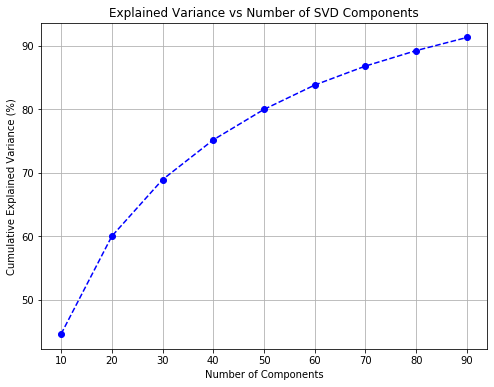

In [63]:
import matplotlib.pyplot as plt
n_components_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]
explained_variance = []  # To store the explained variance for each n_components

# Loop over each value of n_components
for n in n_components_list:
    print(f"\nApplying SVD with {n} components...")
    svd = TruncatedSVD(n_components=n)
    svd.fit(visits)
    explained_variance.append(svd.explained_variance_ratio_.sum())  # Cumulative explained variance
    print(f"Explained variance with {n} components: {svd.explained_variance_ratio_.sum() * 100:.2f}%")

# Plot the cumulative explained variance for different n_components
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, np.array(explained_variance) * 100, marker='o', linestyle='--', color='b')
plt.title("Explained Variance vs Number of SVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.grid(True)
plt.xticks(n_components_list)  # Ensure we have ticks for each value of n_components
plt.show()

In [64]:
print("Train SVD...")
svd = TruncatedSVD(n_components=70)
transformed = svd.fit(visits)

print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())

Train SVD...
[0.01449956 0.14640625 0.05705854 0.05053609 0.03783935 0.03516236
 0.02811937 0.02697372 0.02533098 0.02399252 0.02159322 0.0205004
 0.01744028 0.01713502 0.01511802 0.01391028 0.01317832 0.01227642
 0.01188456 0.01120549 0.01076081 0.0103168  0.00949375 0.00933677
 0.00912812 0.00879413 0.00875807 0.0081697  0.00739285 0.00725882
 0.00688389 0.00678869 0.00660147 0.00650916 0.00629238 0.00614276
 0.00606171 0.00590271 0.00584515 0.00571966 0.00558739 0.00515151
 0.00499946 0.00479335 0.00472078 0.00471309 0.00464374 0.00455063
 0.00441691 0.00434844 0.00424364 0.00416567 0.00402914 0.00398444
 0.00387374 0.00376465 0.00371974 0.00367862 0.00348476 0.00341722
 0.00329051 0.00321783 0.00311623 0.00305421 0.00298094 0.00293856
 0.00287437 0.00279992 0.00263774 0.00257818]
0.8680935380468461


In [65]:
import pandas as pd

# Ensure 'readmission' is of integer type
df['readmission'] = pd.to_numeric(df['readmission'], errors='coerce').fillna(0).astype(int)

# Check the dtype after conversion
print(f"readmission dtype: {df['readmission'].dtype}")

# Convert 'ADMIT_DATETIME' to datetime format
df['ADMIT_DATETIME'] = pd.to_datetime(df['ADMIT_DATETIME'], errors='coerce')

# Check if there are any errors in conversion
if df['ADMIT_DATETIME'].isnull().any():
    print("Some ADMIT_DATETIME values could not be converted to datetime.")

# Create binary encoding for 'ENC_TYPE_IP'
IP_encoded = df['ENC_TYPE_IP'] == '1.0'

# Verify the result
print(f"Number of IP encounters: {IP_encoded.sum()}")
print(f"Number of non-IP encounters: {(~IP_encoded).sum()}")
df['ENC_TYPE_IP'].value_counts()

readmission dtype: int64
Number of IP encounters: 59526
Number of non-IP encounters: 201474


0.0    201474
1.0     59526
Name: ENC_TYPE_IP, dtype: int64

In [66]:
print(df['readmission'].dtype)
print(df['ENC_TYPE_IP'].dtype)

int64
object


In [67]:
df['ENC_TYPE_IP'] = pd.to_numeric(df['ENC_TYPE_IP'], errors='coerce')
print(df['ENC_TYPE_IP'].value_counts())

0.0    201474
1.0     59526
Name: ENC_TYPE_IP, dtype: int64


In [68]:
print(df.columns.isna().sum())

0


In [69]:
df.shape

(261000, 80)

# Preparing Patient Data for Machine Learning

## Goal
The code is designed to prepare patient data for machine learning by transforming encounter-based features (such as demographics, diagnoses, and medications), applying Singular Value Decomposition (SVD) for dimensionality reduction, and handling both patients with and without readmissions.

## Steps
1. **Grouping Patients by ID**: The dataset is grouped by patient ID (`PATID`) and their encounters are processed individually.
   
2. **Handling Patients without Readmissions**:
   - For patients who have no readmissions, a past **inpatient encounter** (`ENC_TYPE_IP`) is randomly selected.
   - A **2-year window** is created around this inpatient encounter to gather all visits within that time frame.

3. **Handling Patients with Readmissions**:
   - For patients who have been readmitted, the **last inpatient encounter before readmission** is selected.
   - A **2-year window** is created around this last inpatient encounter to gather all visits before the readmission event.

4. **Normalizing and Transforming Encounter Data**:
   - The encounter-based features (such as demographics, diagnoses, and medications) are processed.
   - The features are transformed using **Singular Value Decomposition (SVD)** for dimensionality reduction.
   - The data for each visit is flattened into a consistent format.

5. **Appending Data and Labels**:
   - After processing all encounters for a patient, the flattened data (with transformed features) is appended to a list.
   - A **label** is added to each patient's data: `0` for patients with no readmission, and `1` for patients with readmission.

## Purpose
The dataset is transformed into a structured format for use in predictive modeling. The goal is to create a dataset that can be used to predict patient readmissions, with a focus on structured and standardized data that can be fed into machine learning algorithms.


In [71]:
import random
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD

# Define the dataset date range
start_date = pd.to_datetime('2016-12-15')
end_date = pd.to_datetime('2022-09-30')

# Initialize an empty list to store the visit counts for each patient
visit_counts = []

columns = ['ENC_TYPE_ED', 'ENC_TYPE_OS', 'ENC_TYPE_AV_TH', 'ENC_TYPE_IP', 'ENC_TYPE_CLPSED',
           'DISCHARGE_STATUS_HO', 'DISCHARGE_STATUS_HH', 'DISCHARGE_STATUS_SN_RH', 'DISCHARGE_STATUS_AM', 'DISCHARGE_STATUS_CLPSED',
           'SEX_F', 'SEX_M', 'HISPANIC_N', 'HISPANIC_Y', 'HISPANIC_CLPSED',
           'RACE_01_02_04', 'RACE_03', 'RACE_05', 'RACE_CLPSED', 'TOBACCO_01', 'TOBACCO_02', 'TOBACCO_03', 'TOBACCO_CLPSED',
           'SDI_quantile_0', 'SDI_quantile_1', 'SDI_quantile_2', 'SDI_quantile_3', 'SDI_quantile_4',
           'isMetropolitan_0.0', 'isMetropolitan_1.0', 'isMetropolitan_CLPSED', 'CKD_0', 'CKD_1', 'CKD_2', 'CKD_3', 'CKD_4', 'CKD_5',
           'BMI_<18.5', 'BMI_18.5 – 24.9', 'BMI_25.0 – 29.9', 'BMI_30.0+', 'BMI_CLPSED',
           'RUCA_CODE_1.0', 'RUCA_CODE_2.0', 'RUCA_CODE_3+', 'RUCA_CODE_CLPSED',
           'days_since_prior_enc_patient_level', 'days_since_prior_IP_OS_ED_patient_level_int', 'prior_IP_OS_ED_count' , 'prior_other_encounter_types_count',
           'loincs_results_modifier_unit', 'DIASTOLIC', 'SYSTOLIC', 
           'n_dx', 'n_px', 'DX_CCS_codes', 'PX_CCS',
           'age', 'ELIXHAUSER', 'distance',
           'Insulins', 'Glucagon-like peptide-1 (GLP-1) analogues', 'Biguanides', 'Sulfonylureas', 'Thiazolidinediones',
           'Dipeptidyl peptidase 4 (DPP-4) inhibitors', 'Sodium-glucose co-transporter 2 (SGLT2) inhibitors', 'Other blood glucose lowering drugs, excl. insulins', 
           'AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM', 'ANTIHYPERTENSIVES', 'BETA BLOCKING AGENTS', 'CORTICOSTEROIDS FOR SYSTEMIC USE', 'LIPID MODIFYING AGENTS',
            'ADMIT_DURATION']  # Encounter-specific columns

# Initialize list to collect transformed patient data
data = []

# Convert `ENC_TYPE_IP` column to numeric (if necessary)
# df['ENC_TYPE_IP'] = pd.to_numeric(df['ENC_TYPE_IP'], errors='coerce')

# Iterate through the dataframe grouped by patient ID (PATID)
c = 0
for patid, rows in df.groupby("PATID"):
    if c % 10_000 == 0:
        print(f"Processing patient {c} with PATID: {patid}")
    c += 1
    
    random.seed(42)  # Ensure reproducibility
    patient_data = rows.reset_index(drop=True)
    
    # Check if the patient has been readmitted
    readmission_indices = patient_data.index[patient_data['readmission'] == 1].tolist()
    IP_indices = patient_data.index[patient_data['ENC_TYPE_IP'] == 1].tolist()  # Now using numeric 1
    
    # Debugging messages
#     if len(readmission_indices) > 0:
#         print(f"Patient {patid} - Readmission indices: {readmission_indices}")
#     if len(IP_indices) > 0:
#         print(f"Patient {patid} - IP encounter indices: {IP_indices}")
    
    # ==========================================================================================
    # CASE 1: No readmission, pick IP encounter and create 2-year window
    # ==========================================================================================
    if len(readmission_indices) == 0:
#         print(f"Patient {patid} - No readmission found. Selecting IP encounter at random.")
        
        if not IP_indices:
            print(f"Patient {patid} has no IP encounters! Skipping.")
            continue  # Skip this patient if no IP encounter is available
        
        random_IP_indx = random.choice(IP_indices)  # Randomly select an IP encounter
        max_date = patient_data.iloc[random_IP_indx]['ADMIT_DATETIME']
        min_date = max_date - pd.DateOffset(years=2)  # Define the 2-year window
        
        # If the lookback window extends beyond the available data range, skip this patient
        if min_date < start_date:
#             print(f"Patient {patid} - Lookback window extends before {start_date}. Skipping patient.")
            continue  # Skip this patient

        min_date = max(min_date, start_date)  # Enforce the earliest date constraint
        
        # Create the patient data window within the 2-year range
        patient_window = patient_data[
            (patient_data['ADMIT_DATETIME'] >= min_date) & (patient_data['ADMIT_DATETIME'] <= max_date)
        ]
        
#         print(f"Patient {patid} - Window for IP encounter created from {min_date} to {max_date}.")
#         print(f"Patient {patid} - Number of visits in this window: {len(patient_window)}")
        
        # Track the number of visits for this patient
        visit_counts.append(len(patient_window))  # Store the visit count for this patient
        
        
        sample = []
        visit_count = 0
        for indx, row in patient_window.iterrows():
            visit = row[columns].values.tolist()
            visit = [str(v).replace(';', ',').replace('=', '').replace('s', '') for v in visit]
            visit = ','.join(visit).split(',')
            visit = np.asarray(visit, dtype=np.float64)
#             print(f"Before SVD: Visit shape: {visit.shape}")
            
            # Apply SVD transformation to each visit
            visit = visit.reshape(1, -1)
            visit = svd.transform(visit)
#             print(f"After SVD: Visit shape: {visit.shape}")
            # Debugging: Print transformed visit data
#             print(f"Patient {patid} - Transformed visit shape: {visit.shape}")
            
            sample.extend(visit.flatten())
            visit_count += 1
        
        # Add label for no readmission (0)
        sample.extend([0])
        data.append(sample)
        expected_length = visit_count * 70 + 1
        if len(sample) != expected_length:
            print(f"Patient {patid} has incorrect sample length:")
            print(f"  Expected length: {expected_length}, Actual length: {len(sample)}")
            print(f"  Number of visits: {visit_count}")
            print(f"  Sample: {sample[:5]}...")  # Print the first few values of the sample for inspection

    
    # ==========================================================================================
    # CASE 2: Yes readmission, select the last IP before readmission, create 2-year window
    # ==========================================================================================
    elif len(readmission_indices) >= 1:
#         print(f"Patient {patid} - Readmission found. Selecting IP encounter before readmission.")
        
        random_RE_indx = random.choice(readmission_indices)  # Select a random readmission
        max_indx_IP = next((i for i, idx in enumerate(IP_indices) if idx > random_RE_indx), None)
        
        if max_indx_IP is None:
#             print(f"Patient {patid} - No IP encounter found before readmission. Skipping.")
            continue  # Skip if no IP encounter before readmission
        
        max_indx_IP = IP_indices[max_indx_IP - 1]  # Ensure we have the last IP encounter before the readmission
        max_date = patient_data.iloc[max_indx_IP]['ADMIT_DATETIME']
        min_date = max_date - pd.DateOffset(years=2)
        
        # If the lookback window extends beyond the available data range, skip this patient
        if min_date < start_date:
#             print(f"Patient {patid} - Lookback window extends before {start_date}. Skipping patient.")
            continue  # Skip this patient

        min_date = max(min_date, start_date)  # Enforce the earliest date constraint
        
        # Create patient window for the 2-year period
        patient_window = patient_data[
            (patient_data['ADMIT_DATETIME'] >= min_date) & (patient_data['ADMIT_DATETIME'] <= max_date)
        ]
        
#         print(f"Patient {patid} - Window for IP encounter created from {min_date} to {max_date}.")
#         print(f"Patient {patid} - Number of visits in this window: {len(patient_window)}")
        
        # Track the number of visits for this patient
        visit_counts.append(len(patient_window))  # Store the visit count for this patient
        
        sample = []
        visit_count = 0
        for indx, row in patient_window.iterrows():
            visit = row[columns].values.tolist()
            visit = [str(v).replace(';', ',').replace('=', '').replace('s', '') for v in visit]
            visit = ','.join(visit).split(',')
            visit = np.asarray(visit, dtype=np.float64)
#             print(f"Before SVD: Visit shape: {visit.shape}")
            # Apply SVD transformation to each visit
            visit = visit.reshape(1, -1)
            visit = svd.transform(visit)
#             print(f"After SVD: Visit shape: {visit.shape}")
            # Debugging: Print transformed visit data
#             print(f"Patient {patid} - Transformed visit shape: {visit.shape}")
            
    
            visit = visit.flatten()  # Flatten the visit
#             print(f"Flattened visit shape: {visit.shape}")  # This should be (70,)
            sample.extend(visit)  # Append the flattened visit to the sample
            visit_count += 1
        
        # Add label for readmission (1)
        sample.extend([1])
        # Check the length of the full sample
#         print(f"Sample length for patient {patid}: {len(sample)}")  # Should be (n * 70 + 1)
        data.append(sample)
    
        expected_length = visit_count * 70 + 1
        if len(sample) != expected_length:
            print(f"Patient {patid} has incorrect sample length:")
            print(f"  Expected length: {expected_length}, Actual length: {len(sample)}")
            print(f"  Number of visits: {visit_count}")
            print(f"  Sample: {sample[:5]}...")  # Print the first few values of the sample for inspection


# Final debugging message
print(f"Total number of samples processed: {len(data)}")

# Calculate the average number of visits
average_visits = np.mean(visit_counts)
print(f"Average number of visits per patient in the 2-year window: {average_visits:.2f}")

Processing patient 0 with PATID: 700000015
Processing patient 10000 with PATID: 700047495
Processing patient 20000 with PATID: 700095448
Total number of samples processed: 15852
Average number of visits per patient in the 2-year window: 4.05


In [73]:
print(len(data), "X", len(data[3]))

15852 X 71


In [74]:
# save input to ML
import csv

with open(PATH_PROCESSED_DATA + "discharge_preprocessed_ML_allLabs_70_components.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(data)

In [75]:
# # Load
# data = []
# with open("/data/ameen/processed_data/newGeisinger/Geisinger_preprocessed_ML_allLabs_150components.csv") as csvfile:
#     csv_reader = csv.reader(csvfile, delimiter=',')
    
#     for row in csv_reader:
#         data.append( list(map(float, row)) )
        


In [76]:
# how many 0 and how many 1

y = []

for i in data:
    
    y.append( int(i[-1]) )

np.unique(np.asarray(y), return_counts=True)

# data:  (array([0, 1]), array([27511,  9130]))
# data_: 

(array([0, 1]), array([14000,  1852]))

In [77]:
# get maximum length of a sample 
# first, run the code without the if condition and append to data_ to determine max length 

# x: 100, 80, 60, 30, 15, 8, 4, 2, 1

n_last_visits = (70 * 100) + 1 # (70 features per visit * last x visits) + 1 (label)

    
n_features = 70 * 100

sample_lengths = []
data_ = []

# remove patients who have more than 9000 features (outliers)
for i in data:
    
    # if len(i[0:-1]) <= 10020:
    #     data_.append(i)
       
    x = i[-n_last_visits: ] # last x visits
    sample_lengths.append( len(x) )
#     data_.append(x)


print("min:", np.min(np.asarray(sample_lengths)), "max:", np.max(np.asarray(sample_lengths)))
np.unique(np.asarray(sample_lengths), return_counts=True)

min: 71 max: 6161


(array([  71,  141,  211,  281,  351,  421,  491,  561,  631,  701,  771,
         841,  911,  981, 1051, 1121, 1191, 1261, 1331, 1401, 1471, 1541,
        1611, 1681, 1751, 1821, 1891, 1961, 2031, 2101, 2171, 2241, 2311,
        2381, 2451, 2521, 2591, 2661, 2731, 2801, 2871, 2941, 3011, 3081,
        3151, 3221, 3291, 3361, 3431, 3501, 3571, 3851, 3921, 4061, 4131,
        4201, 4341, 5181, 5251, 6161]),
 array([7415, 2677, 1305,  776,  533,  447,  341,  297,  237,  209,  195,
         163,  155,  135,  117,   97,   85,   70,   82,   54,   51,   49,
          40,   36,   27,   38,   21,   17,   16,   21,   16,   16,   12,
          14,   11,   10,    6,    3,    9,    2,    3,    5,    2,    6,
           2,    3,    5,    2,    1,    1,    1,    4,    2,    3,    1,
           2,    1,    1,    1,    1]))

In [78]:
import numpy as np

sample_lengths = []

# Append all sample lengths to the list 
for i in data:
    x = i[-n_last_visits:]  # Last n_last_visits features 
    sample_lengths.append(len(x))

# Convert sample_lengths to a numpy array for easier manipulation
sample_lengths = np.asarray(sample_lengths)

# Calculate Q1, Q3, and IQR
Q1 = np.percentile(sample_lengths, 25)  # First quartile (25th percentile)
Q3 = np.percentile(sample_lengths, 75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = sample_lengths[(sample_lengths < lower_bound) | (sample_lengths > upper_bound)]

print(f"Outlier thresholds: Lower bound = {lower_bound}, Upper bound = {upper_bound}")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier values: {outliers}")

# remove outliers from data_ (filtered data) by checking lengths
data_filtered = [i for i in data if len(i) >= lower_bound and len(i) <= upper_bound]

print(f"Number of samples after filtering: {len(data_filtered)}")

Outlier thresholds: Lower bound = -244.0, Upper bound = 596.0
Number of outliers: 2061
Outlier values: [ 631  631  911 ...  631  911 1121]
Number of samples after filtering: 13791


In [79]:
data_ = data_filtered

In [80]:
len(data_)

13791

In [81]:
###### get maximum length of a sample 
# first, run the code without the if condition and append to data_ to determine max length 

n_last_visits = (70 * 8) + 1 # (70 features per visit * last x visits) + 1 (label)

    
n_features = 70 * 8

sample_lengths = []

# remove patients who have more than 9000 features (outliers)
for i in data_:
    
    # if len(i[0:-1]) <= 10020:
    #     data_.append(i)
       
    x = i[-n_last_visits: ] # last x visits
    sample_lengths.append( len(x) )
#     data_.append(x)


print("min:", np.min(np.asarray(sample_lengths)), "max:", np.max(np.asarray(sample_lengths)))
np.unique(np.asarray(sample_lengths), return_counts=True)

min: 71 max: 561


(array([ 71, 141, 211, 281, 351, 421, 491, 561]),
 array([7415, 2677, 1305,  776,  533,  447,  341,  297]))

In [82]:
# unify dimensions by padding with 0's

# 8 visits * 70 per visit = 561 feautes

X = []
y = []

c = 0
for row in data_:
    
    if c%1000 == 0: print(c)
    c+=1
     
    y_ = row[-1]
    x = row[0:-1]
    
    x.extend( [0.0] * ( n_features - (len(x) ) ) )
    
    x = np.asarray(x, dtype=np.float64)
    X.append(x)
    y.append( int(y_) )

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [83]:
X = np.array(X)  # Convert the list of feature vectors into a numpy array
y = np.array(y)  # Convert the list of labels into a numpy array

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (13791, 560)
Shape of y: (13791,)


In [84]:
X[0].shape

(560,)

In [85]:
np.save(PATH_PROCESSED_DATA+"Discharge_70_X.npy", X)
np.save(PATH_PROCESSED_DATA+"Discharge_70_y.npy", y)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [88]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([2475,  284]))